## <font color="blue">2.1 Data upload</font>

In [1]:
import pandas as pd
import os

# Define the path to your local data folder
data_path = 'MovieLensSmall/'

# Check if the folder exists (opcional)
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The data folder {data_path} does not exist.")

# Load ratings: user id | item id | rating | timestamp
ratings_df = pd.read_csv(
    os.path.join(data_path, 'u.data'),
    sep='\t',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
    engine='python'
)

# Load users: user id | age | gender | occupation | zip code
users_df = pd.read_csv(
    os.path.join(data_path, 'u.user'),
    sep='|',
    names=['UserID', 'Age', 'Gender', 'Occupation', 'Zip-code'],
    engine='python'
)

# Define genre columns in the same order as in the u.item file
genre_cols = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Define full column names for u.item
movie_cols = ['MovieID', 'Title', 'ReleaseDate', 'VideoReleaseDate', 'IMDbURL'] + genre_cols

# Load movies and keep only MovieID, Title, and genre columns
movies_df = pd.read_csv(
    os.path.join(data_path, 'u.item'),
    sep='|',
    names=movie_cols,
    usecols=['MovieID', 'Title'] + genre_cols,
    encoding='latin1',
    engine='python'
)

# Optional: print shape to verify loading
print(f"Ratings data shape: {ratings_df.shape}")
print(f"Users data shape: {users_df.shape}")
print(f"Movies data shape: {movies_df.shape}")


Ratings data shape: (100000, 4)
Users data shape: (943, 5)
Movies data shape: (1682, 21)


### <font color="blue">3.1.1 Collaborative Filtering: Building the Ratings Matrix</font>

In [2]:
import pandas as pd
from IPython.display import display, HTML

# Create the ratings matrix (UserID as rows, MovieID as columns)
ratings_matrix = ratings_df.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Display a smaller subset to keep it readable (e.g., first 10 rows and columns)
subset_matrix = ratings_matrix.iloc[:10, :10]


# Show as styled HTML table
display(HTML(subset_matrix.to_html()))


MovieID,1,2,3,4,5,6,7,8,9,10
UserID,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN


#### <font color="blue">Train & Test Split</font>

In [4]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import KFold

# Set seeds for reproducibility
np.random.seed(1)
random.seed(1)

# ratings_matrix: matriz usuarios x películas, ya definida
# Convertimos a array para trabajar con índices más rápido
user_ids = ratings_matrix.index.tolist()
user_indices = np.arange(len(user_ids))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar los folds
folds = []

for fold_num, (train_user_idx, test_user_idx) in enumerate(kf.split(user_indices)):
    print(f"\n🔄 Fold {fold_num + 1}")
    
    # Índices de usuarios
    train_users = [user_ids[i] for i in train_user_idx]
    test_users = [user_ids[i] for i in test_user_idx]

    # Crear copias de la matriz completa
    train_matrix = ratings_matrix.copy()
    test_matrix = pd.DataFrame(np.nan, index=ratings_matrix.index, columns=ratings_matrix.columns)

    skipped_users = 0

    for user in test_users:
        user_ratings = ratings_matrix.loc[user].dropna()

        if len(user_ratings) >= 5:
            test_items = random.sample(list(user_ratings.index), 5)
            for item in test_items:
                # Move rating to test matrix
                test_matrix.at[user, item] = ratings_matrix.at[user, item]
                # Mask it in train
                train_matrix.at[user, item] = np.nan
        else:
            skipped_users += 1  # Opcional: para ver cuántos usuarios se omiten

    # Guarda este fold
    folds.append((train_matrix, test_matrix))

    # Mostrar estadísticas
    train_ratings = np.count_nonzero(~np.isnan(train_matrix.values))
    test_ratings = np.count_nonzero(~np.isnan(test_matrix.values))
    print(f"✅ Train ratings: {train_ratings}")
    print(f"✅ Test ratings: {test_ratings}")
    print(f"🚫 Skipped test users (less than 5 ratings): {skipped_users}")



🔄 Fold 1
✅ Train ratings: 99055
✅ Test ratings: 945
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 2
✅ Train ratings: 99055
✅ Test ratings: 945
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 3
✅ Train ratings: 99055
✅ Test ratings: 945
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 4
✅ Train ratings: 99060
✅ Test ratings: 940
🚫 Skipped test users (less than 5 ratings): 0

🔄 Fold 5
✅ Train ratings: 99060
✅ Test ratings: 940
🚫 Skipped test users (less than 5 ratings): 0


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
import numpy as np
import pandas as pd

# Modelos básicos
def global_mean(train):
    mean = np.nanmean(train.values)
    return pd.DataFrame(mean, index=train.index, columns=train.columns)

def item_mean(train):
    means = train.mean(axis=0)
    return pd.DataFrame(np.tile(means.values, (train.shape[0], 1)),
                        index=train.index, columns=train.columns)

def user_mean(train):
    means = train.mean(axis=1)
    return pd.DataFrame(np.tile(means.values.reshape(-1, 1), (1, train.shape[1])),
                        index=train.index, columns=train.columns)

def random_baseline(train):
    min_rating = np.nanmin(train.values)
    max_rating = np.nanmax(train.values)
    rand_preds = np.random.uniform(min_rating, max_rating, size=train.shape)
    return pd.DataFrame(rand_preds, index=train.index, columns=train.columns)

def popularity_baseline(train):
    item_popularity = np.sum(~np.isnan(train.values), axis=0)  # número de ratings por ítem
    preds = np.full(train.shape, np.nan)  # empezamos con predicciones vacías

    for u in range(train.shape[0]):
        # Ítems no vistos por el usuario
        unseen_items = np.isnan(train.values[u])
        # Asigna el score de popularidad a esos ítems
        preds[u, unseen_items] = item_popularity[unseen_items]

    # Normaliza por conveniencia (entre 1 y 5 por ejemplo)
    min_score = np.nanmin(preds)
    max_score = np.nanmax(preds)
    if max_score > min_score:
        preds = 1 + 4 * (preds - min_score) / (max_score - min_score)  # normalizar a escala 1-5

    return pd.DataFrame(preds, index=train.index, columns=train.columns)

models = {
    "Global Mean": global_mean,
    "Item Mean": item_mean,
    "User Mean": user_mean,
    "Random": random_baseline,
    "Popularity": popularity_baseline
}

final_results = []

def compute_all_metrics(test_matrix, pred_matrix, train_matrix):
    R_test = test_matrix.values
    R_pred = pred_matrix.values
    R_train = train_matrix.values
    num_users, num_items = R_test.shape

    test_indices = list(zip(*np.where(~np.isnan(R_test))))
    y_true, y_pred = [], []

    for u, i in test_indices:
        pred = R_pred[u, i]
        true = R_test[u, i]
        if not np.isnan(pred) and not np.isnan(true):
            y_pred.append(pred)
            y_true.append(true)

    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Novelty
    item_popularity = np.sum(~np.isnan(R_train), axis=0)
    item_popularity_inv = 1 / (item_popularity + 1)

    novelty_list = []
    relevance_list = []

    for u in range(num_users):
        known_items = ~np.isnan(R_train[u])
        unknown_items = np.where(~known_items)[0]
        if len(unknown_items) == 0:
            continue
        top_20 = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
        novelty_u = np.mean([item_popularity_inv[i] for i in top_20])
        novelty_list.append(novelty_u)

        rel = [R_test[u, i] for i in top_20 if not np.isnan(R_test[u, i])]
        if rel:
            relevance_list.append(np.mean(rel))

    novelty = np.mean(novelty_list)
    relevance = np.mean(relevance_list)

    # Serendipity
    serendipity_scores = [abs(R_pred[u, i] - R_test[u, i]) for u, i in test_indices if np.isnan(R_train[u, i])]
    serendipity = np.mean(serendipity_scores)

    # Diversity
    R_train_filled = np.nan_to_num(R_train)
    item_sim = cosine_similarity(R_train_filled.T)

    diversity_list = []
    for u in range(num_users):
        top_5 = np.argsort(R_pred[u])[-5:]
        div = 0
        count = 0
        for i in range(len(top_5)):
            for j in range(i + 1, len(top_5)):
                div += 1 - item_sim[top_5[i], top_5[j]]
                count += 1
        if count > 0:
            diversity_list.append(div / count)
    diversity = np.mean(diversity_list)

    # nDCG@20
    def dcg(rel):
        return sum(r / np.log2(i + 2) for i, r in enumerate(rel))

    def ndcg(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

    ndcg_scores = [ndcg(u) for u in range(num_users)]
    ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
    ndcg_score = np.mean(ndcg_scores)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "Novelty": novelty,
        "Relevance": relevance,
        "Serendipity": serendipity,
        "Diversity": diversity,
        "nDCG@20": ndcg_score
    }

# Evaluación cruzada para todos los modelos
for model_name, model_func in models.items():
    print(f"\n🔍 Evaluando modelo: {model_name}")
    fold_metrics = []
    for fold_idx, (train_matrix, test_matrix) in enumerate(folds):
        pred_matrix = model_func(train_matrix)
        metrics = compute_all_metrics(test_matrix, pred_matrix, train_matrix)
        metrics["Fold"] = fold_idx + 1
        metrics["Model"] = model_name
        fold_metrics.append(metrics)
    df_fold = pd.DataFrame(fold_metrics)
    mean_metrics = df_fold.mean(numeric_only=True).to_dict()
    mean_metrics["Model"] = model_name
    final_results.append(mean_metrics)

# Resultados finales en tabla
results_table = pd.DataFrame(final_results)
print("\n📊 Resultados promedio de los modelos benchmark con todas las métricas:")
print(results_table[['Model', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])






🔍 Evaluando modelo: Global Mean

🔍 Evaluando modelo: Item Mean

🔍 Evaluando modelo: User Mean

🔍 Evaluando modelo: Random

🔍 Evaluando modelo: Popularity

📊 Resultados promedio de los modelos benchmark con todas las métricas:
         Model      RMSE       MAE  Relevance   Novelty  Serendipity  \
0  Global Mean  1.131323  0.952467   3.315833  0.065247     0.952467   
1    Item Mean  1.046331  0.835380   4.367500  0.293810     0.835997   
2    User Mean  1.060559  0.849070   3.315833  0.065247     0.849070   
3       Random  1.719705  1.405733   3.294945  0.112880     1.405733   
4   Popularity  1.855435  1.564943   3.831671  0.002823     1.564943   

   Diversity   nDCG@20  
0   0.843632  0.172627  
1   1.000000  0.157522  
2   0.843632  0.172627  
3   0.914247  0.180333  
4   0.669069  0.152542  


### <font color="blue">3.1.2 **Collaborative Filtering:**  Neighborhood models</font>

##### <font color="bLUE"> PEARSON CORRELATION

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Configuración
k_values = [50, 150, 500, None]  # Número de vecinos (None = all)
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

# ⚠️ Asegúrate de que 'folds' esté definido como lista de (train_df, test_df)

def compute_similarity_matrix(R_train, user_means):
    num_users = R_train.shape[0]
    sim_matrix = np.zeros((num_users, num_users))
    for u in tqdm(range(num_users), desc="📏 Similitud Pearson"):
        for v in range(num_users):
            if u != v:
                common = ~np.isnan(R_train[u]) & ~np.isnan(R_train[v])
                if np.sum(common) > 0:
                    ru = R_train[u, common] - user_means[u]
                    rv = R_train[v, common] - user_means[v]
                    num = np.dot(ru, rv)
                    denom = np.sqrt(np.sum(ru ** 2)) * np.sqrt(np.sum(rv ** 2))
                    sim_matrix[u, v] = num / denom if denom != 0 else 0
    return sim_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[v, j] - user_means[v]) for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else user_means[u] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        user_means = np.array([
            np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
            for u in range(num_users)
        ])

        similarity_matrix = compute_similarity_matrix(R_train, user_means)

        print("🔮 Prediciendo ratings...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        novelty_list = []
        relevance_list = []

        for u in range(num_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue
            top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
            novelty_list.append(novelty_u)
            rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(relevances):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

        def ndcg_at_k(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
        ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
        ndcg_score = np.mean(ndcg_list)

        fold_result = {
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG@20": ndcg_score,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Pearson"
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Memory-based CF",
        "k_neighbors": "all" if k is None else k,
        "Similarity": "Pearson"
    })
    final_results.append(avg_metrics)

# Mostrar resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[['k_neighbors', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.68it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.61it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.51it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:54<00:00, 17.18it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.38it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.94it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:08<00:00,  1.55it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.43it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:02<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:54<00:00, 17.23it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.78it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.75it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:04<00:00,  1.56it/s]



🔁 Ejecutando 5-Fold CV para k = 500

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.71it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:02<00:00,  1.56it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.50it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.95it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.52it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.90it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:04<00:00,  1.56it/s]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.96it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.60it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.81it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:07<00:00,  1.55it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.78it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:09<00:00,  1.55it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.46it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  0.979983  0.771798   3.750000  0.381287     0.771798   
1         150  0.974856  0.766927   3.500000  0.382091     0.766927   
2         500  0.976163  0.768558   3.333333  0.382153     0.768558   
3         all  0.976179  0.768585   3.333333  0.382154     0.768585   

   Diversity   nDCG@20  
0   0.882757  0.161618  
1   0.882830  0.161081  
2   0.882882  0.161011  
3   0.882885  0.161011  


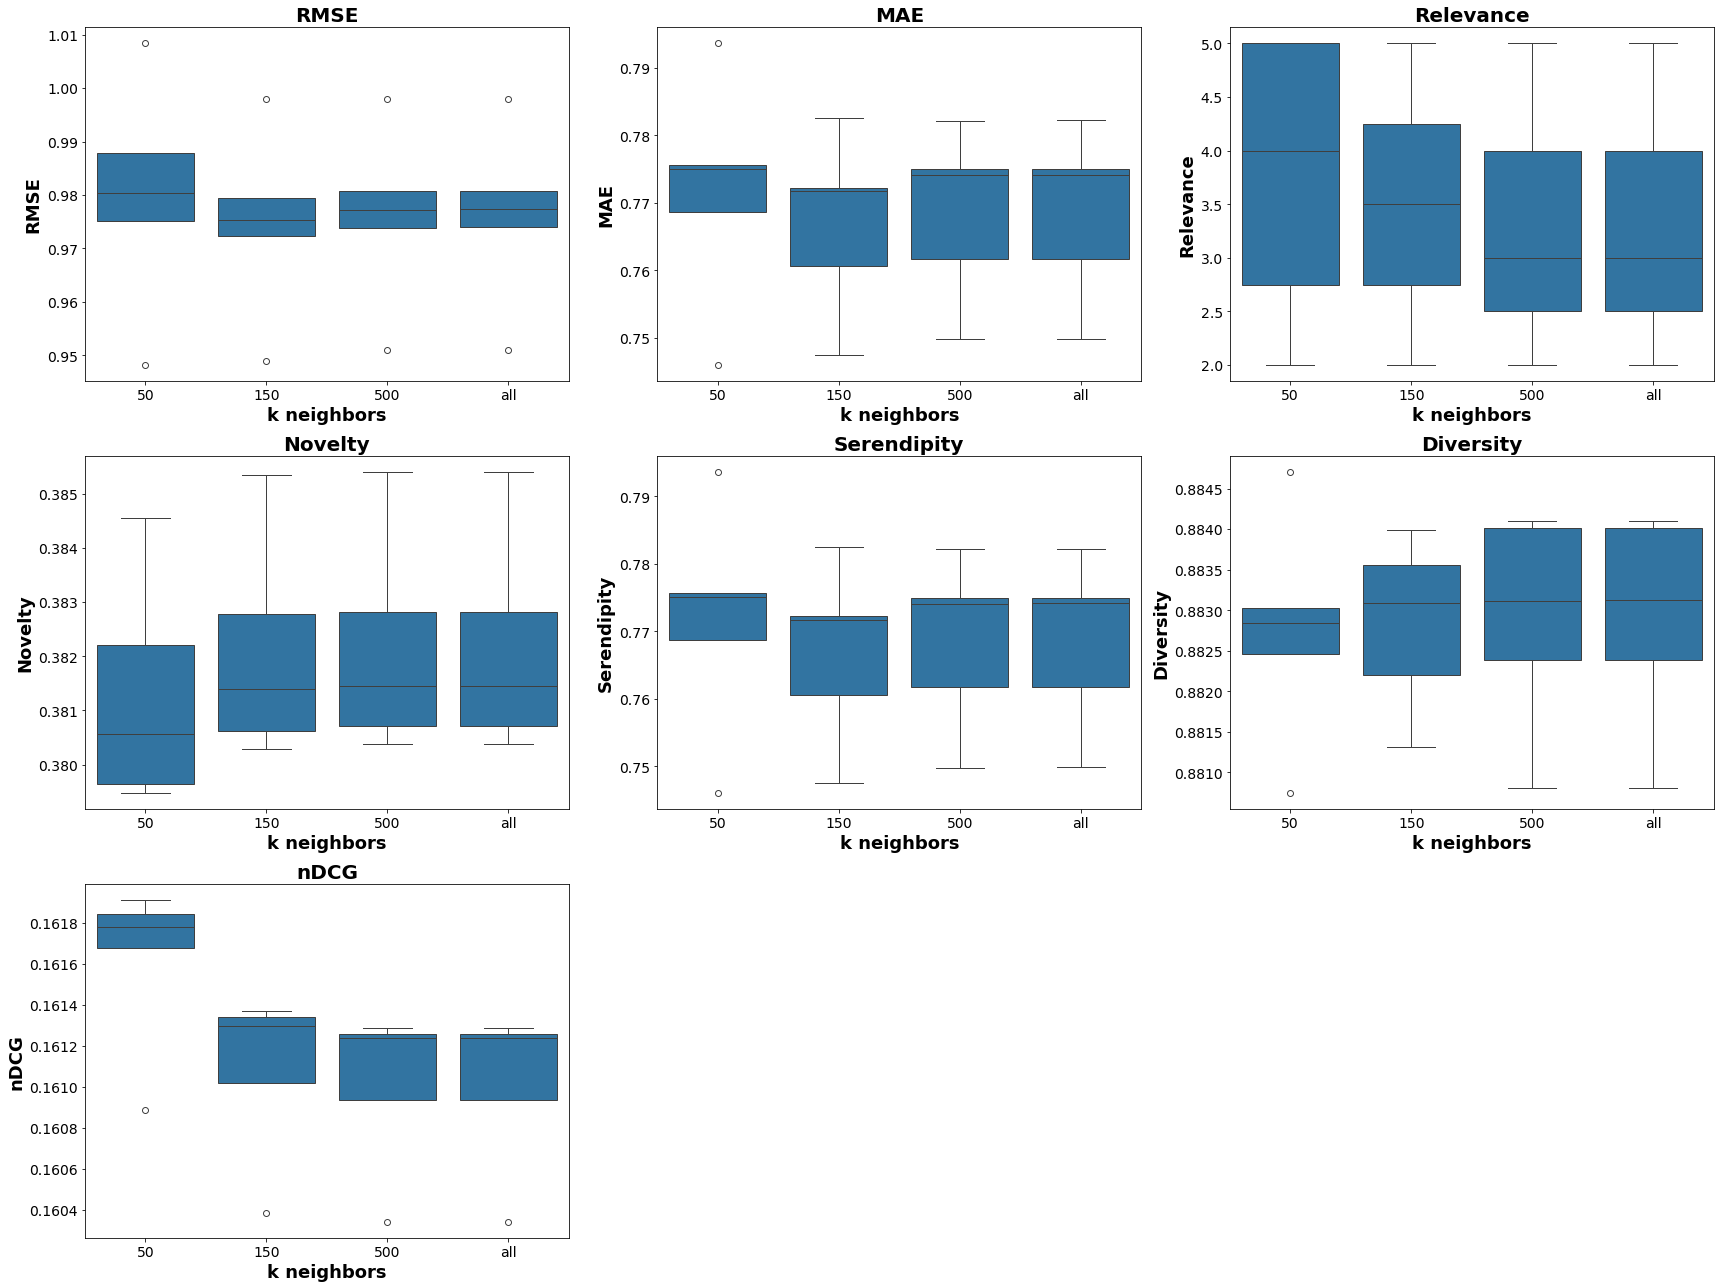

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)

# Renombrar columna si es necesario
df_box = df_box.rename(columns={'nDCG@20': 'nDCG'})

metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()



In [41]:
results_table

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,k_neighbors,Model,Similarity
0,0.979983,0.771798,0.381287,3.750000,0.771798,0.882757,0.161618,50,Memory-based CF,Pearson
1,0.974856,0.766927,0.382091,3.500000,0.766927,0.882830,0.161081,150,Memory-based CF,Pearson
2,0.976163,0.768558,0.382153,3.333333,0.768558,0.882882,0.161011,500,Memory-based CF,Pearson
3,0.976179,0.768585,0.382154,3.333333,0.768585,0.882885,0.161011,all,Memory-based CF,Pearson


##### <font color="bLUE"> RAW COSINE SIMILARITY

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Configuración
k_values = [50, 150, 500, None]  # Número de vecinos (None = all)
final_results = []
all_folds_metrics = []

# ⚠️ Asegúrate de que 'folds' esté definido como lista de (train_df, test_df)

def compute_cosine_similarity(R_train):
    R_train_filled = np.nan_to_num(R_train)
    similarity_matrix = cosine_similarity(R_train_filled)
    np.fill_diagonal(similarity_matrix, 0)
    return similarity_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * R_train[v, j] for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        user_means = np.array([
            np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
            for u in range(num_users)
        ])

        similarity_matrix = compute_cosine_similarity(R_train)

        print("🔮 Prediciendo ratings...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        novelty_list = []
        relevance_list = []

        for u in range(num_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue
            top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
            novelty_list.append(novelty_u)
            rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(relevances):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

        def ndcg_at_k(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
        ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
        ndcg_score = np.mean(ndcg_list)

        fold_result = {
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG@20": ndcg_score,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Cosine"
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Memory-based CF",
        "k_neighbors": "all" if k is None else k,
        "Similarity": "Cosine"
    })
    final_results.append(avg_metrics)

# Mostrar resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[['k_neighbors', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])





🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:46<00:00,  1.61it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:45<00:00,  1.61it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:44<00:00,  1.61it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:47<00:00,  1.60it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:50<00:00,  1.60it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:50<00:00,  1.60it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



🔁 Ejecutando 5-Fold CV para k = 500

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:44<00:00,  1.61it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:52<00:00,  1.59it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  1.032482  0.820476   4.460782  0.274018     0.820476   
1         150  1.037241  0.825681   4.449574  0.280058     0.825681   
2         500  1.040717  0.829849   4.483485  0.282374     0.829849   
3         all  1.040715  0.829864   4.471667  0.282409     0.829864   

   Diversity   nDCG@20  
0   0.889102  0.157145  
1   0.891237  0.157202  
2   0.889345  0.157453  
3   0.889398  0.157453  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
results_table

#### <font color="bLUE"> Significance Weighting

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Parámetros a evaluar
k_values = [50, 150, 500, None]
beta_values = [30, 100, 300]

final_results = []
all_folds_metrics = []

# 🔁 Discounted Pearson Similarity
def discounted_pearson_similarity(R_train, user_means, beta=50):
    num_users = R_train.shape[0]
    sim_matrix = np.zeros((num_users, num_users))
    for u in tqdm(range(num_users), desc=f"📏 Pearson Desc (β={beta})"):
        for v in range(num_users):
            if u != v:
                common = ~np.isnan(R_train[u]) & ~np.isnan(R_train[v])
                n_common = np.sum(common)
                if n_common >= 2:
                    ru = R_train[u, common] - user_means[u]
                    rv = R_train[v, common] - user_means[v]
                    num = np.dot(ru, rv)
                    denom = np.sqrt(np.sum(ru ** 2)) * np.sqrt(np.sum(rv ** 2))
                    pearson = num / denom if denom != 0 else 0
                    discount = min(n_common, beta) / beta
                    sim_matrix[u, v] = pearson * discount
    return sim_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[v, j] - user_means[v]) for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else user_means[u] + num / denom
    return predictions

# 🔁 Evaluación para cada combinación (k, beta)
for beta in beta_values:
    for k in k_values:
        print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k else 'all'}, beta = {beta}")
        fold_metrics = []

        for fold_num, (train_matrix, test_matrix) in enumerate(folds):
            print(f"\n▶️ Fold {fold_num + 1}")

            R_train = train_matrix.values
            R_test = test_matrix.values
            num_users, num_items = R_train.shape

            user_means = np.array([
                np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
                for u in range(num_users)
            ])

            similarity_matrix = discounted_pearson_similarity(R_train, user_means, beta)

            print("🔮 Prediciendo ratings...")
            R_pred_rows = Parallel(n_jobs=-1)(
                delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
                for u in tqdm(range(num_users), desc="Usuarios")
            )
            R_pred = np.vstack(R_pred_rows)

            predicted, actual = [], []
            test_indices = list(zip(*np.where(~np.isnan(R_test))))
            for u, j in test_indices:
                predicted.append(R_pred[u, j])
                actual.append(R_test[u, j])

            rmse = sqrt(mean_squared_error(actual, predicted))
            mae = mean_absolute_error(actual, predicted)

            item_popularity = np.sum(~np.isnan(R_train), axis=0)
            item_popularity_inv = 1 / (item_popularity + 1)

            R_train_filled = np.nan_to_num(R_train)
            item_similarity = cosine_similarity(R_train_filled.T)

            novelty_list = []
            relevance_list = []

            for u in range(num_users):
                known_train_items = ~np.isnan(R_train[u])
                unknown_items = np.where(~known_train_items)[0]
                if len(unknown_items) == 0:
                    continue
                top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
                novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
                novelty_list.append(novelty_u)
                rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
                if rel:
                    relevance_list.append(np.mean(rel))

            novelty = np.mean(novelty_list)
            relevance = np.mean(relevance_list)

            serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
            serendipity = np.mean(serendipity_scores)

            diversity_scores = []
            for u in range(num_users):
                top_5 = np.argsort(R_pred[u, :])[-5:]
                div = 0
                count = 0
                for i in range(len(top_5)):
                    for j2 in range(i + 1, len(top_5)):
                        div += 1 - item_similarity[top_5[i], top_5[j2]]
                        count += 1
                diversity_scores.append(div / count if count > 0 else 0)
            diversity = np.mean(diversity_scores)

            def dcg(relevances):
                return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

            def ndcg_at_k(u, k="all"):
                known_train_items = ~np.isnan(R_train[u])
                unknown_items = np.where(~known_train_items)[0]
                if len(unknown_items) == 0:
                    return np.nan
                k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
                top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
                rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
                dcg_score = dcg(rel_pred)
                actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
                if not actual_ratings:
                    return np.nan
                actual_ratings.sort(key=lambda x: x[1], reverse=True)
                ideal_rel = [r for _, r in actual_ratings[:k_val]]
                ideal_dcg = dcg(ideal_rel)
                return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

            ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
            ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
            ndcg_score = np.mean(ndcg_list)

            fold_result = {
                "RMSE": rmse,
                "MAE": mae,
                "Novelty": novelty,
                "Relevance": relevance,
                "Serendipity": serendipity,
                "Diversity": diversity,
                "nDCG": ndcg_score,
                "k_neighbors": "all" if k is None else k,
                "Beta": beta,
                "Model": "Memory-based CF",
                "Similarity": "Discounted Pearson"
            }

            fold_metrics.append(fold_result)
            all_folds_metrics.append(fold_result)

        avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
        avg_metrics.update({
            "Model": "Memory-based CF",
            "k_neighbors": "all" if k is None else k,
            "Beta": beta,
            "Similarity": "Discounted Pearson"
        })
        final_results.append(avg_metrics)

# Mostrar tabla de resultados
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k y β:")
print(results_table[['k_neighbors', 'Beta', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']])



🔁 Ejecutando 5-Fold CV para k = 50, beta = 30

▶️ Fold 1


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:06<00:00, 14.23it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



▶️ Fold 2


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:55<00:00, 17.07it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:46<00:00,  1.61it/s]



▶️ Fold 3


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:54<00:00, 17.18it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 4


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:59<00:00, 15.76it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 5


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:59<00:00, 15.75it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



🔁 Ejecutando 5-Fold CV para k = 150, beta = 30

▶️ Fold 1


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:54<00:00, 17.27it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 2


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:55<00:00, 17.01it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 3


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:54<00:00, 17.29it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 4


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:00<00:00, 15.67it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 5


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:00<00:00, 15.69it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



🔁 Ejecutando 5-Fold CV para k = 500, beta = 30

▶️ Fold 1


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:54<00:00, 17.24it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:01<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:55<00:00, 17.11it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:01<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 3


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:55<00:00, 16.84it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:01<00:00, 15.44it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.58it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 5


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:00<00:00, 15.52it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:52<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = all, beta = 30

▶️ Fold 1


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:54<00:00, 17.15it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:55<00:00, 17.04it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:01<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 3


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [00:55<00:00, 16.88it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:05<00:00,  1.56it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:00<00:00, 15.65it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 5


📏 Pearson Desc (β=30): 100%|██████████| 943/943 [01:01<00:00, 15.31it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 50, beta = 100

▶️ Fold 1


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:54<00:00, 17.44it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:46<00:00,  1.61it/s]



▶️ Fold 2


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:55<00:00, 16.90it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 3


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:55<00:00, 16.97it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:52<00:00,  1.59it/s]



▶️ Fold 4


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:59<00:00, 15.79it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:45<00:00,  1.61it/s]



▶️ Fold 5


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [01:00<00:00, 15.50it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 150, beta = 100

▶️ Fold 1


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:54<00:00, 17.42it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 2


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:55<00:00, 16.96it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 3


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:55<00:00, 16.87it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 4


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [01:00<00:00, 15.47it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



▶️ Fold 5


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [01:00<00:00, 15.52it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 500, beta = 100

▶️ Fold 1


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:53<00:00, 17.48it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:56<00:00, 16.81it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 3


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:55<00:00, 16.87it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [01:00<00:00, 15.60it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:05<00:00,  1.56it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 5


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [01:00<00:00, 15.64it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



🔁 Ejecutando 5-Fold CV para k = all, beta = 100

▶️ Fold 1


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:53<00:00, 17.48it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:55<00:00, 17.06it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 3


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:56<00:00, 16.70it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [00:59<00:00, 15.74it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.58it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 5


📏 Pearson Desc (β=100): 100%|██████████| 943/943 [01:01<00:00, 15.45it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 50, beta = 300

▶️ Fold 1


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:53<00:00, 17.69it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:52<00:00,  1.59it/s]



▶️ Fold 2


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:56<00:00, 16.78it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:52<00:00,  1.59it/s]



▶️ Fold 3


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:55<00:00, 16.97it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.60it/s]



▶️ Fold 4


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:59<00:00, 15.80it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 5


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:00<00:00, 15.53it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 150, beta = 300

▶️ Fold 1


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:54<00:00, 17.38it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 2


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:57<00:00, 16.42it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 3


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:54<00:00, 17.19it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 4


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:01<00:00, 15.23it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 5


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:00<00:00, 15.63it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 500, beta = 300

▶️ Fold 1


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:53<00:00, 17.52it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:06<00:00,  1.56it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:55<00:00, 16.99it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 3


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:54<00:00, 17.18it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:01<00:00, 15.38it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 5


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:00<00:00, 15.51it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



🔁 Ejecutando 5-Fold CV para k = all, beta = 300

▶️ Fold 1


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:53<00:00, 17.57it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 2


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:55<00:00, 16.95it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 3


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [00:56<00:00, 16.81it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.57it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 4


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:01<00:00, 15.41it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.58it/s]
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmoral/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



▶️ Fold 5


📏 Pearson Desc (β=300): 100%|██████████| 943/943 [01:01<00:00, 15.31it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



📊 RESULTADOS PROMEDIO POR k y β:
   k_neighbors  Beta      RMSE       MAE  Relevance   Novelty  Serendipity  \
0           50    30  0.959947  0.751130   4.696190  0.374388     0.751130   
1          150    30  0.962873  0.755141   4.700000  0.379023     0.755141   
2          500    30  0.965221  0.758606   5.000000  0.379331     0.758606   
3          all    30  0.965237  0.758631   5.000000  0.379331     0.758631   
4           50   100  0.960841  0.749947   4.558333  0.367269     0.749947   
5          150   100  0.962315  0.753349   4.733333  0.374121     0.753349   
6          500   100  0.964069  0.756378   5.000000  0.374631     0.756378   
7          all   100  0.964082  0.756396   5.000000  0.374631     0.756396   
8           50   300  0.960901  0.749838   4.558333  0.365293     0.749838   
9          150   300  0.962288  0.753170   4.733333  0.372393     0.753170   
10         500   300  0.963962  0.756088   5.000000  0.372932     0.756088   
11         all   300  0.963975

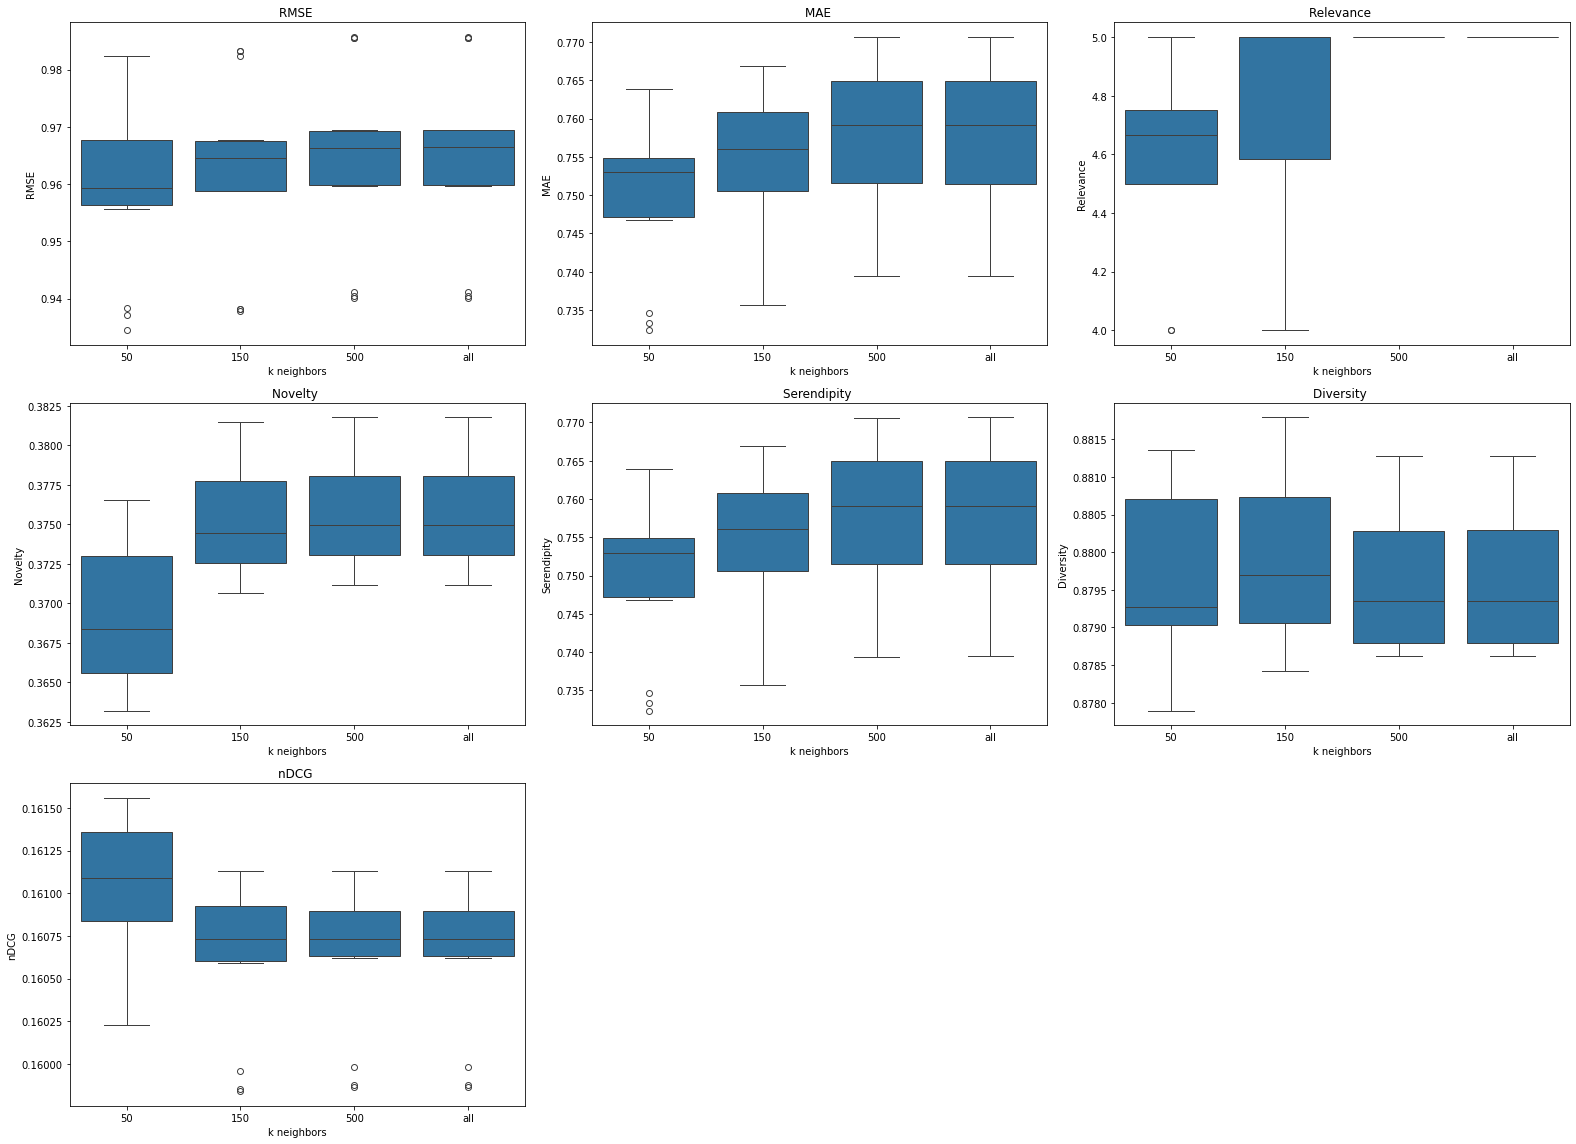

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


In [7]:
results_table

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG,k_neighbors,Beta,Model,Similarity
0,0.959947,0.751130,0.374388,4.696190,0.751130,0.879171,0.161169,50,30,Memory-based CF,Discounted Pearson
1,0.962873,0.755141,0.379023,4.700000,0.755141,0.879135,0.160766,150,30,Memory-based CF,Discounted Pearson
2,0.965221,0.758606,0.379331,5.000000,0.758606,0.879049,0.160752,500,30,Memory-based CF,Discounted Pearson
3,0.965237,0.758631,0.379331,5.000000,0.758631,0.879057,0.160752,all,30,Memory-based CF,Discounted Pearson
4,0.960841,0.749947,0.367269,4.558333,0.749947,0.879859,0.160932,50,100,Memory-based CF,Discounted Pearson
5,0.962315,0.753349,0.374121,4.733333,0.753349,0.880324,0.160618,150,100,Memory-based CF,Discounted Pearson
6,0.964069,0.756378,0.374631,5.000000,0.756378,0.879892,0.160613,500,100,Memory-based CF,Discounted Pearson
7,0.964082,0.756396,0.374631,5.000000,0.756396,0.879896,0.160613,all,100,Memory-based CF,Discounted Pearson
8,0.960901,0.749838,0.365293,4.558333,0.749838,0.879941,0.160899,50,300,Memory-based CF,Discounted Pearson
9,0.962288,0.753170,0.372393,4.733333,0.753170,0.880274,0.160597,150,300,Memory-based CF,Discounted Pearson


### <font color="blue">3.1.2 **Collaborative Filtering:** iten Neighborhood models</font>

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Configuración
k_values = [20, 50, 150, None]
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

def predict_user_row(u, R_train, item_similarity, item_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [i for i in range(num_items) if not np.isnan(R_train[u, i]) and i != j]
            if not neighbors:
                predictions[j] = item_means[j]
                continue
            sims = [(i, item_similarity[j, i]) for i in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[u, i] - item_means[i]) for i, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = item_means[j] if denom == 0 else item_means[j] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        item_means = np.array([
            np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0
            for j in range(num_items)
        ])

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        print("🔮 Prediciendo ratings en paralelo...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_row)(u, R_train, item_similarity, item_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        novelty_list, relevance_list = [], []
        for u in range(num_users):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                continue
            top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_list.append(np.mean([item_popularity_inv[j] for j in top_items]))
            rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(rels):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

        def ndcg(u):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
            dcg_score = dcg(rel_pred)
            ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
            idcg = dcg(ideal)
            return dcg_score / idcg if idcg > 0 else 0

        ndcg_scores = [ndcg(u) for u in range(num_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        ndcg = np.mean(ndcg_scores)

        fold_result = {
            "Model": "Item-based CF",
            "Similarity": "Cosine",
            "k_neighbors": "all" if k is None else k,
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG": ndcg
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Item-based CF",
        "Similarity": "Cosine",
        "k_neighbors": "all" if k is None else k
    })
    final_results.append(avg_metrics)

# 📊 Resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[["k_neighbors", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG"]])




🔁 Ejecutando 5-Fold CV para k = 20

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:22<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:17<00:00,  1.10s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:21<00:00,  1.10s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:22<00:00,  1.11s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:24<00:00,  1.11s/it]



🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:25<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:31<00:00,  1.12s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:29<00:00,  1.11s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:30<00:00,  1.11s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:23<00:00,  1.11s/it]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:30<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:34<00:00,  1.12s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:44<00:00,  1.13s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:44<00:00,  1.13s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:45<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:49<00:00,  1.13s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:50<00:00,  1.14s/it]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          20  0.948819  0.744231   4.515879  0.289944     0.744231   
1          50  0.958656  0.753759   4.560156  0.296461     0.753759   
2         150  0.965858  0.760148   4.518901  0.298668     0.760148   
3         all  0.967121  0.761174   4.456166  0.299059     0.761174   

   Diversity      nDCG  
0   0.943992  0.031502  
1   0.938105  0.031487  
2   0.935128  0.031512  
3   0.934964  0.031516  


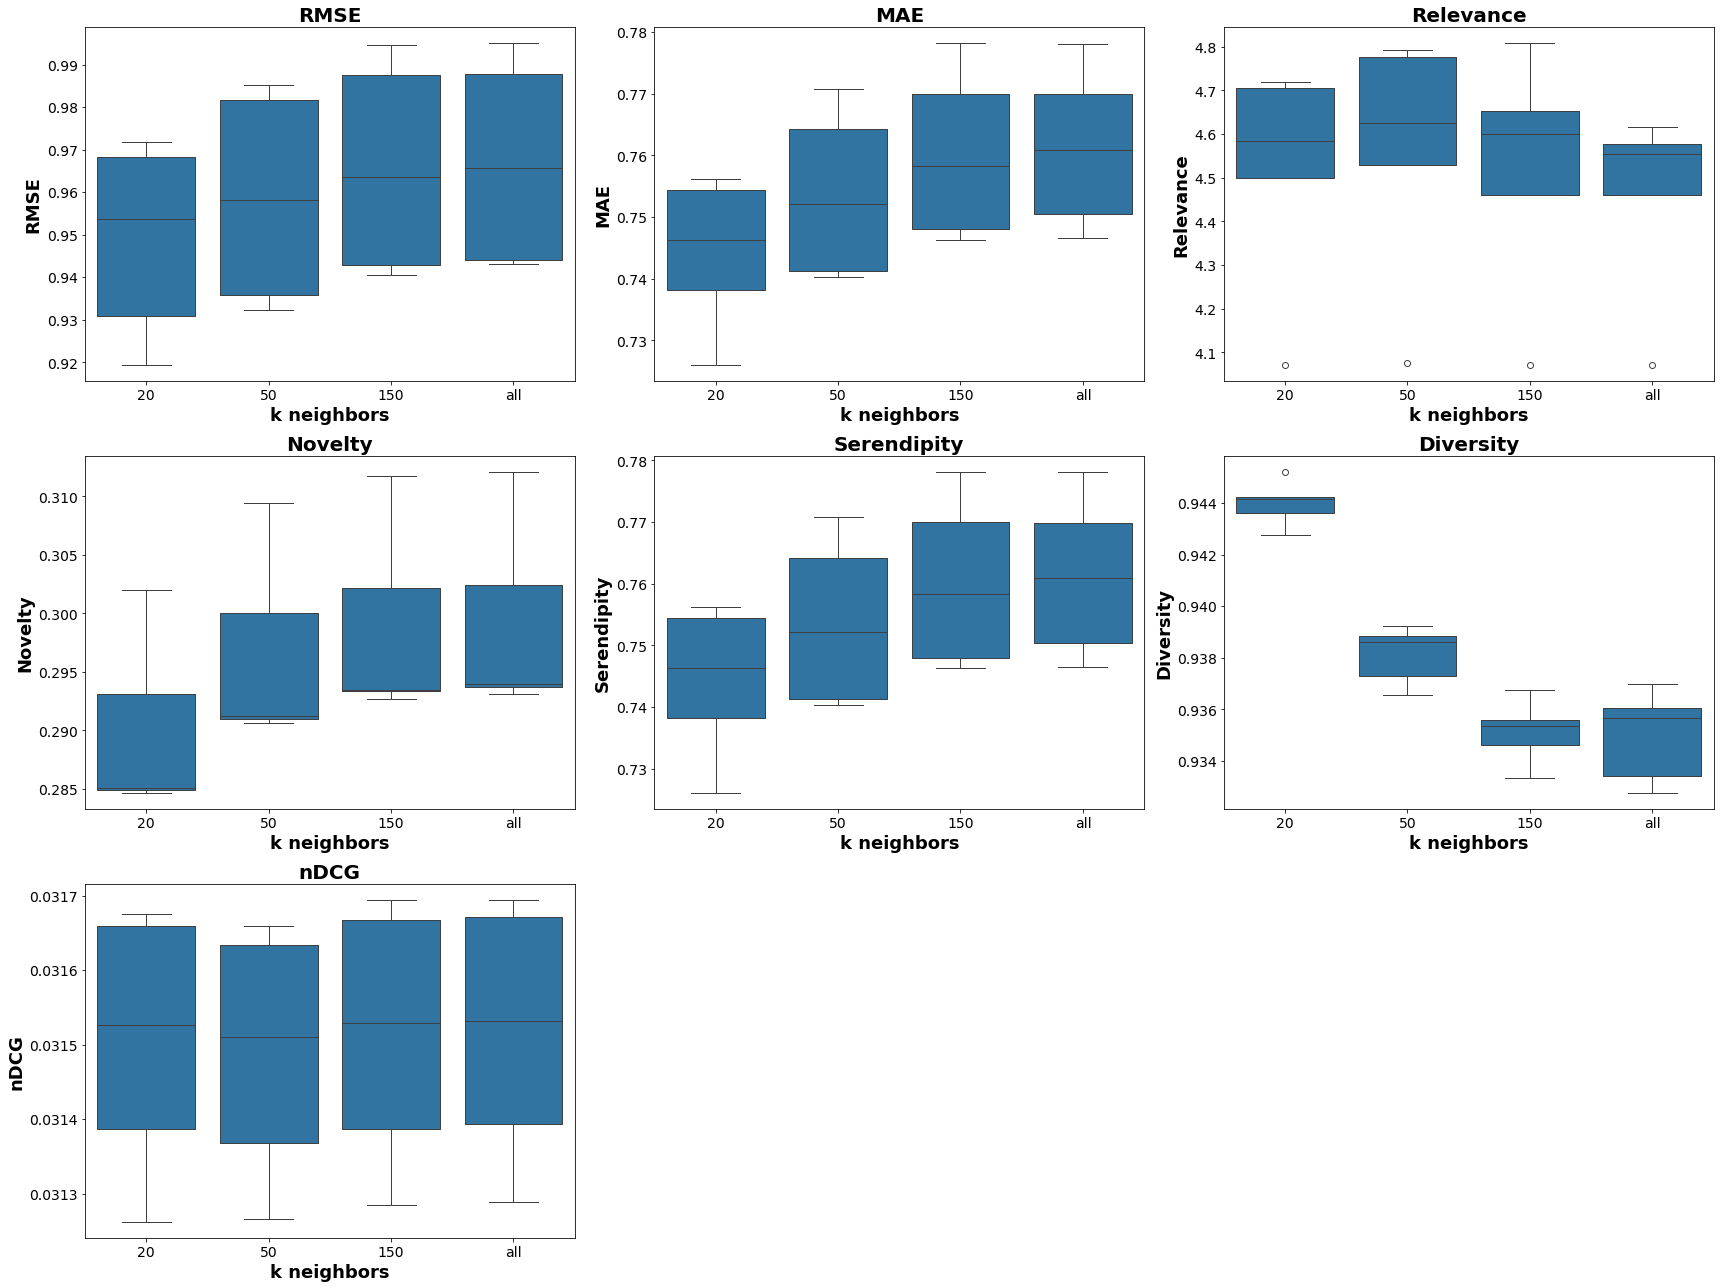

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()




In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Configuración
k_values = [20, 50, 150, None]
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

def compute_adjusted_cosine_similarity(R_train):
    num_users, num_items = R_train.shape
    user_means = np.array([np.nanmean(R_train[u, :]) if np.any(~np.isnan(R_train[u, :])) else 0 for u in range(num_users)])
    R_train_centered = np.copy(R_train)
    for u in range(num_users):
        for j in range(num_items):
            if not np.isnan(R_train[u, j]):
                R_train_centered[u, j] -= user_means[u]
            else:
                R_train_centered[u, j] = 0
    return cosine_similarity(R_train_centered.T)

def predict_user_row(u, R_train, item_similarity, item_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [i for i in range(num_items) if not np.isnan(R_train[u, i]) and i != j]
            if not neighbors:
                predictions[j] = item_means[j]
                continue
            sims = [(i, item_similarity[j, i]) for i in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[u, i] - item_means[i]) for i, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = item_means[j] if denom == 0 else item_means[j] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        item_means = np.array([
            np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0
            for j in range(num_items)
        ])

        # Calcular adjusted cosine similarity
        item_similarity = compute_adjusted_cosine_similarity(R_train)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        print("🔮 Prediciendo ratings en paralelo...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_row)(u, R_train, item_similarity, item_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        novelty_list, relevance_list = [], []
        for u in range(num_users):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                continue
            top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_list.append(np.mean([item_popularity_inv[j] for j in top_items]))
            rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(rels):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

        def ndcg(u):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
            dcg_score = dcg(rel_pred)
            ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
            idcg = dcg(ideal)
            return dcg_score / idcg if idcg > 0 else 0

        ndcg_scores = [ndcg(u) for u in range(num_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        ndcg = np.mean(ndcg_scores)

        fold_result = {
            "Model": "Item-based CF",
            "Similarity": "Adjusted Cosine",
            "k_neighbors": "all" if k is None else k,
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG": ndcg
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Item-based CF",
        "Similarity": "Adjusted Cosine",
        "k_neighbors": "all" if k is None else k
    })
    final_results.append(avg_metrics)

# 📊 Resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[["k_neighbors", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG"]])



🔁 Ejecutando 5-Fold CV para k = 20

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:24<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:24<00:00,  1.11s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:23<00:00,  1.11s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:23<00:00,  1.11s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:29<00:00,  1.11s/it]



🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:32<00:00,  1.12s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:30<00:00,  1.11s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:26<00:00,  1.11s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:31<00:00,  1.12s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:32<00:00,  1.12s/it]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:46<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:46<00:00,  1.13s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:34<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:41<00:00,  1.13s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:42<00:00,  1.13s/it]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:47<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:41<00:00,  1.13s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:02<00:00,  1.15s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:45<00:00,  1.13s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          20  0.978728  0.774440   4.656581  0.282086     0.774440   
1          50  0.984782  0.780490   4.623106  0.294659     0.780490   
2         150  0.989426  0.785626   4.596007  0.298344     0.785626   
3         all  0.990120  0.786411   4.585082  0.298510     0.786411   

   Diversity      nDCG  
0   0.988667  0.031582  
1   0.988580  0.031541  
2   0.989259  0.031516  
3   0.989134  0.031515  


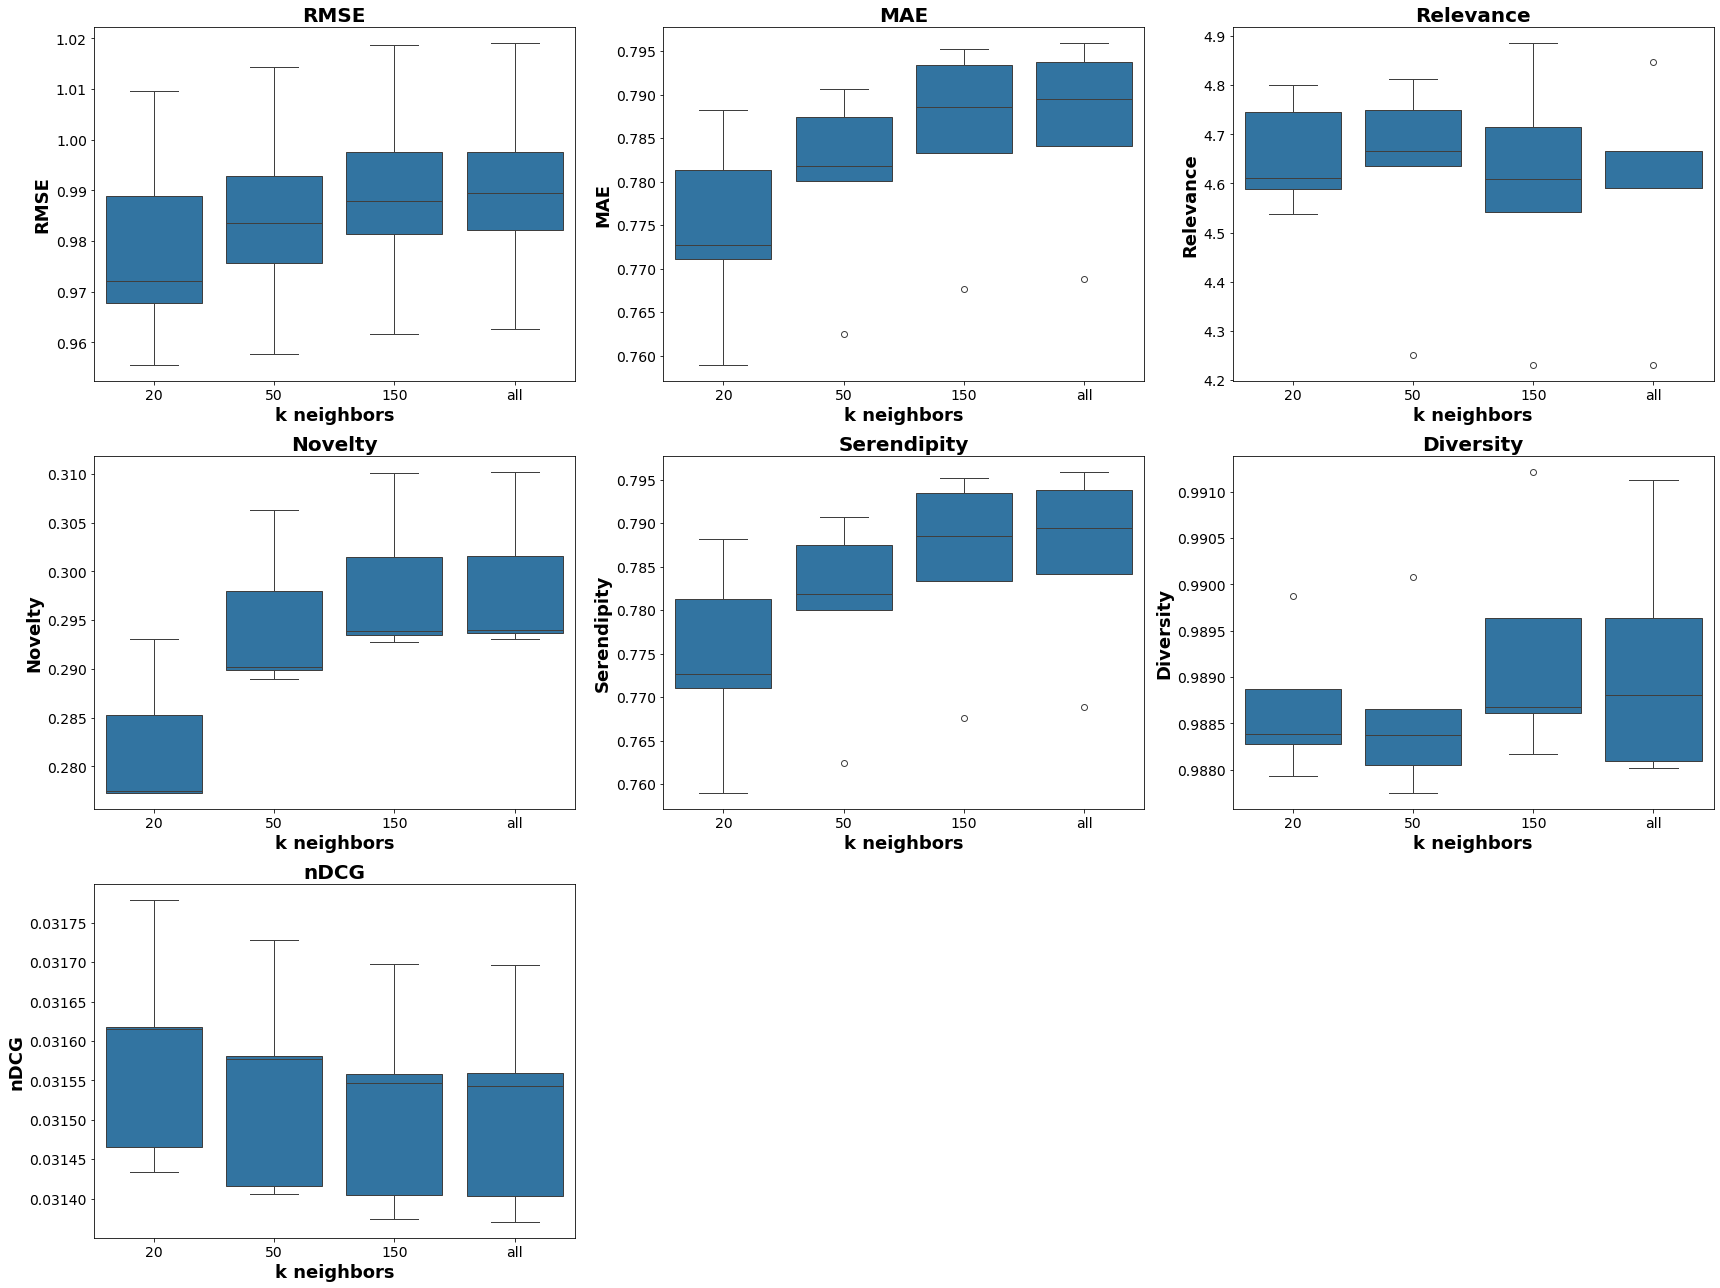

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### <font color="blue">3.2 **Collaborative Filtering:** Latent Factor Models (Matrix Factorization)</font>

In [32]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from math import sqrt

# ========== MATRICES ORIGINALES ==========
R_original = ratings_matrix.values

# ========== HIPERPARÁMETROS ==========
k_values = [3, 5, 10, 20]
alpha_values = [0.001, 0.005]
lambda_values = [0.01, 0.05]

final_results = []
all_folds_metrics = []  # Para resultados por fold

# ========== FUNCIÓN DE FACTORIZACIÓN ==========
def matrix_factorization(R, k, steps, alpha, lambda_reg):
    m, n = R.shape
    U = np.random.randn(m, k) * 0.01
    V = np.random.randn(n, k) * 0.01

    for step in tqdm(range(steps), desc=f"🔧 k={k} α={alpha} λ={lambda_reg}", leave=False):
        for i in range(m):
            for j in range(n):
                if np.isnan(R[i, j]):
                    continue
                pred = np.dot(U[i], V[j])
                err = R[i, j] - pred
                for r in range(k):
                    U[i, r] += alpha * (err * V[j, r] - lambda_reg * U[i, r])
                    V[j, r] += alpha * (err * U[i, r] - lambda_reg * V[j, r])
    return U, V

# ========== FUNCIONES AUXILIARES ==========
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

def ndcg_at_k(u, R_pred, R_train, R_test, k="all"):
    known_train_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_train_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
    top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
    dcg_score = dcg(rel_pred)
    actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
    if not actual_ratings:
        return np.nan
    actual_ratings.sort(key=lambda x: x[1], reverse=True)
    ideal_rel = [r for _, r in actual_ratings[:k_val]]
    ideal_dcg = dcg(ideal_rel)
    return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

# ========== CROSS VALIDATION ==========
for k in k_values:
    for alpha in alpha_values:
        for lambda_reg in lambda_values:
            print(f"\n🔁 Ejecutando 5-Fold CV para k={k}, alpha={alpha}, lambda={lambda_reg}")
            fold_metrics = []

            for fold_num, (train_matrix, test_matrix) in enumerate(folds):
                print(f"\n▶️ Fold {fold_num + 1}")
                R_train = train_matrix.values
                R_test = test_matrix.values
                test_mask = ~np.isnan(R_test)
                test_indices = list(zip(*np.where(test_mask)))

                start_time = time.time()
                U, V = matrix_factorization(R_train, k=k, steps=100, alpha=alpha, lambda_reg=lambda_reg)
                end_time = time.time()
                training_time = end_time - start_time

                R_pred = np.dot(U, V.T)

                # ===== MÉTRICAS BÁSICAS =====
                actual = [R_original[i, j] for i, j in test_indices]
                predicted = [R_pred[i, j] for i, j in test_indices]
                rmse = sqrt(mean_squared_error(actual, predicted))
                mae = mean_absolute_error(actual, predicted)

                # ===== MÉTRICAS ADICIONALES =====
                item_popularity = np.nansum(~np.isnan(R_train), axis=0)
                item_popularity_inv = 1 / (item_popularity + 1e-10)

                novelty_list = []
                relevance_list = []

                for u in range(R_train.shape[0]):
                    known_train_items = ~np.isnan(R_train[u])
                    unknown_items = np.where(~known_train_items)[0]
                    if len(unknown_items) == 0:
                        continue
                    user_preds = R_pred[u, unknown_items]
                    top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]
                    novelty_u = np.mean(item_popularity_inv[top_20_idx])
                    novelty_list.append(novelty_u)
                    rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                    if rel_ratings:
                        relevance_list.append(np.mean(rel_ratings))

                novelty = np.mean(novelty_list) if novelty_list else np.nan
                relevance = np.mean(relevance_list) if relevance_list else np.nan

                # === SERENDIPITY ===
                serendipity_scores = [abs(R_pred[u, j] - R_test[u, j])
                                      for u, j in zip(*np.where(test_mask))
                                      if np.isnan(R_train[u, j])]
                serendipity = np.mean(serendipity_scores) if serendipity_scores else np.nan

                # === DIVERSITY ===
                R_train_filled = np.nan_to_num(R_train)
                item_similarity = cosine_similarity(R_train_filled.T)

                diversity_scores = []
                for u in range(R_train.shape[0]):
                    top_5_items = np.argsort(R_pred[u, :])[-5:]
                    count = 0
                    diversity = 0
                    for i in range(len(top_5_items)):
                        for j2 in range(i + 1, len(top_5_items)):
                            diversity += 1 - item_similarity[top_5_items[i], top_5_items[j2]]
                            count += 1
                    diversity_scores.append(diversity / count if count > 0 else 0)

                diversity = np.mean(diversity_scores)

                # === NDCG ===
                ndcg_list = [ndcg_at_k(u, R_pred, R_train, R_test, k="all") for u in range(R_train.shape[0])]
                ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
                ndcg_score = np.mean(ndcg_list)

                fold_result = {
                    "Latent Factors (k)": k,
                    "Alpha": alpha,
                    "Lambda": lambda_reg,
                    "Training Time (s)": training_time,
                    "RMSE": rmse,
                    "MAE": mae,
                    "Diversity": diversity,
                    "Novelty": novelty,
                    "Serendipity": serendipity,
                    "Relevance": relevance,
                    "nDCG": ndcg_score
                }

                fold_metrics.append(fold_result)
                all_folds_metrics.append(fold_result)

            avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
            avg_metrics.update({
                "Latent Factors (k)": k,
                "Alpha": alpha,
                "Lambda": lambda_reg
            })
            final_results.append(avg_metrics)

# ========== MOSTRAR RESULTADOS ==========
results_df = pd.DataFrame(final_results)
print("\n✅ Resultados promedio por configuración:")
display(results_df.sort_values(by="RMSE"))



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



✅ Resultados promedio por configuración:


,Latent Factors (k),Alpha,Lambda,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
11,10,0.005,0.05,428.847643,0.945835,0.743107,0.785085,0.111864,0.743107,4.429198,0.157478
7,5,0.005,0.05,349.862565,0.947288,0.745185,0.837570,0.131713,0.745185,4.386640,0.157472
15,20,0.005,0.05,590.742633,0.947566,0.743560,0.750491,0.095866,0.743560,4.359268,0.157611
3,3,0.005,0.05,304.617994,0.951739,0.749355,0.877726,0.148358,0.749355,4.444125,0.157771
6,5,0.005,0.01,350.246834,0.957878,0.751274,0.773987,0.092571,0.751274,4.349299,0.157998
2,3,0.005,0.01,303.005893,0.962456,0.749349,0.831873,0.123783,0.749349,4.314156,0.157773
10,10,0.005,0.01,428.604063,0.970792,0.754847,0.731705,0.057904,0.754847,4.275594,0.158301
12,20,0.001,0.01,587.872929,0.979228,0.770617,0.685509,0.014958,0.770617,4.382200,0.155821
8,10,0.001,0.01,430.621336,0.983990,0.774523,0.701506,0.015284,0.774523,4.335435,0.156237
13,20,0.001,0.05,590.597022,0.988393,0.781164,0.704810,0.015011,0.781164,4.324242,0.155887


In [33]:
results_df

,Latent Factors (k),Alpha,Lambda,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
0,3,0.001,0.01,303.558896,0.989285,0.778985,0.710056,0.015344,0.778985,4.323190,0.156059
1,3,0.001,0.05,303.768418,0.993907,0.785666,0.641474,0.015129,0.785666,4.303327,0.155989
2,3,0.005,0.01,303.005893,0.962456,0.749349,0.831873,0.123783,0.749349,4.314156,0.157773
3,3,0.005,0.05,304.617994,0.951739,0.749355,0.877726,0.148358,0.749355,4.444125,0.157771
4,5,0.001,0.01,350.709952,0.988461,0.777952,0.712378,0.015335,0.777952,4.347435,0.156206
5,5,0.001,0.05,350.676516,0.992729,0.784748,0.671901,0.015072,0.784748,4.285515,0.155981
6,5,0.005,0.01,350.246834,0.957878,0.751274,0.773987,0.092571,0.751274,4.349299,0.157998
7,5,0.005,0.05,349.862565,0.947288,0.745185,0.837570,0.131713,0.745185,4.386640,0.157472
8,10,0.001,0.01,430.621336,0.983990,0.774523,0.701506,0.015284,0.774523,4.335435,0.156237
9,10,0.001,0.05,429.109327,0.991128,0.783424,0.711016,0.015103,0.783424,4.322250,0.156118


In [34]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from math import sqrt

# ========== MATRIZ ORIGINAL ==========
R_original = ratings_matrix.values

# ========== HIPERPARÁMETROS ==========
k_values = [3, 5, 10, 20]
alpha_values = [0.01]
enforce_every = 10
steps = 100

final_results = []
all_folds_metrics = []

# ========== FUNCIÓN SVD ORTOGONAL ==========
def train_orthogonal_svd(R, train_indices, k=3, steps=100, alpha=0.01, enforce_every=10):
    m, n = R.shape
    U = np.random.rand(m, k)
    V = np.random.rand(n, k)
    for step in range(steps):
        for (i, j) in train_indices:
            eij = R[i, j] - np.dot(U[i, :], V[j, :])
            U[i, :] += alpha * eij * V[j, :]
            V[j, :] += alpha * eij * U[i, :]
        if step % enforce_every == 0:
            U, _ = np.linalg.qr(U)
            V, _ = np.linalg.qr(V)
    return U, V

# ========== FUNCIONES AUXILIARES ==========
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

def ndcg_at_k(u, R_pred, R_train, R_test, k="all"):
    known_train_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_train_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
    top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
    dcg_score = dcg(rel_pred)
    actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
    if not actual_ratings:
        return np.nan
    actual_ratings.sort(key=lambda x: x[1], reverse=True)
    ideal_rel = [r for _, r in actual_ratings[:k_val]]
    ideal_dcg = dcg(ideal_rel)
    return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

# ========== CROSS-VALIDATION ==========
for k in k_values:
    for alpha in alpha_values:
        print(f"\n🔁 Ejecutando 5-Fold CV para k={k}, alpha={alpha}")
        fold_metrics = []

        for fold_num, (train_matrix, test_matrix) in enumerate(folds):
            print(f"\n▶️ Fold {fold_num + 1}")
            R_train = train_matrix.values
            R_test = test_matrix.values
            test_indices = list(zip(*np.where(~np.isnan(R_test))))
            train_indices = list(zip(*np.where(~np.isnan(R_train))))

            start_time = time.time()
            U, V = train_orthogonal_svd(R_train, train_indices, k=k, steps=steps, alpha=alpha, enforce_every=enforce_every)
            end_time = time.time()

            R_pred = np.dot(U, V.T)

            # ===== MÉTRICAS BÁSICAS =====
            actual = [R_original[i, j] for i, j in test_indices]
            predicted = [R_pred[i, j] for i, j in test_indices]
            rmse = sqrt(mean_squared_error(actual, predicted))
            mae = mean_absolute_error(actual, predicted)

            # ===== MÉTRICAS ADICIONALES =====
            item_popularity = np.nansum(~np.isnan(R_train), axis=0)
            item_popularity_inv = 1 / (item_popularity + 1e-10)

            novelty_list, relevance_list = [], []

            for u in range(R_train.shape[0]):
                unknown_items = np.where(np.isnan(R_train[u]))[0]
                if len(unknown_items) == 0:
                    continue
                top_20_idx = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
                novelty_list.append(np.mean(item_popularity_inv[top_20_idx]))
                rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                if rel_ratings:
                    relevance_list.append(np.mean(rel_ratings))

            novelty = np.mean(novelty_list) if novelty_list else np.nan
            relevance = np.mean(relevance_list) if relevance_list else np.nan

            serendipity_scores = [abs(R_pred[u, j] - R_test[u, j])
                                  for u, j in test_indices if np.isnan(R_train[u, j])]
            serendipity = np.mean(serendipity_scores) if serendipity_scores else np.nan

            item_similarity = cosine_similarity(np.nan_to_num(R_train).T)
            diversity_scores = []
            for u in range(R_train.shape[0]):
                top_5 = np.argsort(R_pred[u])[-5:]
                pairs = [(i, j) for i in top_5 for j in top_5 if i < j]
                if not pairs:
                    continue
                div = np.mean([1 - item_similarity[i, j] for i, j in pairs])
                diversity_scores.append(div)

            diversity = np.mean(diversity_scores)

            ndcg_list = [ndcg_at_k(u, R_pred, R_train, R_test) for u in range(R_train.shape[0])]
            ndcg_score = np.nanmean(ndcg_list)

            fold_result = {
                "Latent Factors (k)": k,
                "Alpha": alpha,
                "Training Time (s)": end_time - start_time,
                "RMSE": rmse,
                "MAE": mae,
                "Diversity": diversity,
                "Novelty": novelty,
                "Serendipity": serendipity,
                "Relevance": relevance,
                "nDCG": ndcg_score
            }

            fold_metrics.append(fold_result)
            all_folds_metrics.append(fold_result)

        avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
        avg_metrics.update({
            "Latent Factors (k)": k,
            "Alpha": alpha
        })
        final_results.append(avg_metrics)

# ========== MOSTRAR RESULTADOS ==========
results_df = pd.DataFrame(final_results)
print("\n✅ Resultados promedio por configuración:")
display(results_df.sort_values(by="RMSE"))



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.01

▶️ Fold 1

▶️ Fold 2

▶️ Fold 3

▶️ Fold 4

▶️ Fold 5

🔁 Ejecutando 5-Fold CV para k=5, alpha=0.01

▶️ Fold 1

▶️ Fold 2

▶️ Fold 3

▶️ Fold 4

▶️ Fold 5

🔁 Ejecutando 5-Fold CV para k=10, alpha=0.01

▶️ Fold 1

▶️ Fold 2

▶️ Fold 3

▶️ Fold 4

▶️ Fold 5

🔁 Ejecutando 5-Fold CV para k=20, alpha=0.01

▶️ Fold 1

▶️ Fold 2

▶️ Fold 3

▶️ Fold 4

▶️ Fold 5

✅ Resultados promedio por configuración:


,Latent Factors (k),Alpha,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
2,10,0.01,106.928343,0.970393,0.763075,0.577318,0.012033,0.763075,4.299284,0.155217
3,20,0.01,108.028470,0.972420,0.763705,0.576158,0.011391,0.763705,4.272376,0.155057
1,5,0.01,107.773004,0.974918,0.768210,0.580818,0.013029,0.768210,4.352664,0.155521
0,3,0.01,107.232322,0.987047,0.776574,0.577721,0.014033,0.776574,4.327964,0.155750


In [35]:
results_df

,Latent Factors (k),Alpha,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
0,3,0.01,107.232322,0.987047,0.776574,0.577721,0.014033,0.776574,4.327964,0.155750
1,5,0.01,107.773004,0.974918,0.768210,0.580818,0.013029,0.768210,4.352664,0.155521
2,10,0.01,106.928343,0.970393,0.763075,0.577318,0.012033,0.763075,4.299284,0.155217
3,20,0.01,108.028470,0.972420,0.763705,0.576158,0.011391,0.763705,4.272376,0.155057


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import time
from sklearn.metrics.pairwise import cosine_similarity

def svd_iterative_fill(R, k=3, steps=20):
    R = R.copy()
    user_means = np.nanmean(R, axis=1)
    R_centered = R - user_means[:, np.newaxis]
    R_centered[np.isnan(R_centered)] = 0

    for _ in range(steps):
        U, S, Vt = np.linalg.svd(R_centered, full_matrices=False)
        S = np.diag(S[:k])
        U = U[:, :k]
        Vt = Vt[:k, :]
        R_hat = U @ S @ Vt
        R_centered[np.isnan(R)] = R_hat[np.isnan(R)]

    R_final = R_centered + user_means[:, np.newaxis]
    return R_final

# Funciones para métricas adicionales
def dcg(rels):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

def ndcg(u, R_train, R_pred, R_test):
    known_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    # ordenamos todos los desconocidos por predicción (toma todo, no top-K)
    top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[::-1]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
    dcg_score = dcg(rel_pred)
    ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
    idcg = dcg(ideal)
    return dcg_score / idcg if idcg > 0 else 0

results = []
# Valores a probar
k_values = [3, 5, 10]
step_values = [20, 50, 100]

results = []

for k in k_values:
    for steps in step_values:
        print(f"\n🔁 Ejecutando SVD iterativo con k={k}, steps={steps}")
        rmse_list, mae_list = [], []
        novelty_list, relevance_list, serendipity_list, diversity_list, ndcg_list = [], [], [], [], []

        for fold_num, (train_matrix, test_matrix) in enumerate(folds):
            print(f"▶️ Fold {fold_num + 1}")
            R_train = train_matrix.values
            R_test = test_matrix.values
            test_mask = ~np.isnan(R_test)
            test_indices = list(zip(*np.where(test_mask)))
            n_users, n_items = R_train.shape

            start_time = time.time()
            R_pred = svd_iterative_fill(R_train, k=k, steps=steps)
            end_time = time.time()

            actual = [R_test[i, j] for i, j in test_indices]
            predicted = [R_pred[i, j] for i, j in test_indices]
            rmse = sqrt(mean_squared_error(actual, predicted))
            mae = mean_absolute_error(actual, predicted)

            item_popularity = np.sum(~np.isnan(R_train), axis=0)
            item_popularity_inv = 1 / (item_popularity + 1)

            novelty_fold, relevance_fold, serendipity_fold, ndcg_fold = [], [], [], []
            R_train_filled = np.nan_to_num(R_train)
            item_similarity = cosine_similarity(R_train_filled.T)
            diversity_fold = []

            for u in range(n_users):
                known_train_items = ~np.isnan(R_train[u])
                unknown_items = np.where(~known_train_items)[0]
                if len(unknown_items) == 0:
                    continue

                user_preds = R_pred[u, unknown_items]
                top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]

                novelty_u = np.mean(item_popularity_inv[top_20_idx])
                novelty_fold.append(novelty_u)

                rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                if rel_ratings:
                    relevance_fold.append(np.mean(rel_ratings))

                ser_scores = [abs(R_pred[u, j] - R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
                if ser_scores:
                    serendipity_fold.append(np.mean(ser_scores))

                ndcg_u = ndcg(u, R_train, R_pred, R_test)
                if not np.isnan(ndcg_u):
                    ndcg_fold.append(ndcg_u)

                top_5_items = np.argsort(R_pred[u, :])[-5:]
                count, diversity = 0, 0
                for i1 in range(len(top_5_items)):
                    for i2 in range(i1 + 1, len(top_5_items)):
                        diversity += 1 - item_similarity[top_5_items[i1], top_5_items[i2]]
                        count += 1
                diversity_fold.append(diversity / count if count > 0 else 0)

            rmse_list.append(rmse)
            mae_list.append(mae)
            novelty_list.append(np.mean(novelty_fold) if novelty_fold else np.nan)
            relevance_list.append(np.mean(relevance_fold) if relevance_fold else np.nan)
            serendipity_list.append(np.mean(serendipity_fold) if serendipity_fold else np.nan)
            diversity_list.append(np.mean(diversity_fold) if diversity_fold else np.nan)
            ndcg_list.append(np.mean(ndcg_fold) if ndcg_fold else np.nan)

            print(f"  Fold RMSE: {rmse:.4f}, MAE: {mae:.4f}, Time: {end_time - start_time:.2f}s")

        results.append({
            "Latent Factors (k)": k,
            "Steps": steps,
            "Avg RMSE": np.mean(rmse_list),
            "Avg MAE": np.mean(mae_list),
            "Avg Novelty": np.mean(novelty_list),
            "Avg Relevance": np.mean(relevance_list),
            "Avg Serendipity": np.mean(serendipity_list),
            "Avg Diversity": np.mean(diversity_list),
            "Avg nDCG": np.mean(ndcg_list)
        })

results_df = pd.DataFrame(results)
print("\n✅ Resultados promedio por configuración:")
print(results_df.sort_values(by=["Latent Factors (k)", "Steps"]))



🔁 Ejecutando SVD iterativo con k=3, steps=20
▶️ Fold 1
  Fold RMSE: 0.9616, MAE: 0.7609, Time: 13.52s
▶️ Fold 2
  Fold RMSE: 0.9903, MAE: 0.7662, Time: 13.70s
▶️ Fold 3
  Fold RMSE: 0.9254, MAE: 0.7239, Time: 13.37s
▶️ Fold 4
  Fold RMSE: 0.9690, MAE: 0.7712, Time: 14.05s
▶️ Fold 5
  Fold RMSE: 0.9666, MAE: 0.7530, Time: 14.00s

🔁 Ejecutando SVD iterativo con k=3, steps=50
▶️ Fold 1
  Fold RMSE: 0.9549, MAE: 0.7504, Time: 35.18s
▶️ Fold 2
  Fold RMSE: 0.9835, MAE: 0.7607, Time: 34.03s
▶️ Fold 3
  Fold RMSE: 0.9165, MAE: 0.7179, Time: 33.74s
▶️ Fold 4
  Fold RMSE: 0.9581, MAE: 0.7607, Time: 34.37s
▶️ Fold 5
  Fold RMSE: 0.9558, MAE: 0.7450, Time: 33.79s

🔁 Ejecutando SVD iterativo con k=3, steps=100
▶️ Fold 1
  Fold RMSE: 0.9572, MAE: 0.7482, Time: 68.24s
▶️ Fold 2
  Fold RMSE: 0.9824, MAE: 0.7609, Time: 68.38s
▶️ Fold 3
  Fold RMSE: 0.9161, MAE: 0.7166, Time: 64.12s
▶️ Fold 4
  Fold RMSE: 0.9559, MAE: 0.7583, Time: 67.72s
▶️ Fold 5
  Fold RMSE: 0.9566, MAE: 0.7441, Time: 67.55s

🔁 Eje

In [6]:
results_df

,Latent Factors (k),Steps,Avg RMSE,Avg MAE,Avg Novelty,Avg Relevance,Avg Serendipity,Avg Diversity,Avg nDCG
0,3,20,0.962580,0.755019,0.009064,4.262033,0.755019,0.634892,0.049641
1,3,50,0.953750,0.746950,0.017649,4.297908,0.746950,0.641736,0.047435
2,3,100,0.953626,0.745610,0.034222,4.343702,0.745610,0.659284,0.045527
3,5,20,0.960500,0.751614,0.010272,4.232774,0.751614,0.636584,0.051467
4,5,50,0.960617,0.751116,0.019374,4.272733,0.751116,0.662392,0.047343
5,5,100,0.969631,0.757256,0.035336,4.294977,0.757256,0.704384,0.044646
6,10,20,0.967369,0.755838,0.012664,4.239087,0.755838,0.652293,0.051218
7,10,50,0.989682,0.770829,0.021749,4.222957,0.770829,0.713582,0.046370
8,10,100,1.018720,0.788380,0.032175,4.215005,0.788380,0.780558,0.043349


#### <font color="blue"> **Random Forest**</font>

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, log2
from tqdm import tqdm
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import random

# Función DCG y nDCG personalizada (como pediste)
def dcg(rels):
    return sum(rel / log2(idx + 2) for idx, rel in enumerate(rels))

def ndcg_u(u, R_train, R_test, R_pred):
    known_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
    dcg_score = dcg(rel_pred)
    ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
    idcg = dcg(ideal)
    return dcg_score / idcg if idcg > 0 else 0

# ratings_matrix debe estar definido antes (usuarios x items con NaNs)
user_ids = ratings_matrix.index.tolist()
user_indices = np.arange(len(user_ids))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.5]
}

results = []

for n_est, depth, lr in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['learning_rate']):
    print(f"\nParámetros: n_estimators={n_est}, max_depth={depth}, learning_rate={lr}")
    
    fold_rmses = []
    fold_maes = []
    fold_novelties = []
    fold_relevances = []
    fold_serendipities = []
    fold_diversities = []
    fold_ndcgs = []

    for fold_num, (train_user_idx, test_user_idx) in enumerate(kf.split(user_indices)):
        print(f" Fold {fold_num + 1}")

        train_users = [user_ids[i] for i in train_user_idx]
        test_users = [user_ids[i] for i in test_user_idx]

        train_matrix = ratings_matrix.copy()
        test_matrix = pd.DataFrame(np.nan, index=ratings_matrix.index, columns=ratings_matrix.columns)

        for user in test_users:
            user_ratings = ratings_matrix.loc[user].dropna()
            if len(user_ratings) >= 5:
                test_items = random.sample(list(user_ratings.index), 5)
                for item in test_items:
                    test_matrix.at[user, item] = ratings_matrix.at[user, item]
                    train_matrix.at[user, item] = np.nan

        R_train = train_matrix.values
        R_test = test_matrix.values
        n_users, n_items = R_train.shape

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_pred = np.full(R_train.shape, np.nan)

        for item_idx in tqdm(range(n_items), desc=f"Items XGBoost Fold {fold_num + 1}"):
            y = R_train[:, item_idx]
            X = np.delete(R_train, item_idx, axis=1)

            train_mask = ~np.isnan(y)
            if np.sum(train_mask) < 1:
                fill_value = np.nanmean(y) if np.sum(train_mask) > 0 else np.nanmean(R_train)
                R_pred[:, item_idx] = fill_value
                continue

            X_train = X[train_mask]
            y_train = y[train_mask]

            model = XGBRegressor(n_estimators=n_est, max_depth=depth,
                                 learning_rate=lr, random_state=42, n_jobs=-1, verbosity=0)
            model.fit(X_train, y_train)
            R_pred[:, item_idx] = model.predict(X)

        # Métricas tradicionales
        test_mask = ~np.isnan(R_test)
        predicted = R_pred[test_mask]
        actual = R_test[test_mask]

        valid_mask = ~np.isnan(predicted)
        predicted = predicted[valid_mask]
        actual = actual[valid_mask]

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        fold_rmses.append(rmse)
        fold_maes.append(mae)

        novelty_list = []
        relevance_list = []

        for u in range(n_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue

            user_preds = R_pred[u, unknown_items]
            top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]

            novelty_u = np.mean(item_popularity_inv[top_20_idx])
            novelty_list.append(novelty_u)

            rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
            if rel_ratings:
                relevance_list.append(np.mean(rel_ratings))

        fold_novelties.append(np.mean(novelty_list) if novelty_list else np.nan)
        fold_relevances.append(np.mean(relevance_list) if relevance_list else np.nan)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j])
                              for u, j in zip(*np.where(test_mask))
                              if np.isnan(R_train[u, j])]
        fold_serendipities.append(np.mean(serendipity_scores) if serendipity_scores else np.nan)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        diversity_scores = []
        for u in range(n_users):
            top_5_items = np.argsort(R_pred[u, :])[-5:]
            count = 0
            diversity = 0
            for i in range(len(top_5_items)):
                for j2 in range(i + 1, len(top_5_items)):
                    diversity += 1 - item_similarity[top_5_items[i], top_5_items[j2]]
                    count += 1
            diversity_scores.append(diversity / count if count > 0 else 0)
        fold_diversities.append(np.mean(diversity_scores))

        # === nDCG como tú pediste ===
        ndcg_scores = [ndcg_u(u, R_train, R_test, R_pred) for u in range(n_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        fold_ndcgs.append(np.mean(ndcg_scores))

    results.append({
        "Model": "XGBoost per item with CV",
        "n_estimators": n_est,
        "max_depth": depth,
        "learning_rate": lr,
        "RMSE": np.mean(fold_rmses),
        "MAE": np.mean(fold_maes),
        "Novelty": np.mean(fold_novelties),
        "Relevance": np.mean(fold_relevances),
        "Serendipity": np.mean(fold_serendipities),
        "Diversity": np.mean(fold_diversities),
        "nDCG@all": np.mean(fold_ndcgs)
    })

results_df = pd.DataFrame(results)
print(results_df)




In [51]:
print("R_pred.shape:", R_pred.shape)
print("R_test.shape:", R_test.shape)
print("test_mask.shape:", test_mask.shape)
print("np.isnan(R_test).shape:", np.isnan(R_test).shape)


R_pred.shape: (754, 1682)
R_test.shape: (189, 1682)
test_mask.shape: (189, 1682)
np.isnan(R_test).shape: (189, 1682)


### <font color="blue">4 **Popularity Bias** U1R Bellungi Method</font>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

np.random.seed(1)

item_ids = ratings_matrix.columns.tolist()
item_indices = np.arange(len(item_ids))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []

num_test_ratings_per_item = 3  # Cambia aquí el número de ratings test por ítem

for fold_num, (train_item_idx, test_item_idx) in enumerate(kf.split(item_indices)):
    print(f"\n🔄 Fold {fold_num + 1} (Bellogin U1R, {num_test_ratings_per_item} ratings por ítem)")

    train_items = [item_ids[i] for i in train_item_idx]
    test_items = [item_ids[i] for i in test_item_idx]

    train_matrix = ratings_matrix.copy()
    test_matrix = pd.DataFrame(np.nan, index=ratings_matrix.index, columns=ratings_matrix.columns)

    for item in test_items:
        users_with_rating = ratings_matrix.index[ratings_matrix[item].notna()]
        if len(users_with_rating) == 0:
            continue
        # Si hay menos de 3 ratings, toma todos
        num_to_sample = min(num_test_ratings_per_item, len(users_with_rating))
        users_test = np.random.choice(users_with_rating, size=num_to_sample, replace=False)

        for user_test in users_test:
            test_matrix.at[user_test, item] = ratings_matrix.at[user_test, item]
            train_matrix.at[user_test, item] = np.nan

    train_ratings = np.count_nonzero(~np.isnan(train_matrix.values))
    test_ratings = np.count_nonzero(~np.isnan(test_matrix.values))
    # print(f"✅ Train ratings: {train_ratings}")
    print(f"✅ Test ratings: {test_ratings}")

    folds.append((train_matrix, test_matrix))




🔄 Fold 1 (Bellogin U1R, 3 ratings por ítem)
✅ Test ratings: 943

🔄 Fold 2 (Bellogin U1R, 3 ratings por ítem)
✅ Test ratings: 935

🔄 Fold 3 (Bellogin U1R, 3 ratings por ítem)
✅ Test ratings: 936

🔄 Fold 4 (Bellogin U1R, 3 ratings por ítem)
✅ Test ratings: 944

🔄 Fold 5 (Bellogin U1R, 3 ratings por ítem)
✅ Test ratings: 938


In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
import numpy as np
import pandas as pd

# Modelos básicos
def global_mean(train):
    mean = np.nanmean(train.values)
    return pd.DataFrame(mean, index=train.index, columns=train.columns)

def item_mean(train):
    means = train.mean(axis=0)
    return pd.DataFrame(np.tile(means.values, (train.shape[0], 1)),
                        index=train.index, columns=train.columns)

def user_mean(train):
    means = train.mean(axis=1)
    return pd.DataFrame(np.tile(means.values.reshape(-1, 1), (1, train.shape[1])),
                        index=train.index, columns=train.columns)

def random_baseline(train):
    min_rating = np.nanmin(train.values)
    max_rating = np.nanmax(train.values)
    rand_preds = np.random.uniform(min_rating, max_rating, size=train.shape)
    return pd.DataFrame(rand_preds, index=train.index, columns=train.columns)

def popularity_baseline(train):
    item_popularity = np.sum(~np.isnan(train.values), axis=0)  # número de ratings por ítem
    preds = np.full(train.shape, np.nan)  # empezamos con predicciones vacías

    for u in range(train.shape[0]):
        # Ítems no vistos por el usuario
        unseen_items = np.isnan(train.values[u])
        # Asigna el score de popularidad a esos ítems
        preds[u, unseen_items] = item_popularity[unseen_items]

    # Normaliza por conveniencia (entre 1 y 5 por ejemplo)
    min_score = np.nanmin(preds)
    max_score = np.nanmax(preds)
    if max_score > min_score:
        preds = 1 + 4 * (preds - min_score) / (max_score - min_score)  # normalizar a escala 1-5

    return pd.DataFrame(preds, index=train.index, columns=train.columns)

models = {
    "Global Mean": global_mean,
    "Item Mean": item_mean,
    "User Mean": user_mean,
    "Random": random_baseline,
    "Popularity": popularity_baseline
}

final_results = []

def compute_all_metrics(test_matrix, pred_matrix, train_matrix):
    R_test = test_matrix.values
    R_pred = pred_matrix.values
    R_train = train_matrix.values
    num_users, num_items = R_test.shape

    test_indices = list(zip(*np.where(~np.isnan(R_test))))
    y_true, y_pred = [], []

    for u, i in test_indices:
        pred = R_pred[u, i]
        true = R_test[u, i]
        if not np.isnan(pred) and not np.isnan(true):
            y_pred.append(pred)
            y_true.append(true)

    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Novelty
    item_popularity = np.sum(~np.isnan(R_train), axis=0)
    item_popularity_inv = 1 / (item_popularity + 1)

    novelty_list = []
    relevance_list = []

    for u in range(num_users):
        known_items = ~np.isnan(R_train[u])
        unknown_items = np.where(~known_items)[0]
        if len(unknown_items) == 0:
            continue
        top_20 = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
        novelty_u = np.mean([item_popularity_inv[i] for i in top_20])
        novelty_list.append(novelty_u)

        rel = [R_test[u, i] for i in top_20 if not np.isnan(R_test[u, i])]
        if rel:
            relevance_list.append(np.mean(rel))

    novelty = np.mean(novelty_list)
    relevance = np.mean(relevance_list)

    # Serendipity
    serendipity_scores = [abs(R_pred[u, i] - R_test[u, i]) for u, i in test_indices if np.isnan(R_train[u, i])]
    serendipity = np.mean(serendipity_scores)

    # Diversity
    R_train_filled = np.nan_to_num(R_train)
    item_sim = cosine_similarity(R_train_filled.T)

    diversity_list = []
    for u in range(num_users):
        top_5 = np.argsort(R_pred[u])[-5:]
        div = 0
        count = 0
        for i in range(len(top_5)):
            for j in range(i + 1, len(top_5)):
                div += 1 - item_sim[top_5[i], top_5[j]]
                count += 1
        if count > 0:
            diversity_list.append(div / count)
    diversity = np.mean(diversity_list)

    # nDCG@20
    def dcg(rel):
        return sum(r / np.log2(i + 2) for i, r in enumerate(rel))

    def ndcg(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

    ndcg_scores = [ndcg(u) for u in range(num_users)]
    ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
    ndcg_score = np.mean(ndcg_scores)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "Novelty": novelty,
        "Relevance": relevance,
        "Serendipity": serendipity,
        "Diversity": diversity,
        "nDCG@20": ndcg_score
    }

# Evaluación cruzada para todos los modelos
for model_name, model_func in models.items():
    print(f"\n🔍 Evaluando modelo: {model_name}")
    fold_metrics = []
    for fold_idx, (train_matrix, test_matrix) in enumerate(folds):
        pred_matrix = model_func(train_matrix)
        metrics = compute_all_metrics(test_matrix, pred_matrix, train_matrix)
        metrics["Fold"] = fold_idx + 1
        metrics["Model"] = model_name
        fold_metrics.append(metrics)
    df_fold = pd.DataFrame(fold_metrics)
    mean_metrics = df_fold.mean(numeric_only=True).to_dict()
    mean_metrics["Model"] = model_name
    final_results.append(mean_metrics)

# Resultados finales en tabla
results_table = pd.DataFrame(final_results)
print("\n📊 Resultados promedio de los modelos benchmark con todas las métricas:")
print(results_table[['Model', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔍 Evaluando modelo: Global Mean

🔍 Evaluando modelo: Item Mean

🔍 Evaluando modelo: User Mean

🔍 Evaluando modelo: Random

🔍 Evaluando modelo: Popularity

📊 Resultados promedio de los modelos benchmark con todas las métricas:
         Model      RMSE       MAE  Relevance   Novelty  Serendipity  \
0  Global Mean  1.315813  1.089159   3.326255  0.075281     1.089159   
1    Item Mean  1.173573  0.928207   2.986548  1.000000          NaN   
2    User Mean  1.108028  0.882445   3.326255  0.075281     0.882445   
3       Random  1.714099  1.398897   3.071406  0.138394     1.398897   
4   Popularity  2.110091  1.780758   3.882369  0.002798     1.780758   

   Diversity   nDCG@20  
0   0.852359  0.133286  
1   1.000000  0.126184  
2   0.852359  0.133286  
3   0.918195  0.133916  
4   0.669388  0.132627  


### <font color="blue"> **Collaborative Filtering:** User Neighborhood models</font>

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Configuración
k_values = [50, 150, 500, None]  # Número de vecinos (None = all)
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

# ⚠️ Asegúrate de que 'folds' esté definido como lista de (train_df, test_df)

def compute_similarity_matrix(R_train, user_means):
    num_users = R_train.shape[0]
    sim_matrix = np.zeros((num_users, num_users))
    for u in tqdm(range(num_users), desc="📏 Similitud Pearson"):
        for v in range(num_users):
            if u != v:
                common = ~np.isnan(R_train[u]) & ~np.isnan(R_train[v])
                if np.sum(common) > 0:
                    ru = R_train[u, common] - user_means[u]
                    rv = R_train[v, common] - user_means[v]
                    num = np.dot(ru, rv)
                    denom = np.sqrt(np.sum(ru ** 2)) * np.sqrt(np.sum(rv ** 2))
                    sim_matrix[u, v] = num / denom if denom != 0 else 0
    return sim_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[v, j] - user_means[v]) for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else user_means[u] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        user_means = np.array([
            np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
            for u in range(num_users)
        ])

        similarity_matrix = compute_similarity_matrix(R_train, user_means)

        print("🔮 Prediciendo ratings...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        novelty_list = []
        relevance_list = []

        for u in range(num_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue
            top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
            novelty_list.append(novelty_u)
            rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(relevances):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

        def ndcg_at_k(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
        ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
        ndcg_score = np.mean(ndcg_list)

        fold_result = {
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG@20": ndcg_score,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Pearson"
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Memory-based CF",
        "k_neighbors": "all" if k is None else k,
        "Similarity": "Pearson"
    })
    final_results.append(avg_metrics)

# Mostrar resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[['k_neighbors', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [01:07<00:00, 13.91it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.66it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.57it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [01:01<00:00, 15.40it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [01:00<00:00, 15.66it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [01:10<00:00, 13.47it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.58it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.71it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.51it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [01:02<00:00, 15.09it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [01:01<00:00, 15.37it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 500

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [01:10<00:00, 13.34it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.63it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.46it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [01:01<00:00, 15.39it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [01:01<00:00, 15.29it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [01:10<00:00, 13.38it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.62it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.33it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [01:01<00:00, 15.37it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:01<00:00,  1.57it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [01:01<00:00, 15.29it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:01<00:00,  1.57it/s]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  1.031715  0.811017   3.697143  0.377373     0.811017   
1         150  1.031974  0.811324   3.621905  0.378567     0.811324   
2         500  1.032501  0.811927   3.583810  0.378716     0.811927   
3         all  1.032508  0.811930   3.583810  0.378716     0.811930   

   Diversity   nDCG@20  
0   0.912224  0.128747  
1   0.911944  0.128680  
2   0.912002  0.128675  
3   0.912021  0.128675  


In [5]:
results_table

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,k_neighbors,Model,Similarity
0,1.031715,0.811017,0.377373,3.697143,0.811017,0.912224,0.128747,50,Memory-based CF,Pearson
1,1.031974,0.811324,0.378567,3.621905,0.811324,0.911944,0.128680,150,Memory-based CF,Pearson
2,1.032501,0.811927,0.378716,3.583810,0.811927,0.912002,0.128675,500,Memory-based CF,Pearson
3,1.032508,0.811930,0.378716,3.583810,0.811930,0.912021,0.128675,all,Memory-based CF,Pearson


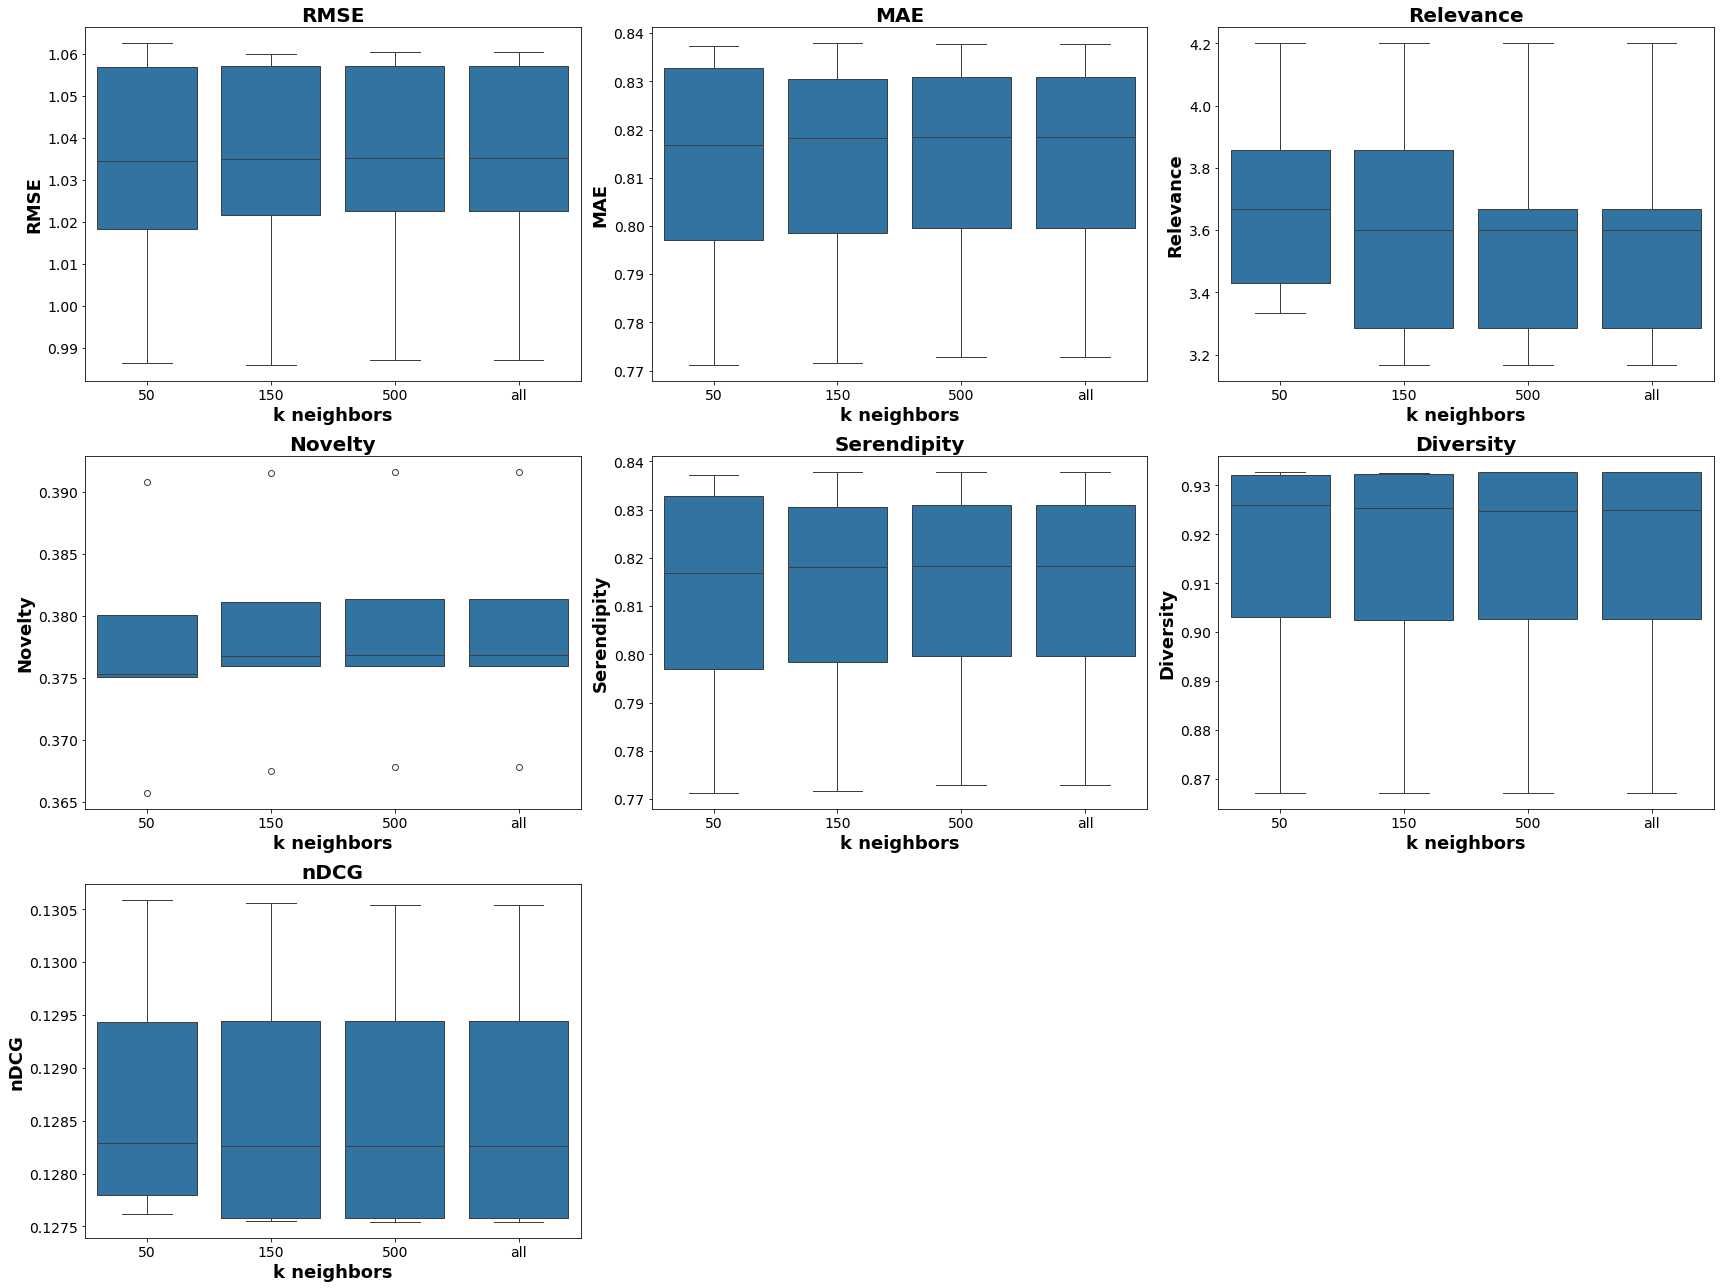

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)

# Renombrar columna si es necesario
df_box = df_box.rename(columns={'nDCG@20': 'nDCG'})

metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Configuración
k_values = [50, 150, 500, None]  # Número de vecinos (None = all)
final_results = []
all_folds_metrics = []

# ⚠️ Asegúrate de que 'folds' esté definido como lista de (train_df, test_df)

def compute_cosine_similarity(R_train):
    R_train_filled = np.nan_to_num(R_train)
    similarity_matrix = cosine_similarity(R_train_filled)
    np.fill_diagonal(similarity_matrix, 0)
    return similarity_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * R_train[v, j] for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        user_means = np.array([
            np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
            for u in range(num_users)
        ])

        similarity_matrix = compute_cosine_similarity(R_train)

        print("🔮 Prediciendo ratings...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        novelty_list = []
        relevance_list = []

        for u in range(num_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue
            top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
            novelty_list.append(novelty_u)
            rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(relevances):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

        def ndcg_at_k(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
        ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
        ndcg_score = np.mean(ndcg_list)

        fold_result = {
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG@20": ndcg_score,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Cosine"
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Memory-based CF",
        "k_neighbors": "all" if k is None else k,
        "Similarity": "Cosine"
    })
    final_results.append(avg_metrics)

# Mostrar resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[['k_neighbors', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:50<00:00,  1.60it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:50<00:00,  1.60it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.60it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:52<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.60it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 500

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:04<00:00,  1.56it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:04<00:00,  1.56it/s]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  1.158580  0.915211   3.969119  0.266549     0.915211   
1         150  1.160450  0.917657   3.815381  0.272826     0.917657   
2         500  1.160919  0.918331   3.832083  0.275003     0.918331   
3         all  1.160918  0.918333   3.832083  0.275030     0.918333   

   Diversity   nDCG@20  
0   0.873595  0.125585  
1   0.873568  0.125449  
2   0.874111  0.126531  
3   0.874171  0.126531  


In [10]:
results_table

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,k_neighbors,Model,Similarity
0,1.158580,0.915211,0.266549,3.969119,0.915211,0.873595,0.125585,50,Memory-based CF,Cosine
1,1.160450,0.917657,0.272826,3.815381,0.917657,0.873568,0.125449,150,Memory-based CF,Cosine
2,1.160919,0.918331,0.275003,3.832083,0.918331,0.874111,0.126531,500,Memory-based CF,Cosine
3,1.160918,0.918333,0.275030,3.832083,0.918333,0.874171,0.126531,all,Memory-based CF,Cosine


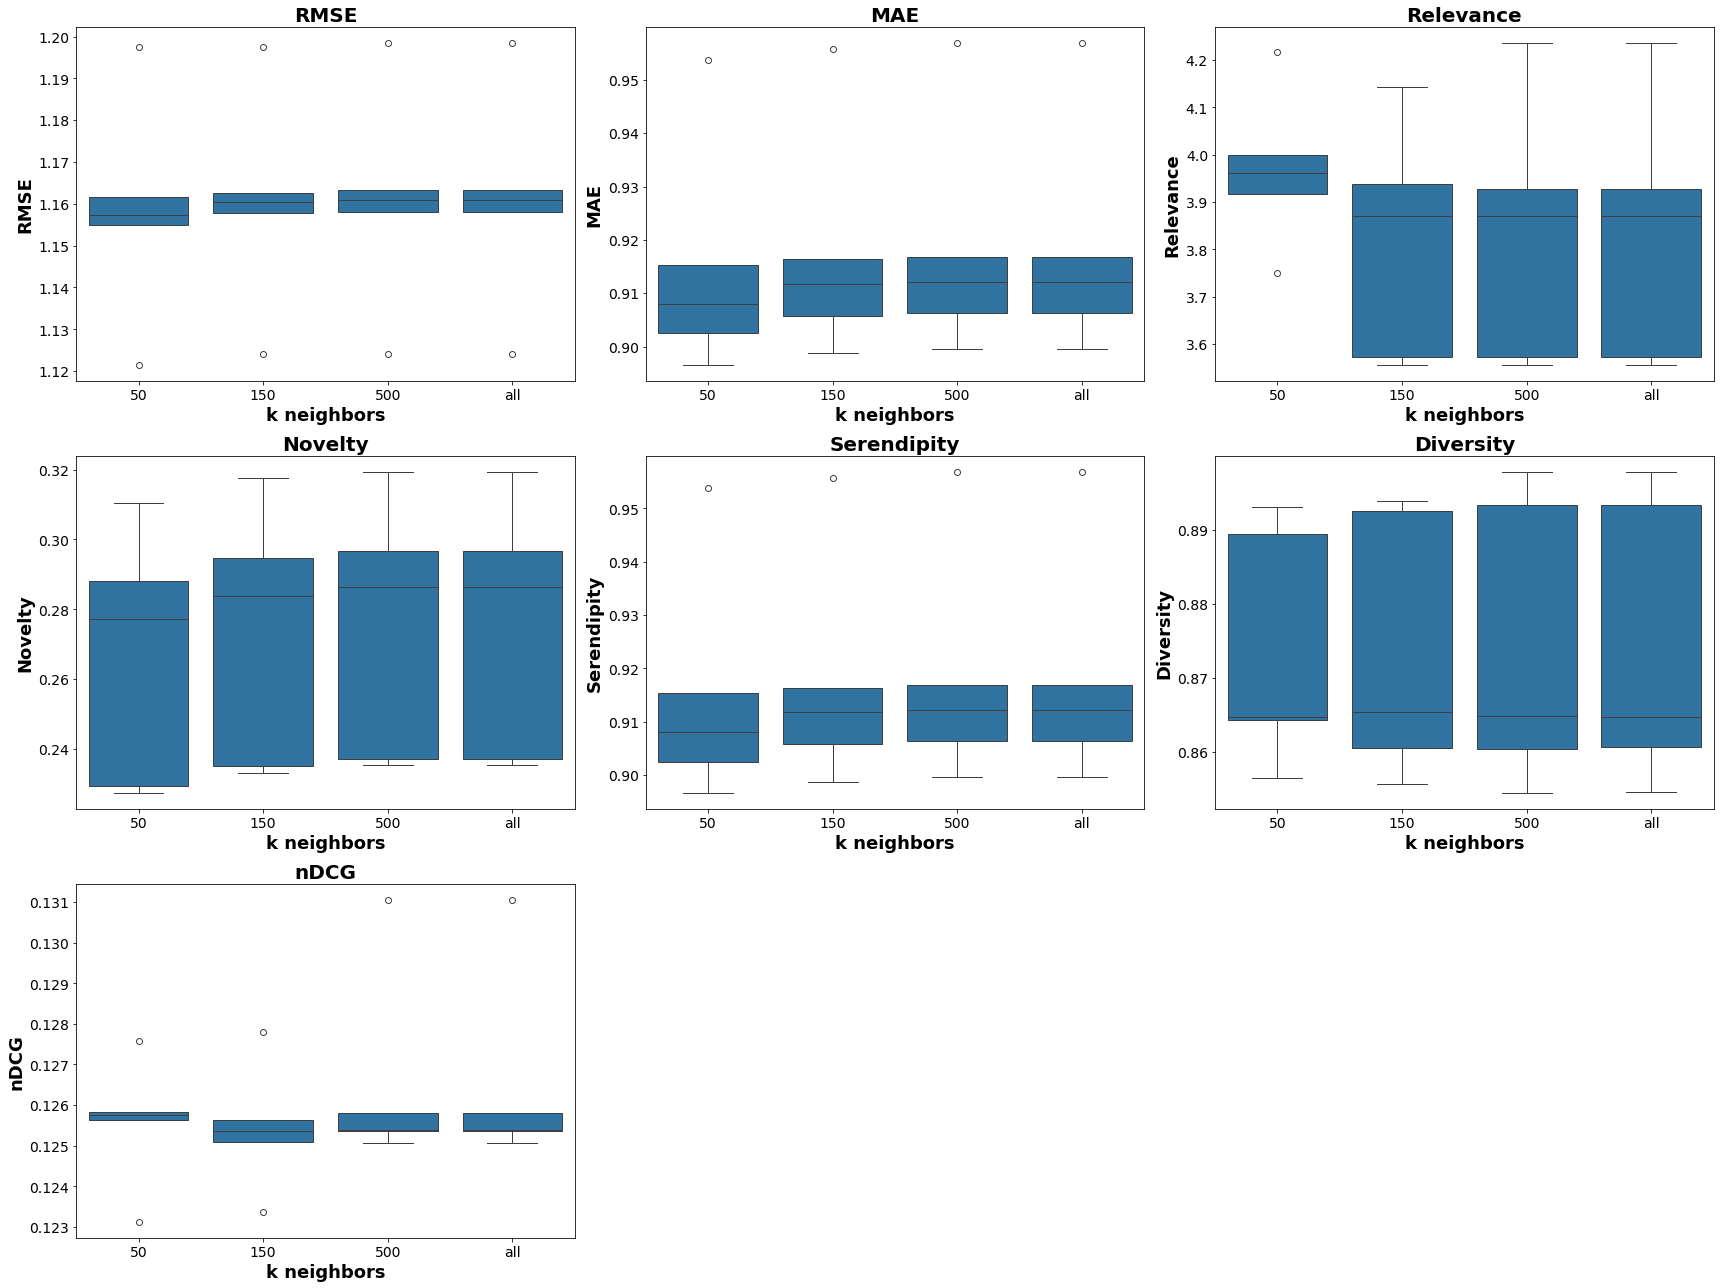

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)

# Renombrar columna si es necesario
df_box = df_box.rename(columns={'nDCG@20': 'nDCG'})

metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### <font color="blue"> **Collaborative Filtering:** iten Neighborhood models</font>

In [72]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Configuración
k_values = [20, 50, 150, None]
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

def predict_user_row(u, R_train, item_similarity, item_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [i for i in range(num_items) if not np.isnan(R_train[u, i]) and i != j]
            if not neighbors:
                predictions[j] = item_means[j]
                continue
            sims = [(i, item_similarity[j, i]) for i in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[u, i] - item_means[i]) for i, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = item_means[j] if denom == 0 else item_means[j] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        item_means = np.array([
            np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0
            for j in range(num_items)
        ])

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        print("🔮 Prediciendo ratings en paralelo...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_row)(u, R_train, item_similarity, item_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        novelty_list, relevance_list = [], []
        for u in range(num_users):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                continue
            top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_list.append(np.mean([item_popularity_inv[j] for j in top_items]))
            rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(rels):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

        def ndcg(u):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
            dcg_score = dcg(rel_pred)
            ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
            idcg = dcg(ideal)
            return dcg_score / idcg if idcg > 0 else 0

        ndcg_scores = [ndcg(u) for u in range(num_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        ndcg = np.mean(ndcg_scores)

        fold_result = {
            "Model": "Item-based CF",
            "Similarity": "Cosine",
            "k_neighbors": "all" if k is None else k,
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG": ndcg
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Item-based CF",
        "Similarity": "Cosine",
        "k_neighbors": "all" if k is None else k
    })
    final_results.append(avg_metrics)

# 📊 Resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[["k_neighbors", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG"]])


🔁 Ejecutando 5-Fold CV para k = 20

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:32<00:00,  1.12s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:35<00:00,  1.12s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:31<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:36<00:00,  1.12s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:42<00:00,  1.13s/it]



🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:39<00:00,  1.12s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:32<00:00,  1.12s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:44<00:00,  1.13s/it]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:47<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:51<00:00,  1.14s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:41<00:00,  1.13s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:46<00:00,  1.13s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:48<00:00,  1.13s/it]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:58<00:00,  1.14s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:59<00:00,  1.14s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:56<00:00,  1.14s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:51<00:00,  1.14s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:57<00:00,  1.14s/it]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          20  1.321403  0.969886   4.198402  0.278106     0.969886   
1          50  1.327070  0.978767   4.016713  0.284139     0.978767   
2         150  1.335653  0.990167   3.893846  0.286313     0.990167   
3         all  1.338165  0.992917   3.840000  0.286796     0.992917   

   Diversity      nDCG  
0   0.924218  0.058230  
1   0.918951  0.058487  
2   0.916077  0.058634  
3   0.915934  0.058549  


In [73]:
results_table

,k_neighbors,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG,Model,Similarity
0,20,1.321403,0.969886,0.278106,4.198402,0.969886,0.924218,0.058230,Item-based CF,Cosine
1,50,1.327070,0.978767,0.284139,4.016713,0.978767,0.918951,0.058487,Item-based CF,Cosine
2,150,1.335653,0.990167,0.286313,3.893846,0.990167,0.916077,0.058634,Item-based CF,Cosine
3,all,1.338165,0.992917,0.286796,3.840000,0.992917,0.915934,0.058549,Item-based CF,Cosine


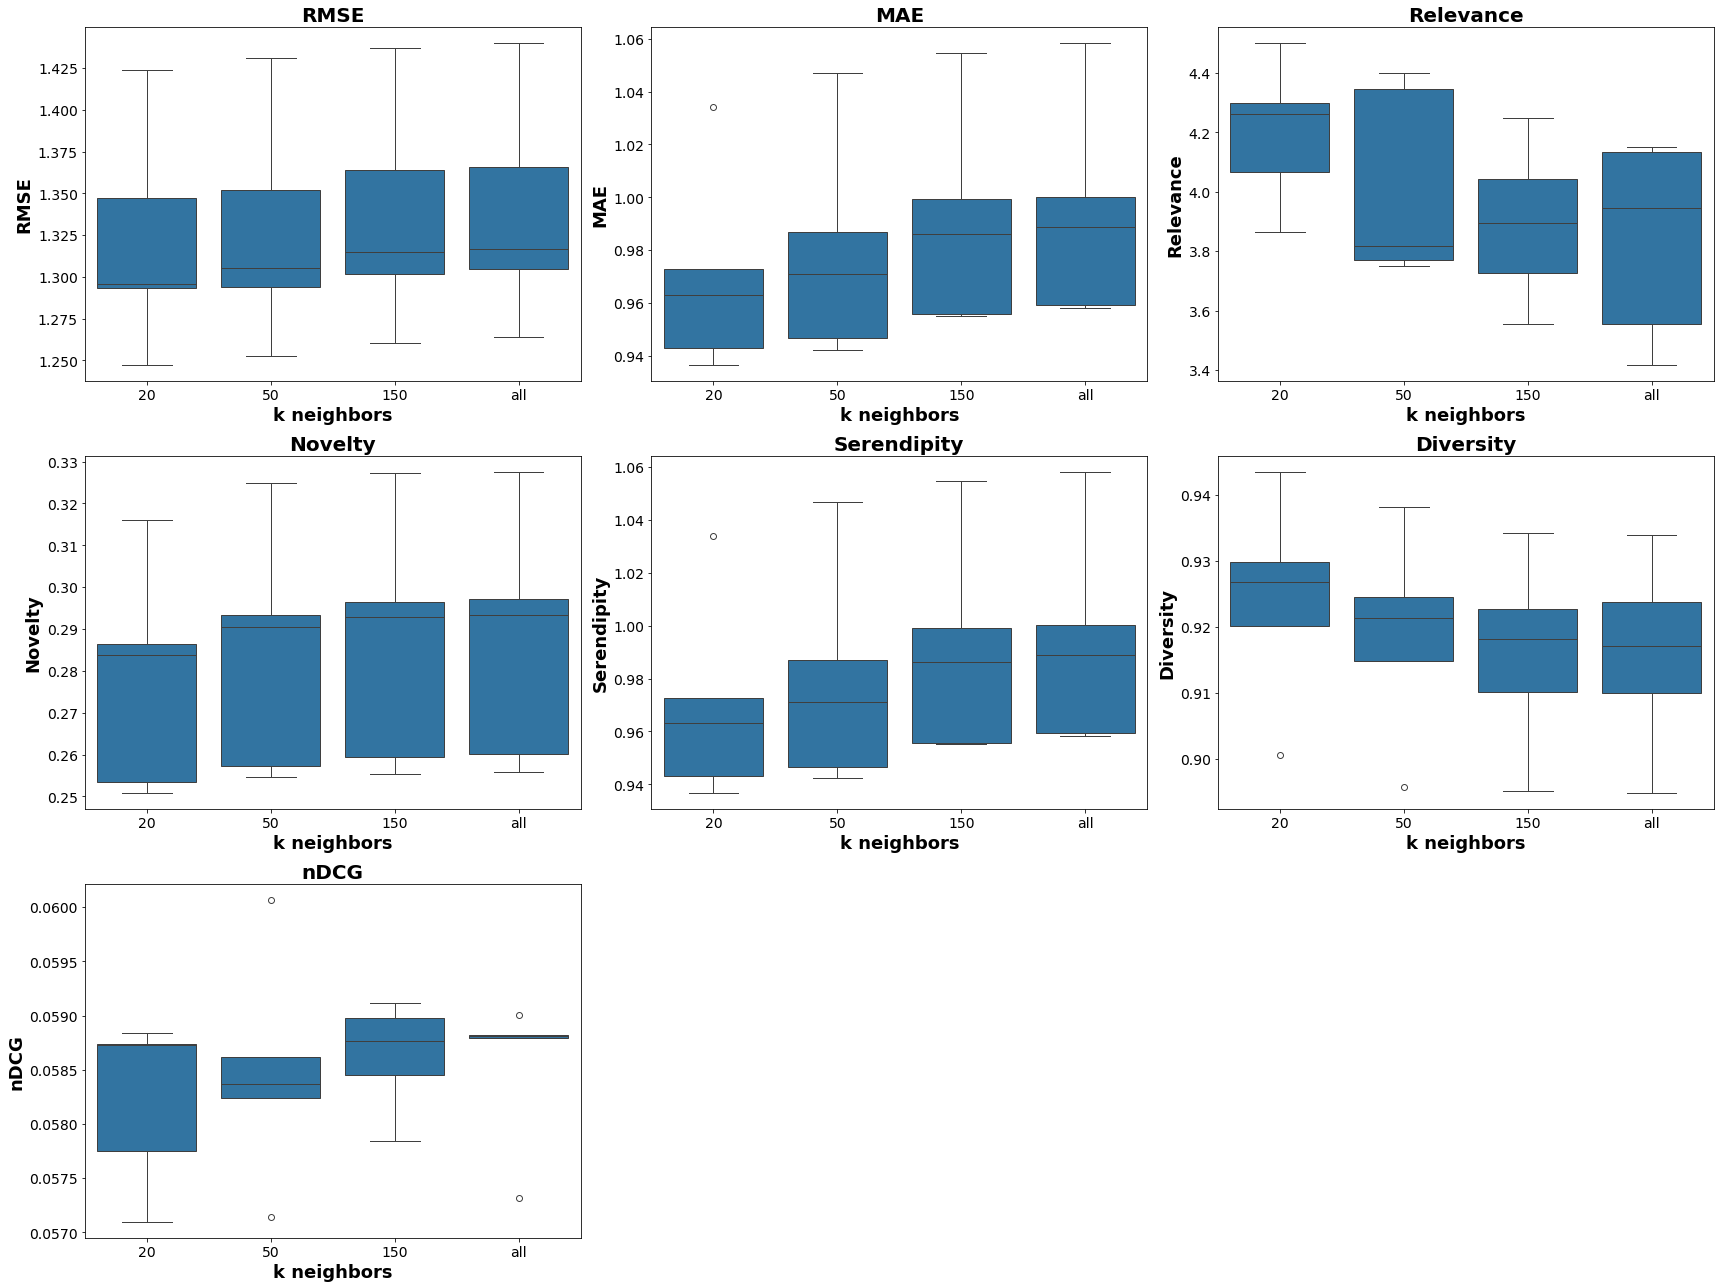

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Configuración
k_values = [20, 50, 150, None]
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

def compute_adjusted_cosine_similarity(R_train):
    num_users, num_items = R_train.shape
    user_means = np.array([np.nanmean(R_train[u, :]) if np.any(~np.isnan(R_train[u, :])) else 0 for u in range(num_users)])
    R_train_centered = np.copy(R_train)
    for u in range(num_users):
        for j in range(num_items):
            if not np.isnan(R_train[u, j]):
                R_train_centered[u, j] -= user_means[u]
            else:
                R_train_centered[u, j] = 0
    return cosine_similarity(R_train_centered.T)

def predict_user_row(u, R_train, item_similarity, item_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [i for i in range(num_items) if not np.isnan(R_train[u, i]) and i != j]
            if not neighbors:
                predictions[j] = item_means[j]
                continue
            sims = [(i, item_similarity[j, i]) for i in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[u, i] - item_means[i]) for i, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = item_means[j] if denom == 0 else item_means[j] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        item_means = np.array([
            np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0
            for j in range(num_items)
        ])

        # Calcular adjusted cosine similarity
        item_similarity = compute_adjusted_cosine_similarity(R_train)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        print("🔮 Prediciendo ratings en paralelo...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_row)(u, R_train, item_similarity, item_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        novelty_list, relevance_list = [], []
        for u in range(num_users):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                continue
            top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_list.append(np.mean([item_popularity_inv[j] for j in top_items]))
            rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(rels):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

        def ndcg(u):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
            dcg_score = dcg(rel_pred)
            ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
            idcg = dcg(ideal)
            return dcg_score / idcg if idcg > 0 else 0

        ndcg_scores = [ndcg(u) for u in range(num_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        ndcg = np.mean(ndcg_scores)

        fold_result = {
            "Model": "Item-based CF",
            "Similarity": "Adjusted Cosine",
            "k_neighbors": "all" if k is None else k,
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG": ndcg
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Item-based CF",
        "Similarity": "Adjusted Cosine",
        "k_neighbors": "all" if k is None else k
    })
    final_results.append(avg_metrics)

# 📊 Resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[["k_neighbors", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG"]])


🔁 Ejecutando 5-Fold CV para k = 20

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:28<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:54<00:00,  1.14s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:34<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:04<00:00,  1.15s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:45<00:00,  1.13s/it]



🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:47<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:30<00:00,  1.11s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:50<00:00,  1.14s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:50<00:00,  1.14s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:42<00:00,  1.13s/it]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:58<00:00,  1.14s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:44<00:00,  1.13s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:41<00:00,  1.13s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:19<00:00,  1.17s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:53<00:00,  1.14s/it]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:52<00:00,  1.14s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:00<00:00,  1.15s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:18<00:00,  1.16s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:09<00:00,  1.16s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [18:00<00:00,  1.15s/it]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          20  1.381737  1.034784   4.040000  0.269501     1.034784   
1          50  1.387144  1.042722   3.993873  0.282386     1.042722   
2         150  1.394500  1.051536   3.970684  0.285693     1.051536   
3         all  1.396742  1.053869   3.942735  0.285823     1.053869   

   Diversity      nDCG  
0   0.973361  0.058278  
1   0.973568  0.058268  
2   0.973121  0.058573  
3   0.973105  0.058814  


In [76]:
results_table

,k_neighbors,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG,Model,Similarity
0,20,1.381737,1.034784,0.269501,4.040000,1.034784,0.973361,0.058278,Item-based CF,Adjusted Cosine
1,50,1.387144,1.042722,0.282386,3.993873,1.042722,0.973568,0.058268,Item-based CF,Adjusted Cosine
2,150,1.394500,1.051536,0.285693,3.970684,1.051536,0.973121,0.058573,Item-based CF,Adjusted Cosine
3,all,1.396742,1.053869,0.285823,3.942735,1.053869,0.973105,0.058814,Item-based CF,Adjusted Cosine


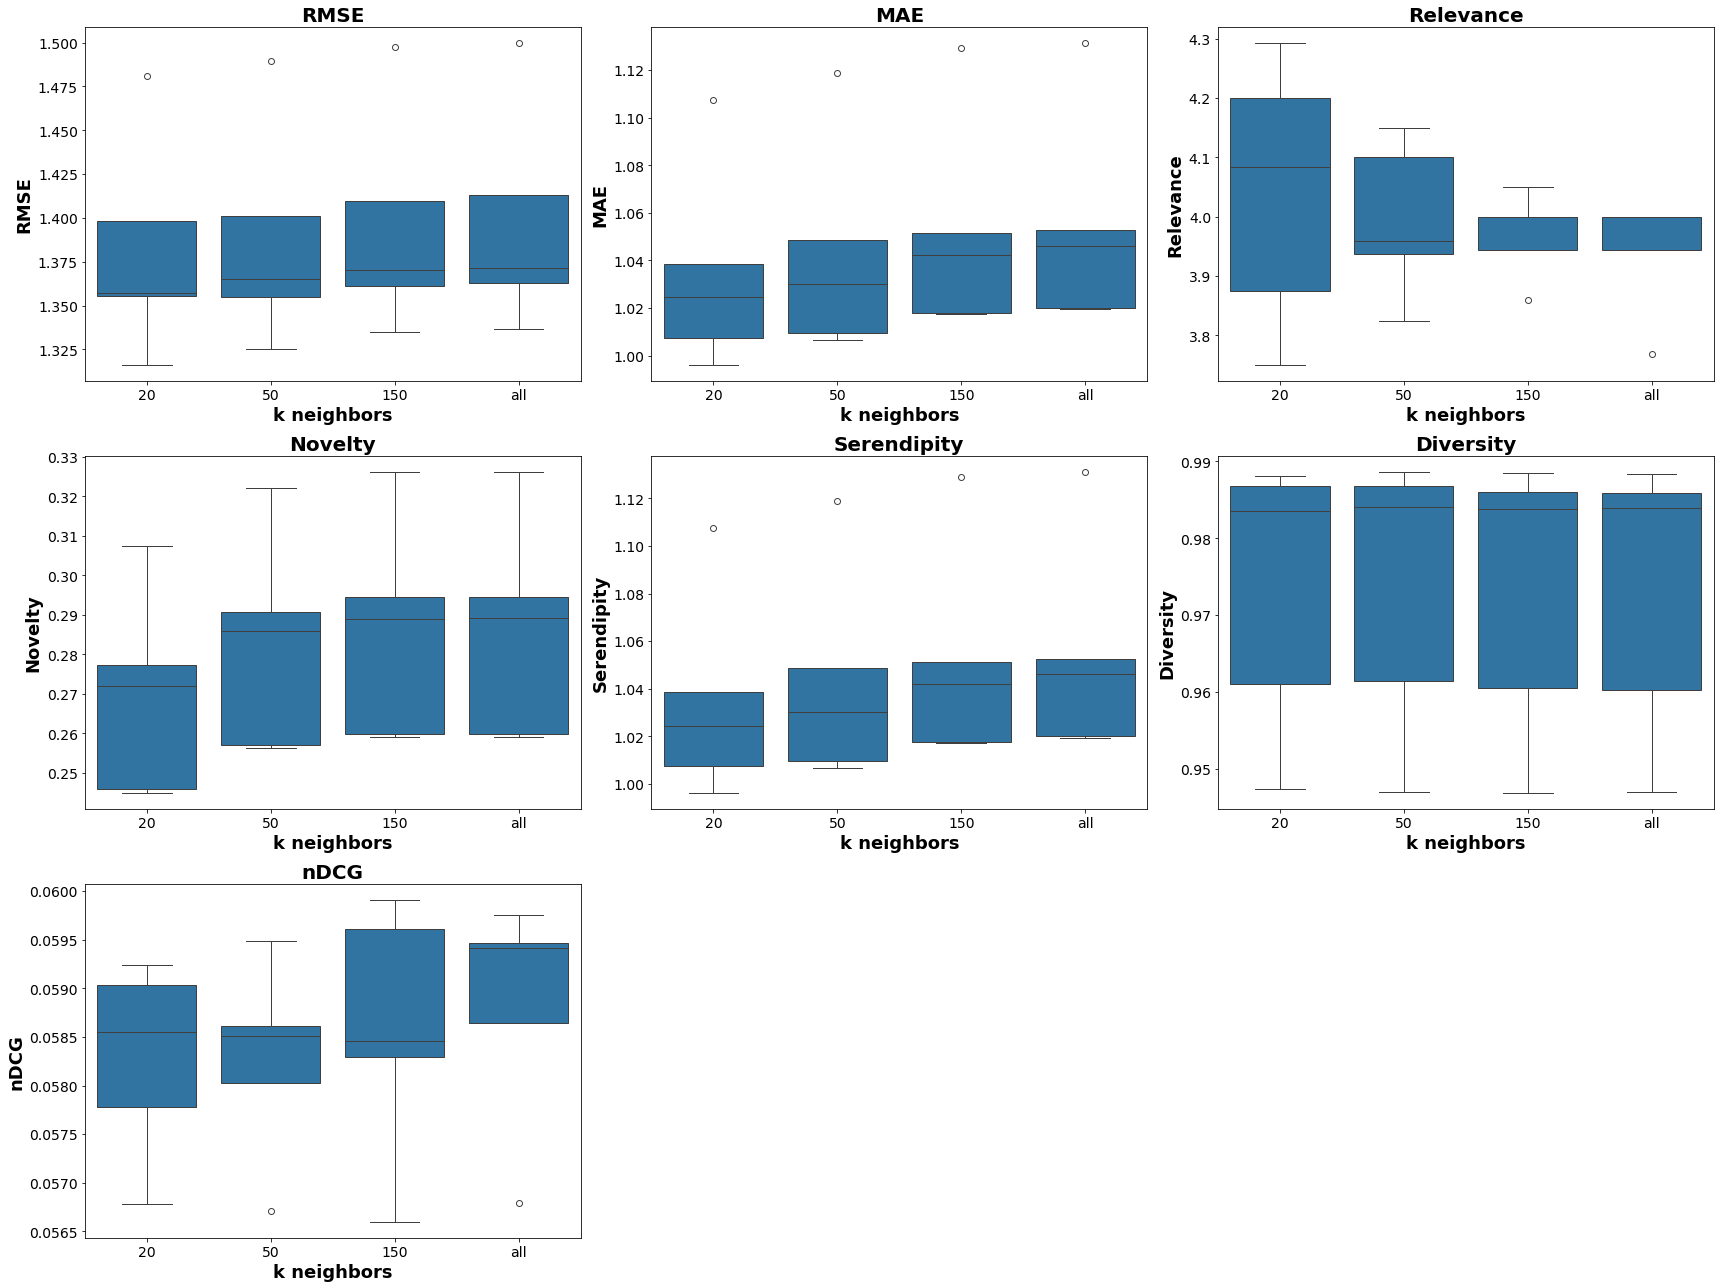

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### <font color="blue"> **Random Forest:** </font>

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, log2
from tqdm import tqdm
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import random

# Función DCG y nDCG personalizada (como pediste)
def dcg(rels):
    return sum(rel / log2(idx + 2) for idx, rel in enumerate(rels))

def ndcg_u(u, R_train, R_test, R_pred):
    known_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
    dcg_score = dcg(rel_pred)
    ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
    idcg = dcg(ideal)
    return dcg_score / idcg if idcg > 0 else 0

# ratings_matrix debe estar definido antes (usuarios x items con NaNs)
user_ids = ratings_matrix.index.tolist()
user_indices = np.arange(len(user_ids))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.5]
}

results = []

for n_est, depth, lr in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['learning_rate']):
    print(f"\nParámetros: n_estimators={n_est}, max_depth={depth}, learning_rate={lr}")
    
    fold_rmses = []
    fold_maes = []
    fold_novelties = []
    fold_relevances = []
    fold_serendipities = []
    fold_diversities = []
    fold_ndcgs = []

    for fold_num, (train_user_idx, test_user_idx) in enumerate(kf.split(user_indices)):
        print(f" Fold {fold_num + 1}")

        train_users = [user_ids[i] for i in train_user_idx]
        test_users = [user_ids[i] for i in test_user_idx]

        train_matrix = ratings_matrix.copy()
        test_matrix = pd.DataFrame(np.nan, index=ratings_matrix.index, columns=ratings_matrix.columns)

        for user in test_users:
            user_ratings = ratings_matrix.loc[user].dropna()
            if len(user_ratings) >= 5:
                test_items = random.sample(list(user_ratings.index), 5)
                for item in test_items:
                    test_matrix.at[user, item] = ratings_matrix.at[user, item]
                    train_matrix.at[user, item] = np.nan

        R_train = train_matrix.values
        R_test = test_matrix.values
        n_users, n_items = R_train.shape

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_pred = np.full(R_train.shape, np.nan)

        for item_idx in tqdm(range(n_items), desc=f"Items XGBoost Fold {fold_num + 1}"):
            y = R_train[:, item_idx]
            X = np.delete(R_train, item_idx, axis=1)

            train_mask = ~np.isnan(y)
            if np.sum(train_mask) < 1:
                fill_value = np.nanmean(y) if np.sum(train_mask) > 0 else np.nanmean(R_train)
                R_pred[:, item_idx] = fill_value
                continue

            X_train = X[train_mask]
            y_train = y[train_mask]

            model = XGBRegressor(n_estimators=n_est, max_depth=depth,
                                 learning_rate=lr, random_state=42, n_jobs=-1, verbosity=0)
            model.fit(X_train, y_train)
            R_pred[:, item_idx] = model.predict(X)

        # Métricas tradicionales
        test_mask = ~np.isnan(R_test)
        predicted = R_pred[test_mask]
        actual = R_test[test_mask]

        valid_mask = ~np.isnan(predicted)
        predicted = predicted[valid_mask]
        actual = actual[valid_mask]

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        fold_rmses.append(rmse)
        fold_maes.append(mae)

        novelty_list = []
        relevance_list = []

        for u in range(n_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue

            user_preds = R_pred[u, unknown_items]
            top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]

            novelty_u = np.mean(item_popularity_inv[top_20_idx])
            novelty_list.append(novelty_u)

            rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
            if rel_ratings:
                relevance_list.append(np.mean(rel_ratings))

        fold_novelties.append(np.mean(novelty_list) if novelty_list else np.nan)
        fold_relevances.append(np.mean(relevance_list) if relevance_list else np.nan)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j])
                              for u, j in zip(*np.where(test_mask))
                              if np.isnan(R_train[u, j])]
        fold_serendipities.append(np.mean(serendipity_scores) if serendipity_scores else np.nan)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        diversity_scores = []
        for u in range(n_users):
            top_5_items = np.argsort(R_pred[u, :])[-5:]
            count = 0
            diversity = 0
            for i in range(len(top_5_items)):
                for j2 in range(i + 1, len(top_5_items)):
                    diversity += 1 - item_similarity[top_5_items[i], top_5_items[j2]]
                    count += 1
            diversity_scores.append(diversity / count if count > 0 else 0)
        fold_diversities.append(np.mean(diversity_scores))

        # === nDCG como tú pediste ===
        ndcg_scores = [ndcg_u(u, R_train, R_test, R_pred) for u in range(n_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        fold_ndcgs.append(np.mean(ndcg_scores))

    results.append({
        "Model": "XGBoost per item with CV",
        "n_estimators": n_est,
        "max_depth": depth,
        "learning_rate": lr,
        "RMSE": np.mean(fold_rmses),
        "MAE": np.mean(fold_maes),
        "Novelty": np.mean(fold_novelties),
        "Relevance": np.mean(fold_relevances),
        "Serendipity": np.mean(fold_serendipities),
        "Diversity": np.mean(fold_diversities),
        "nDCG@all": np.mean(fold_ndcgs)
    })

results_df = pd.DataFrame(results)
print(results_df)





Parámetros: n_estimators=50, max_depth=3, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [01:37<00:00, 17.28it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [01:36<00:00, 17.42it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [01:35<00:00, 17.56it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [01:36<00:00, 17.47it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [01:35<00:00, 17.60it/s]



Parámetros: n_estimators=50, max_depth=3, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [01:25<00:00, 19.61it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [01:41<00:00, 16.62it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [01:26<00:00, 19.52it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [01:25<00:00, 19.68it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [01:26<00:00, 19.38it/s]



Parámetros: n_estimators=50, max_depth=5, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:17<00:00, 12.20it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [02:18<00:00, 12.18it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:18<00:00, 12.19it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:17<00:00, 12.23it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [02:17<00:00, 12.22it/s]



Parámetros: n_estimators=50, max_depth=5, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [01:45<00:00, 15.89it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [01:45<00:00, 16.00it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [01:45<00:00, 16.02it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [01:45<00:00, 16.00it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [01:46<00:00, 15.81it/s]



Parámetros: n_estimators=50, max_depth=10, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [03:34<00:00,  7.84it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [03:34<00:00,  7.85it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [03:35<00:00,  7.81it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [03:34<00:00,  7.86it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [03:34<00:00,  7.86it/s]



Parámetros: n_estimators=50, max_depth=10, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:07<00:00, 13.15it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [02:07<00:00, 13.20it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:07<00:00, 13.15it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:07<00:00, 13.21it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [02:07<00:00, 13.23it/s]



Parámetros: n_estimators=100, max_depth=3, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:36<00:00, 10.77it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [02:36<00:00, 10.72it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:36<00:00, 10.74it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:37<00:00, 10.70it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [02:36<00:00, 10.78it/s]



Parámetros: n_estimators=100, max_depth=3, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:00<00:00, 13.98it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [01:59<00:00, 14.07it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:00<00:00, 14.00it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:00<00:00, 13.92it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [01:59<00:00, 14.09it/s]



Parámetros: n_estimators=100, max_depth=5, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [03:56<00:00,  7.11it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [03:57<00:00,  7.09it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [03:56<00:00,  7.10it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [03:57<00:00,  7.07it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [04:01<00:00,  6.97it/s]



Parámetros: n_estimators=100, max_depth=5, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:15<00:00, 12.37it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [02:15<00:00, 12.39it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:15<00:00, 12.42it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:15<00:00, 12.42it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [02:15<00:00, 12.44it/s]



Parámetros: n_estimators=100, max_depth=10, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [06:23<00:00,  4.39it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [06:24<00:00,  4.38it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [06:22<00:00,  4.40it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [06:21<00:00,  4.40it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [06:22<00:00,  4.40it/s]



Parámetros: n_estimators=100, max_depth=10, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:30<00:00, 11.14it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [02:30<00:00, 11.15it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:30<00:00, 11.14it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:31<00:00, 11.10it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [02:31<00:00, 11.11it/s]



Parámetros: n_estimators=200, max_depth=3, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [04:13<00:00,  6.63it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [04:13<00:00,  6.64it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [04:13<00:00,  6.63it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [04:12<00:00,  6.65it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [04:13<00:00,  6.64it/s]



Parámetros: n_estimators=200, max_depth=3, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [02:54<00:00,  9.61it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [02:53<00:00,  9.68it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [02:54<00:00,  9.63it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [02:53<00:00,  9.72it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [02:55<00:00,  9.56it/s]



Parámetros: n_estimators=200, max_depth=5, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [05:57<00:00,  4.71it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [05:58<00:00,  4.70it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [05:57<00:00,  4.70it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [05:58<00:00,  4.69it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [05:57<00:00,  4.70it/s]



Parámetros: n_estimators=200, max_depth=5, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [03:03<00:00,  9.18it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [03:04<00:00,  9.14it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [03:02<00:00,  9.19it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [03:02<00:00,  9.20it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [03:02<00:00,  9.23it/s]



Parámetros: n_estimators=200, max_depth=10, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [08:21<00:00,  3.36it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [08:21<00:00,  3.35it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [08:19<00:00,  3.37it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [08:19<00:00,  3.37it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [08:20<00:00,  3.36it/s]



Parámetros: n_estimators=200, max_depth=10, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [03:17<00:00,  8.51it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [03:17<00:00,  8.50it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [03:17<00:00,  8.51it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [03:15<00:00,  8.60it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [03:17<00:00,  8.52it/s]



Parámetros: n_estimators=500, max_depth=3, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [07:46<00:00,  3.60it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [07:45<00:00,  3.61it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [07:41<00:00,  3.64it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [07:47<00:00,  3.60it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [07:47<00:00,  3.59it/s]



Parámetros: n_estimators=500, max_depth=3, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [05:13<00:00,  5.36it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [05:13<00:00,  5.37it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [05:13<00:00,  5.37it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [05:15<00:00,  5.34it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [05:14<00:00,  5.35it/s]



Parámetros: n_estimators=500, max_depth=5, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [09:10<00:00,  3.06it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [09:12<00:00,  3.04it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [09:10<00:00,  3.06it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [09:11<00:00,  3.05it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [09:10<00:00,  3.06it/s]



Parámetros: n_estimators=500, max_depth=5, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [05:17<00:00,  5.30it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [05:15<00:00,  5.32it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [05:18<00:00,  5.28it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [05:16<00:00,  5.31it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [05:19<00:00,  5.27it/s]



Parámetros: n_estimators=500, max_depth=10, learning_rate=0.1
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [10:42<00:00,  2.62it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [10:43<00:00,  2.61it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [10:44<00:00,  2.61it/s]


 Fold 4


Items XGBoost Fold 4: 100%|██████████| 1682/1682 [10:39<00:00,  2.63it/s]


 Fold 5


Items XGBoost Fold 5: 100%|██████████| 1682/1682 [10:44<00:00,  2.61it/s]



Parámetros: n_estimators=500, max_depth=10, learning_rate=0.5
 Fold 1


Items XGBoost Fold 1: 100%|██████████| 1682/1682 [05:32<00:00,  5.06it/s]


 Fold 2


Items XGBoost Fold 2: 100%|██████████| 1682/1682 [05:30<00:00,  5.08it/s]


 Fold 3


Items XGBoost Fold 3: 100%|██████████| 1682/1682 [05:30<00:00,  5.09it/s]


 Fold 4


Items XGBoost Fold 4:  95%|█████████▌| 1604/1682 [05:23<00:07,  9.76it/s]

In [59]:
results_df

,Model,n_estimators,max_depth,learning_rate,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@all
0,XGBoost per item with CV,50,3,0.1,1.031186,0.804651,0.260723,NaN,0.804651,0.986476,0.032139
1,XGBoost per item with CV,50,3,0.5,1.072473,0.841776,0.255340,4.392033,0.841776,0.808558,0.032256
2,XGBoost per item with CV,50,5,0.1,1.064749,0.827408,0.253902,4.116667,0.827408,0.968773,0.032140
3,XGBoost per item with CV,50,5,0.5,1.103812,0.859188,0.246487,4.314103,0.859188,0.776312,0.032605
4,XGBoost per item with CV,50,10,0.1,1.091845,0.849999,0.243951,4.483333,0.849999,0.971126,0.032338
5,XGBoost per item with CV,50,10,0.5,1.132132,0.882140,0.242584,4.374343,0.882140,0.774741,0.032237
6,XGBoost per item with CV,100,3,0.1,1.034278,0.803025,0.269595,4.250000,0.803025,0.944151,0.032195
7,XGBoost per item with CV,100,3,0.5,1.059899,0.828310,0.253036,4.438512,0.828310,0.792845,0.032316
8,XGBoost per item with CV,100,5,0.1,1.039762,0.804751,0.258421,4.546667,0.804751,0.905541,0.032237
9,XGBoost per item with CV,100,5,0.5,1.079213,0.843945,0.246680,4.613788,0.843945,0.785581,0.032422


In [4]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from math import sqrt

# ========== MATRICES ORIGINALES ==========
R_original = ratings_matrix.values

# ========== HIPERPARÁMETROS ==========
k_values = [10]
alpha_values = [0.001, 0.005]
lambda_values = [0.01, 0.05]

final_results = []
all_folds_metrics = []  # Para resultados por fold

# ========== FUNCIÓN DE FACTORIZACIÓN ==========
def matrix_factorization(R, k, steps, alpha, lambda_reg):
    m, n = R.shape
    U = np.random.randn(m, k) * 0.01
    V = np.random.randn(n, k) * 0.01

    for step in tqdm(range(steps), desc=f"🔧 k={k} α={alpha} λ={lambda_reg}", leave=False):
        for i in range(m):
            for j in range(n):
                if np.isnan(R[i, j]):
                    continue
                pred = np.dot(U[i], V[j])
                err = R[i, j] - pred
                for r in range(k):
                    U[i, r] += alpha * (err * V[j, r] - lambda_reg * U[i, r])
                    V[j, r] += alpha * (err * U[i, r] - lambda_reg * V[j, r])
    return U, V

# ========== FUNCIONES AUXILIARES ==========
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

def ndcg_at_k(u, R_pred, R_train, R_test, k="all"):
    known_train_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_train_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
    top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
    dcg_score = dcg(rel_pred)
    actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
    if not actual_ratings:
        return np.nan
    actual_ratings.sort(key=lambda x: x[1], reverse=True)
    ideal_rel = [r for _, r in actual_ratings[:k_val]]
    ideal_dcg = dcg(ideal_rel)
    return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

# ========== CROSS VALIDATION ==========
for k in k_values:
    for alpha in alpha_values:
        for lambda_reg in lambda_values:
            print(f"\n🔁 Ejecutando 5-Fold CV para k={k}, alpha={alpha}, lambda={lambda_reg}")
            fold_metrics = []

            for fold_num, (train_matrix, test_matrix) in enumerate(folds):
                print(f"\n▶️ Fold {fold_num + 1}")
                R_train = train_matrix.values
                R_test = test_matrix.values
                test_mask = ~np.isnan(R_test)
                test_indices = list(zip(*np.where(test_mask)))

                start_time = time.time()
                U, V = matrix_factorization(R_train, k=k, steps=1000, alpha=alpha, lambda_reg=lambda_reg)
                end_time = time.time()
                training_time = end_time - start_time

                R_pred = np.dot(U, V.T)

                # ===== MÉTRICAS BÁSICAS =====
                actual = [R_original[i, j] for i, j in test_indices]
                predicted = [R_pred[i, j] for i, j in test_indices]
                rmse = sqrt(mean_squared_error(actual, predicted))
                mae = mean_absolute_error(actual, predicted)

                # ===== MÉTRICAS ADICIONALES =====
                item_popularity = np.nansum(~np.isnan(R_train), axis=0)
                item_popularity_inv = 1 / (item_popularity + 1e-10)

                novelty_list = []
                relevance_list = []

                for u in range(R_train.shape[0]):
                    known_train_items = ~np.isnan(R_train[u])
                    unknown_items = np.where(~known_train_items)[0]
                    if len(unknown_items) == 0:
                        continue
                    user_preds = R_pred[u, unknown_items]
                    top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]
                    novelty_u = np.mean(item_popularity_inv[top_20_idx])
                    novelty_list.append(novelty_u)
                    rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                    if rel_ratings:
                        relevance_list.append(np.mean(rel_ratings))

                novelty = np.mean(novelty_list) if novelty_list else np.nan
                relevance = np.mean(relevance_list) if relevance_list else np.nan

                # === SERENDIPITY ===
                serendipity_scores = [abs(R_pred[u, j] - R_test[u, j])
                                      for u, j in zip(*np.where(test_mask))
                                      if np.isnan(R_train[u, j])]
                serendipity = np.mean(serendipity_scores) if serendipity_scores else np.nan

                # === DIVERSITY ===
                R_train_filled = np.nan_to_num(R_train)
                item_similarity = cosine_similarity(R_train_filled.T)

                diversity_scores = []
                for u in range(R_train.shape[0]):
                    top_5_items = np.argsort(R_pred[u, :])[-5:]
                    count = 0
                    diversity = 0
                    for i in range(len(top_5_items)):
                        for j2 in range(i + 1, len(top_5_items)):
                            diversity += 1 - item_similarity[top_5_items[i], top_5_items[j2]]
                            count += 1
                    diversity_scores.append(diversity / count if count > 0 else 0)

                diversity = np.mean(diversity_scores)

                # === NDCG ===
                ndcg_list = [ndcg_at_k(u, R_pred, R_train, R_test, k="all") for u in range(R_train.shape[0])]
                ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
                ndcg_score = np.mean(ndcg_list)

                fold_result = {
                    "Latent Factors (k)": k,
                    "Alpha": alpha,
                    "Lambda": lambda_reg,
                    "Training Time (s)": training_time,
                    "RMSE": rmse,
                    "MAE": mae,
                    "Diversity": diversity,
                    "Novelty": novelty,
                    "Serendipity": serendipity,
                    "Relevance": relevance,
                    "nDCG": ndcg_score
                }

                fold_metrics.append(fold_result)
                all_folds_metrics.append(fold_result)

            avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
            avg_metrics.update({
                "Latent Factors (k)": k,
                "Alpha": alpha,
                "Lambda": lambda_reg
            })
            final_results.append(avg_metrics)

# ========== MOSTRAR RESULTADOS ==========
results_df = pd.DataFrame(final_results)
print("\n✅ Resultados promedio por configuración:")
display(results_df.sort_values(by="RMSE"))


🔁 Ejecutando 5-Fold CV para k=10, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



✅ Resultados promedio por configuración:


,Latent Factors (k),Alpha,Lambda,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
1,10,0.001,0.05,4227.800103,1.337068,0.977756,0.844116,0.132168,0.977756,4.119606,0.132635
3,10,0.005,0.05,4267.894532,1.362497,0.998682,0.888486,0.131417,0.998682,4.051058,0.131843
0,10,0.001,0.01,4156.621329,1.394176,1.023605,0.833910,0.073082,1.023605,4.082799,0.132698
2,10,0.005,0.01,4267.385303,1.471751,1.081990,0.922138,0.096289,1.081990,3.731407,0.130552


In [5]:
results_df

,Latent Factors (k),Alpha,Lambda,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
0,10,0.001,0.01,4156.621329,1.394176,1.023605,0.833910,0.073082,1.023605,4.082799,0.132698
1,10,0.001,0.05,4227.800103,1.337068,0.977756,0.844116,0.132168,0.977756,4.119606,0.132635
2,10,0.005,0.01,4267.385303,1.471751,1.081990,0.922138,0.096289,1.081990,3.731407,0.130552
3,10,0.005,0.05,4267.894532,1.362497,0.998682,0.888486,0.131417,0.998682,4.051058,0.131843


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import time
from sklearn.metrics.pairwise import cosine_similarity

def svd_iterative_fill(R, k=3, steps=20):
    R = R.copy()
    user_means = np.nanmean(R, axis=1)
    R_centered = R - user_means[:, np.newaxis]
    R_centered[np.isnan(R_centered)] = 0

    for _ in range(steps):
        U, S, Vt = np.linalg.svd(R_centered, full_matrices=False)
        S = np.diag(S[:k])
        U = U[:, :k]
        Vt = Vt[:k, :]
        R_hat = U @ S @ Vt
        R_centered[np.isnan(R)] = R_hat[np.isnan(R)]

    R_final = R_centered + user_means[:, np.newaxis]
    return R_final

# Funciones para métricas adicionales
def dcg(rels):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

def ndcg(u, R_train, R_pred, R_test):
    known_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    # ordenamos todos los desconocidos por predicción (toma todo, no top-K)
    top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[::-1]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
    dcg_score = dcg(rel_pred)
    ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
    idcg = dcg(ideal)
    return dcg_score / idcg if idcg > 0 else 0

results = []
# Valores a probar
k_values = [3, 5, 10]
step_values = [20, 50, 100]

results = []

for k in k_values:
    for steps in step_values:
        print(f"\n🔁 Ejecutando SVD iterativo con k={k}, steps={steps}")
        rmse_list, mae_list = [], []
        novelty_list, relevance_list, serendipity_list, diversity_list, ndcg_list = [], [], [], [], []

        for fold_num, (train_matrix, test_matrix) in enumerate(folds):
            print(f"▶️ Fold {fold_num + 1}")
            R_train = train_matrix.values
            R_test = test_matrix.values
            test_mask = ~np.isnan(R_test)
            test_indices = list(zip(*np.where(test_mask)))
            n_users, n_items = R_train.shape

            start_time = time.time()
            R_pred = svd_iterative_fill(R_train, k=k, steps=steps)
            end_time = time.time()

            actual = [R_test[i, j] for i, j in test_indices]
            predicted = [R_pred[i, j] for i, j in test_indices]
            rmse = sqrt(mean_squared_error(actual, predicted))
            mae = mean_absolute_error(actual, predicted)

            item_popularity = np.sum(~np.isnan(R_train), axis=0)
            item_popularity_inv = 1 / (item_popularity + 1)

            novelty_fold, relevance_fold, serendipity_fold, ndcg_fold = [], [], [], []
            R_train_filled = np.nan_to_num(R_train)
            item_similarity = cosine_similarity(R_train_filled.T)
            diversity_fold = []

            for u in range(n_users):
                known_train_items = ~np.isnan(R_train[u])
                unknown_items = np.where(~known_train_items)[0]
                if len(unknown_items) == 0:
                    continue

                user_preds = R_pred[u, unknown_items]
                top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]

                novelty_u = np.mean(item_popularity_inv[top_20_idx])
                novelty_fold.append(novelty_u)

                rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                if rel_ratings:
                    relevance_fold.append(np.mean(rel_ratings))

                ser_scores = [abs(R_pred[u, j] - R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
                if ser_scores:
                    serendipity_fold.append(np.mean(ser_scores))

                ndcg_u = ndcg(u, R_train, R_pred, R_test)
                if not np.isnan(ndcg_u):
                    ndcg_fold.append(ndcg_u)

                top_5_items = np.argsort(R_pred[u, :])[-5:]
                count, diversity = 0, 0
                for i1 in range(len(top_5_items)):
                    for i2 in range(i1 + 1, len(top_5_items)):
                        diversity += 1 - item_similarity[top_5_items[i1], top_5_items[i2]]
                        count += 1
                diversity_fold.append(diversity / count if count > 0 else 0)

            rmse_list.append(rmse)
            mae_list.append(mae)
            novelty_list.append(np.mean(novelty_fold) if novelty_fold else np.nan)
            relevance_list.append(np.mean(relevance_fold) if relevance_fold else np.nan)
            serendipity_list.append(np.mean(serendipity_fold) if serendipity_fold else np.nan)
            diversity_list.append(np.mean(diversity_fold) if diversity_fold else np.nan)
            ndcg_list.append(np.mean(ndcg_fold) if ndcg_fold else np.nan)

            print(f"  Fold RMSE: {rmse:.4f}, MAE: {mae:.4f}, Time: {end_time - start_time:.2f}s")

        results.append({
            "Latent Factors (k)": k,
            "Steps": steps,
            "Avg RMSE": np.mean(rmse_list),
            "Avg MAE": np.mean(mae_list),
            "Avg Novelty": np.mean(novelty_list),
            "Avg Relevance": np.mean(relevance_list),
            "Avg Serendipity": np.mean(serendipity_list),
            "Avg Diversity": np.mean(diversity_list),
            "Avg nDCG": np.mean(ndcg_list)
        })

results_df = pd.DataFrame(results)
print("\n✅ Resultados promedio por configuración:")
print(results_df.sort_values(by=["Latent Factors (k)", "Steps"]))


🔁 Ejecutando SVD iterativo con k=3, steps=20
▶️ Fold 1
  Fold RMSE: 0.9786, MAE: 0.7795, Time: 18.47s
▶️ Fold 2
  Fold RMSE: 1.0242, MAE: 0.8028, Time: 13.42s
▶️ Fold 3
  Fold RMSE: 0.9758, MAE: 0.7682, Time: 13.45s
▶️ Fold 4
  Fold RMSE: 1.0497, MAE: 0.8207, Time: 13.59s
▶️ Fold 5
  Fold RMSE: 1.0642, MAE: 0.8376, Time: 13.33s

🔁 Ejecutando SVD iterativo con k=3, steps=50
▶️ Fold 1
  Fold RMSE: 0.9631, MAE: 0.7641, Time: 33.55s
▶️ Fold 2
  Fold RMSE: 1.0065, MAE: 0.7899, Time: 33.34s
▶️ Fold 3
  Fold RMSE: 0.9673, MAE: 0.7592, Time: 33.54s
▶️ Fold 4
  Fold RMSE: 1.0386, MAE: 0.8078, Time: 34.36s
▶️ Fold 5
  Fold RMSE: 1.0523, MAE: 0.8213, Time: 33.56s

🔁 Ejecutando SVD iterativo con k=3, steps=100
▶️ Fold 1
  Fold RMSE: 0.9558, MAE: 0.7541, Time: 66.95s
▶️ Fold 2
  Fold RMSE: 1.0006, MAE: 0.7852, Time: 67.29s
▶️ Fold 3
  Fold RMSE: 0.9684, MAE: 0.7590, Time: 63.45s
▶️ Fold 4
  Fold RMSE: 1.0393, MAE: 0.8041, Time: 67.24s
▶️ Fold 5
  Fold RMSE: 1.0510, MAE: 0.8186, Time: 63.65s

🔁 Eje

In [15]:
results_df

,Latent Factors (k),Steps,Avg RMSE,Avg MAE,Avg Novelty,Avg Relevance,Avg Serendipity,Avg Diversity,Avg nDCG
0,3,20,1.018530,0.801756,0.009078,4.172197,0.800454,0.633580,0.065207
1,3,50,1.005569,0.788466,0.016755,4.126650,0.786128,0.643949,0.064266
2,3,100,1.003022,0.784189,0.032316,3.951056,0.782894,0.659420,0.063617
3,5,20,1.033993,0.811665,0.010280,4.146346,0.801359,0.635286,0.066490
4,5,50,1.038335,0.808053,0.019650,4.100238,0.792463,0.660570,0.064889
5,5,100,1.048575,0.811213,0.035144,4.057891,0.793698,0.702552,0.064007
6,10,20,1.036688,0.812556,0.012565,4.253440,0.804933,0.650578,0.066387
7,10,50,1.058476,0.823560,0.021524,4.243710,0.812252,0.712808,0.064570
8,10,100,1.090936,0.842224,0.031594,4.102743,0.830107,0.780446,0.063073


# Bellongis U1R con 1 ratings por item

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

np.random.seed(1)

item_ids = ratings_matrix.columns.tolist()
item_indices = np.arange(len(item_ids))
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []

num_test_ratings_per_item = 1  # Cambia aquí el número de ratings test por ítem

for fold_num, (train_item_idx, test_item_idx) in enumerate(kf.split(item_indices)):
    print(f"\n🔄 Fold {fold_num + 1} (Bellogin U1R, {num_test_ratings_per_item} ratings por ítem)")

    train_items = [item_ids[i] for i in train_item_idx]
    test_items = [item_ids[i] for i in test_item_idx]

    train_matrix = ratings_matrix.copy()
    test_matrix = pd.DataFrame(np.nan, index=ratings_matrix.index, columns=ratings_matrix.columns)

    for item in test_items:
        users_with_rating = ratings_matrix.index[ratings_matrix[item].notna()]
        if len(users_with_rating) == 0:
            continue
        # Si hay menos de 3 ratings, toma todos
        num_to_sample = min(num_test_ratings_per_item, len(users_with_rating))
        users_test = np.random.choice(users_with_rating, size=num_to_sample, replace=False)

        for user_test in users_test:
            test_matrix.at[user_test, item] = ratings_matrix.at[user_test, item]
            train_matrix.at[user_test, item] = np.nan

    train_ratings = np.count_nonzero(~np.isnan(train_matrix.values))
    test_ratings = np.count_nonzero(~np.isnan(test_matrix.values))
    print(f"✅ Train ratings: {train_ratings}")
    print(f"✅ Test ratings: {test_ratings}")

    folds.append((train_matrix, test_matrix))


🔄 Fold 1 (Bellogin U1R, 1 ratings por ítem)
✅ Train ratings: 99663
✅ Test ratings: 337

🔄 Fold 2 (Bellogin U1R, 1 ratings por ítem)
✅ Train ratings: 99663
✅ Test ratings: 337

🔄 Fold 3 (Bellogin U1R, 1 ratings por ítem)
✅ Train ratings: 99664
✅ Test ratings: 336

🔄 Fold 4 (Bellogin U1R, 1 ratings por ítem)
✅ Train ratings: 99664
✅ Test ratings: 336

🔄 Fold 5 (Bellogin U1R, 1 ratings por ítem)
✅ Train ratings: 99664
✅ Test ratings: 336


In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from math import sqrt
import numpy as np
import pandas as pd

# Modelos básicos
def global_mean(train):
    mean = np.nanmean(train.values)
    return pd.DataFrame(mean, index=train.index, columns=train.columns)

def item_mean(train):
    means = train.mean(axis=0)
    return pd.DataFrame(np.tile(means.values, (train.shape[0], 1)),
                        index=train.index, columns=train.columns)

def user_mean(train):
    means = train.mean(axis=1)
    return pd.DataFrame(np.tile(means.values.reshape(-1, 1), (1, train.shape[1])),
                        index=train.index, columns=train.columns)

def random_baseline(train):
    min_rating = np.nanmin(train.values)
    max_rating = np.nanmax(train.values)
    rand_preds = np.random.uniform(min_rating, max_rating, size=train.shape)
    return pd.DataFrame(rand_preds, index=train.index, columns=train.columns)

def popularity_baseline(train):
    item_popularity = np.sum(~np.isnan(train.values), axis=0)  # número de ratings por ítem
    preds = np.full(train.shape, np.nan)  # empezamos con predicciones vacías

    for u in range(train.shape[0]):
        # Ítems no vistos por el usuario
        unseen_items = np.isnan(train.values[u])
        # Asigna el score de popularidad a esos ítems
        preds[u, unseen_items] = item_popularity[unseen_items]

    # Normaliza por conveniencia (entre 1 y 5 por ejemplo)
    min_score = np.nanmin(preds)
    max_score = np.nanmax(preds)
    if max_score > min_score:
        preds = 1 + 4 * (preds - min_score) / (max_score - min_score)  # normalizar a escala 1-5

    return pd.DataFrame(preds, index=train.index, columns=train.columns)

models = {
    "Global Mean": global_mean,
    "Item Mean": item_mean,
    "User Mean": user_mean,
    "Random": random_baseline,
    "Popularity": popularity_baseline
}

final_results = []

def compute_all_metrics(test_matrix, pred_matrix, train_matrix):
    R_test = test_matrix.values
    R_pred = pred_matrix.values
    R_train = train_matrix.values
    num_users, num_items = R_test.shape

    test_indices = list(zip(*np.where(~np.isnan(R_test))))
    y_true, y_pred = [], []

    for u, i in test_indices:
        pred = R_pred[u, i]
        true = R_test[u, i]
        if not np.isnan(pred) and not np.isnan(true):
            y_pred.append(pred)
            y_true.append(true)

    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Novelty
    item_popularity = np.sum(~np.isnan(R_train), axis=0)
    item_popularity_inv = 1 / (item_popularity + 1)

    novelty_list = []
    relevance_list = []

    for u in range(num_users):
        known_items = ~np.isnan(R_train[u])
        unknown_items = np.where(~known_items)[0]
        if len(unknown_items) == 0:
            continue
        top_20 = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
        novelty_u = np.mean([item_popularity_inv[i] for i in top_20])
        novelty_list.append(novelty_u)

        rel = [R_test[u, i] for i in top_20 if not np.isnan(R_test[u, i])]
        if rel:
            relevance_list.append(np.mean(rel))

    novelty = np.mean(novelty_list)
    relevance = np.mean(relevance_list)

    # Serendipity
    serendipity_scores = [abs(R_pred[u, i] - R_test[u, i]) for u, i in test_indices if np.isnan(R_train[u, i])]
    serendipity = np.mean(serendipity_scores)

    # Diversity
    R_train_filled = np.nan_to_num(R_train)
    item_sim = cosine_similarity(R_train_filled.T)

    diversity_list = []
    for u in range(num_users):
        top_5 = np.argsort(R_pred[u])[-5:]
        div = 0
        count = 0
        for i in range(len(top_5)):
            for j in range(i + 1, len(top_5)):
                div += 1 - item_sim[top_5[i], top_5[j]]
                count += 1
        if count > 0:
            diversity_list.append(div / count)
    diversity = np.mean(diversity_list)

    # nDCG@20
    def dcg(rel):
        return sum(r / np.log2(i + 2) for i, r in enumerate(rel))

    def ndcg(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

    ndcg_scores = [ndcg(u) for u in range(num_users)]
    ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
    ndcg_score = np.mean(ndcg_scores)

    return {
        "RMSE": rmse,
        "MAE": mae,
        "Novelty": novelty,
        "Relevance": relevance,
        "Serendipity": serendipity,
        "Diversity": diversity,
        "nDCG@20": ndcg_score
    }

# Evaluación cruzada para todos los modelos
for model_name, model_func in models.items():
    print(f"\n🔍 Evaluando modelo: {model_name}")
    fold_metrics = []
    for fold_idx, (train_matrix, test_matrix) in enumerate(folds):
        pred_matrix = model_func(train_matrix)
        metrics = compute_all_metrics(test_matrix, pred_matrix, train_matrix)
        metrics["Fold"] = fold_idx + 1
        metrics["Model"] = model_name
        fold_metrics.append(metrics)
    df_fold = pd.DataFrame(fold_metrics)
    mean_metrics = df_fold.mean(numeric_only=True).to_dict()
    mean_metrics["Model"] = model_name
    final_results.append(mean_metrics)

# Resultados finales en tabla
results_table = pd.DataFrame(final_results)
print("\n📊 Resultados promedio de los modelos benchmark con todas las métricas:")
print(results_table[['Model', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔍 Evaluando modelo: Global Mean

🔍 Evaluando modelo: Item Mean

🔍 Evaluando modelo: User Mean

🔍 Evaluando modelo: Random

🔍 Evaluando modelo: Popularity

📊 Resultados promedio de los modelos benchmark con todas las métricas:
         Model      RMSE       MAE  Relevance   Novelty  Serendipity  \
0  Global Mean  1.357607  1.126392   3.633333  0.072553     1.126392   
1    Item Mean  1.185327  0.950620   2.452083  1.000000          NaN   
2    User Mean  1.133718  0.904965   3.633333  0.072553     0.904965   
3       Random  1.747698  1.428751   2.691667  0.124797     1.428751   
4   Popularity  2.098416  1.750333   3.949444  0.002796     1.750333   

   Diversity   nDCG@20  
0   0.845219  0.124447  
1   1.000000  0.117164  
2   0.845219  0.124447  
3   0.916069  0.122839  
4   0.669850  0.125020  


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Configuración
k_values = [50, 150, 500, None]  # Número de vecinos (None = all)
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

# ⚠️ Asegúrate de que 'folds' esté definido como lista de (train_df, test_df)

def compute_similarity_matrix(R_train, user_means):
    num_users = R_train.shape[0]
    sim_matrix = np.zeros((num_users, num_users))
    for u in tqdm(range(num_users), desc="📏 Similitud Pearson"):
        for v in range(num_users):
            if u != v:
                common = ~np.isnan(R_train[u]) & ~np.isnan(R_train[v])
                if np.sum(common) > 0:
                    ru = R_train[u, common] - user_means[u]
                    rv = R_train[v, common] - user_means[v]
                    num = np.dot(ru, rv)
                    denom = np.sqrt(np.sum(ru ** 2)) * np.sqrt(np.sum(rv ** 2))
                    sim_matrix[u, v] = num / denom if denom != 0 else 0
    return sim_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[v, j] - user_means[v]) for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else user_means[u] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        user_means = np.array([
            np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
            for u in range(num_users)
        ])

        similarity_matrix = compute_similarity_matrix(R_train, user_means)

        print("🔮 Prediciendo ratings...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        novelty_list = []
        relevance_list = []

        for u in range(num_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue
            top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
            novelty_list.append(novelty_u)
            rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(relevances):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

        def ndcg_at_k(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
        ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
        ndcg_score = np.mean(ndcg_list)

        fold_result = {
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG@20": ndcg_score,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Pearson"
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Memory-based CF",
        "k_neighbors": "all" if k is None else k,
        "Similarity": "Pearson"
    })
    final_results.append(avg_metrics)

# Mostrar resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[['k_neighbors', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.86it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.57it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.58it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:50<00:00,  1.60it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:54<00:00, 17.16it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:49<00:00,  1.60it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:54<00:00, 17.17it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.93it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:57<00:00, 16.44it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.92it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:02<00:00,  1.57it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.83it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.58it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 17.03it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 500

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 17.06it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.70it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:01<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.90it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.84it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 17.08it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:02<00:00,  1.57it/s]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 16.92it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 2


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.58it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 3


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.81it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:03<00:00,  1.56it/s]



▶️ Fold 4


📏 Similitud Pearson: 100%|██████████| 943/943 [00:56<00:00, 16.83it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 5


📏 Similitud Pearson: 100%|██████████| 943/943 [00:55<00:00, 17.07it/s]


🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  1.053137  0.829749       3.34  0.380114     0.829749   
1         150  1.054457  0.830656       3.34  0.381066     0.830656   
2         500  1.054867  0.831053       3.34  0.381171     0.831053   
3         all  1.054869  0.831053       3.34  0.381171     0.831053   

   Diversity   nDCG@20  
0   0.908231  0.119994  
1   0.908125  0.119988  
2   0.908217  0.119981  
3   0.908217  0.119981  


In [14]:
results_table

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,k_neighbors,Model,Similarity
0,1.053137,0.829749,0.380114,3.34,0.829749,0.908231,0.119994,50,Memory-based CF,Pearson
1,1.054457,0.830656,0.381066,3.34,0.830656,0.908125,0.119988,150,Memory-based CF,Pearson
2,1.054867,0.831053,0.381171,3.34,0.831053,0.908217,0.119981,500,Memory-based CF,Pearson
3,1.054869,0.831053,0.381171,3.34,0.831053,0.908217,0.119981,all,Memory-based CF,Pearson


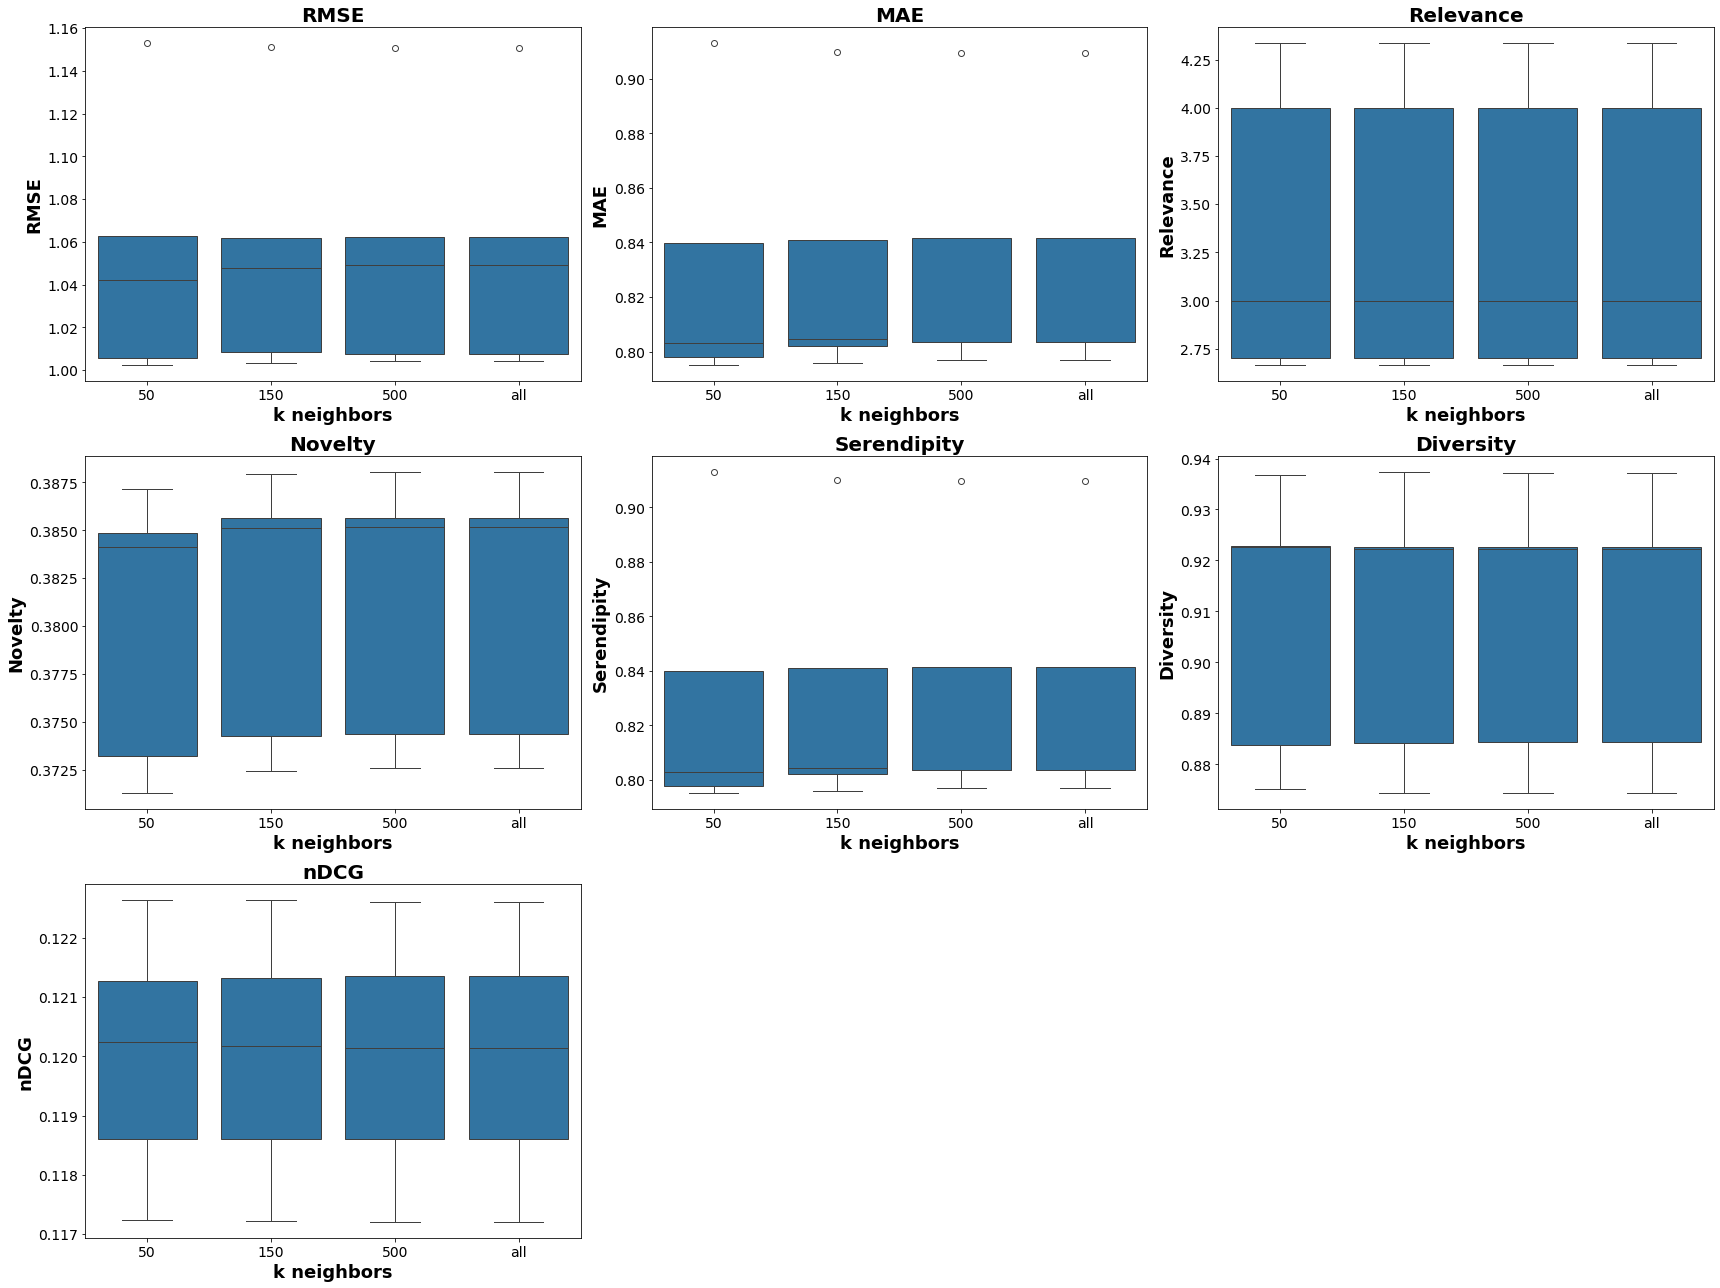

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)

# Renombrar columna si es necesario
df_box = df_box.rename(columns={'nDCG@20': 'nDCG'})

metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Configuración
k_values = [50, 150, 500, None]  # Número de vecinos (None = all)
final_results = []
all_folds_metrics = []

# ⚠️ Asegúrate de que 'folds' esté definido como lista de (train_df, test_df)

def compute_cosine_similarity(R_train):
    R_train_filled = np.nan_to_num(R_train)
    similarity_matrix = cosine_similarity(R_train_filled)
    np.fill_diagonal(similarity_matrix, 0)
    return similarity_matrix

def predict_user_ratings(u, R_train, similarity_matrix, user_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [v for v in range(R_train.shape[0]) if not np.isnan(R_train[v, j]) and v != u]
            if not neighbors:
                predictions[j] = user_means[u]
                continue
            sims = [(v, similarity_matrix[u, v]) for v in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * R_train[v, j] for v, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = user_means[u] if denom == 0 else num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        user_means = np.array([
            np.nanmean(R_train[u]) if np.any(~np.isnan(R_train[u])) else 0
            for u in range(num_users)
        ])

        similarity_matrix = compute_cosine_similarity(R_train)

        print("🔮 Prediciendo ratings...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_ratings)(u, R_train, similarity_matrix, user_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        novelty_list = []
        relevance_list = []

        for u in range(num_users):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                continue
            top_20_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_u = np.mean([item_popularity_inv[j] for j in top_20_items])
            novelty_list.append(novelty_u)
            rel = [R_test[u, j] for j in top_20_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(relevances):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

        def ndcg_at_k(u, k="all"):
            known_train_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_train_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
            top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
            dcg_score = dcg(rel_pred)
            actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
            if not actual_ratings:
                return np.nan
            actual_ratings.sort(key=lambda x: x[1], reverse=True)
            ideal_rel = [r for _, r in actual_ratings[:k_val]]
            ideal_dcg = dcg(ideal_rel)
            return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

        ndcg_list = [ndcg_at_k(u, k="all") for u in range(num_users)]
        ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
        ndcg_score = np.mean(ndcg_list)

        fold_result = {
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG@20": ndcg_score,
            "k_neighbors": "all" if k is None else k,
            "Model": "Memory-based CF",
            "Similarity": "Cosine"
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Memory-based CF",
        "k_neighbors": "all" if k is None else k,
        "Similarity": "Cosine"
    })
    final_results.append(avg_metrics)

# Mostrar resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[['k_neighbors', 'RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG@20']])


🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:48<00:00,  1.60it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:51<00:00,  1.59it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:50<00:00,  1.60it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:53<00:00,  1.59it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:58<00:00,  1.57it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:54<00:00,  1.59it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = 500

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:56<00:00,  1.58it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:59<00:00,  1.57it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 2
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



▶️ Fold 3
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [10:00<00:00,  1.57it/s]



▶️ Fold 4
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:57<00:00,  1.58it/s]



▶️ Fold 5
🔮 Prediciendo ratings...


Usuarios: 100%|██████████| 943/943 [09:55<00:00,  1.58it/s]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          50  1.172490  0.934660   4.136667  0.268663     0.934660   
1         150  1.176081  0.938351   4.033333  0.275050     0.938351   
2         500  1.176160  0.938429   3.940000  0.277423     0.938429   
3         all  1.176155  0.938427   3.940000  0.277453     0.938427   

   Diversity   nDCG@20  
0   0.881108  0.117190  
1   0.882417  0.118659  
2   0.883686  0.118663  
3   0.883658  0.118663  


In [17]:
results_table

,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG@20,k_neighbors,Model,Similarity
0,1.172490,0.934660,0.268663,4.136667,0.934660,0.881108,0.117190,50,Memory-based CF,Cosine
1,1.176081,0.938351,0.275050,4.033333,0.938351,0.882417,0.118659,150,Memory-based CF,Cosine
2,1.176160,0.938429,0.277423,3.940000,0.938429,0.883686,0.118663,500,Memory-based CF,Cosine
3,1.176155,0.938427,0.277453,3.940000,0.938427,0.883658,0.118663,all,Memory-based CF,Cosine


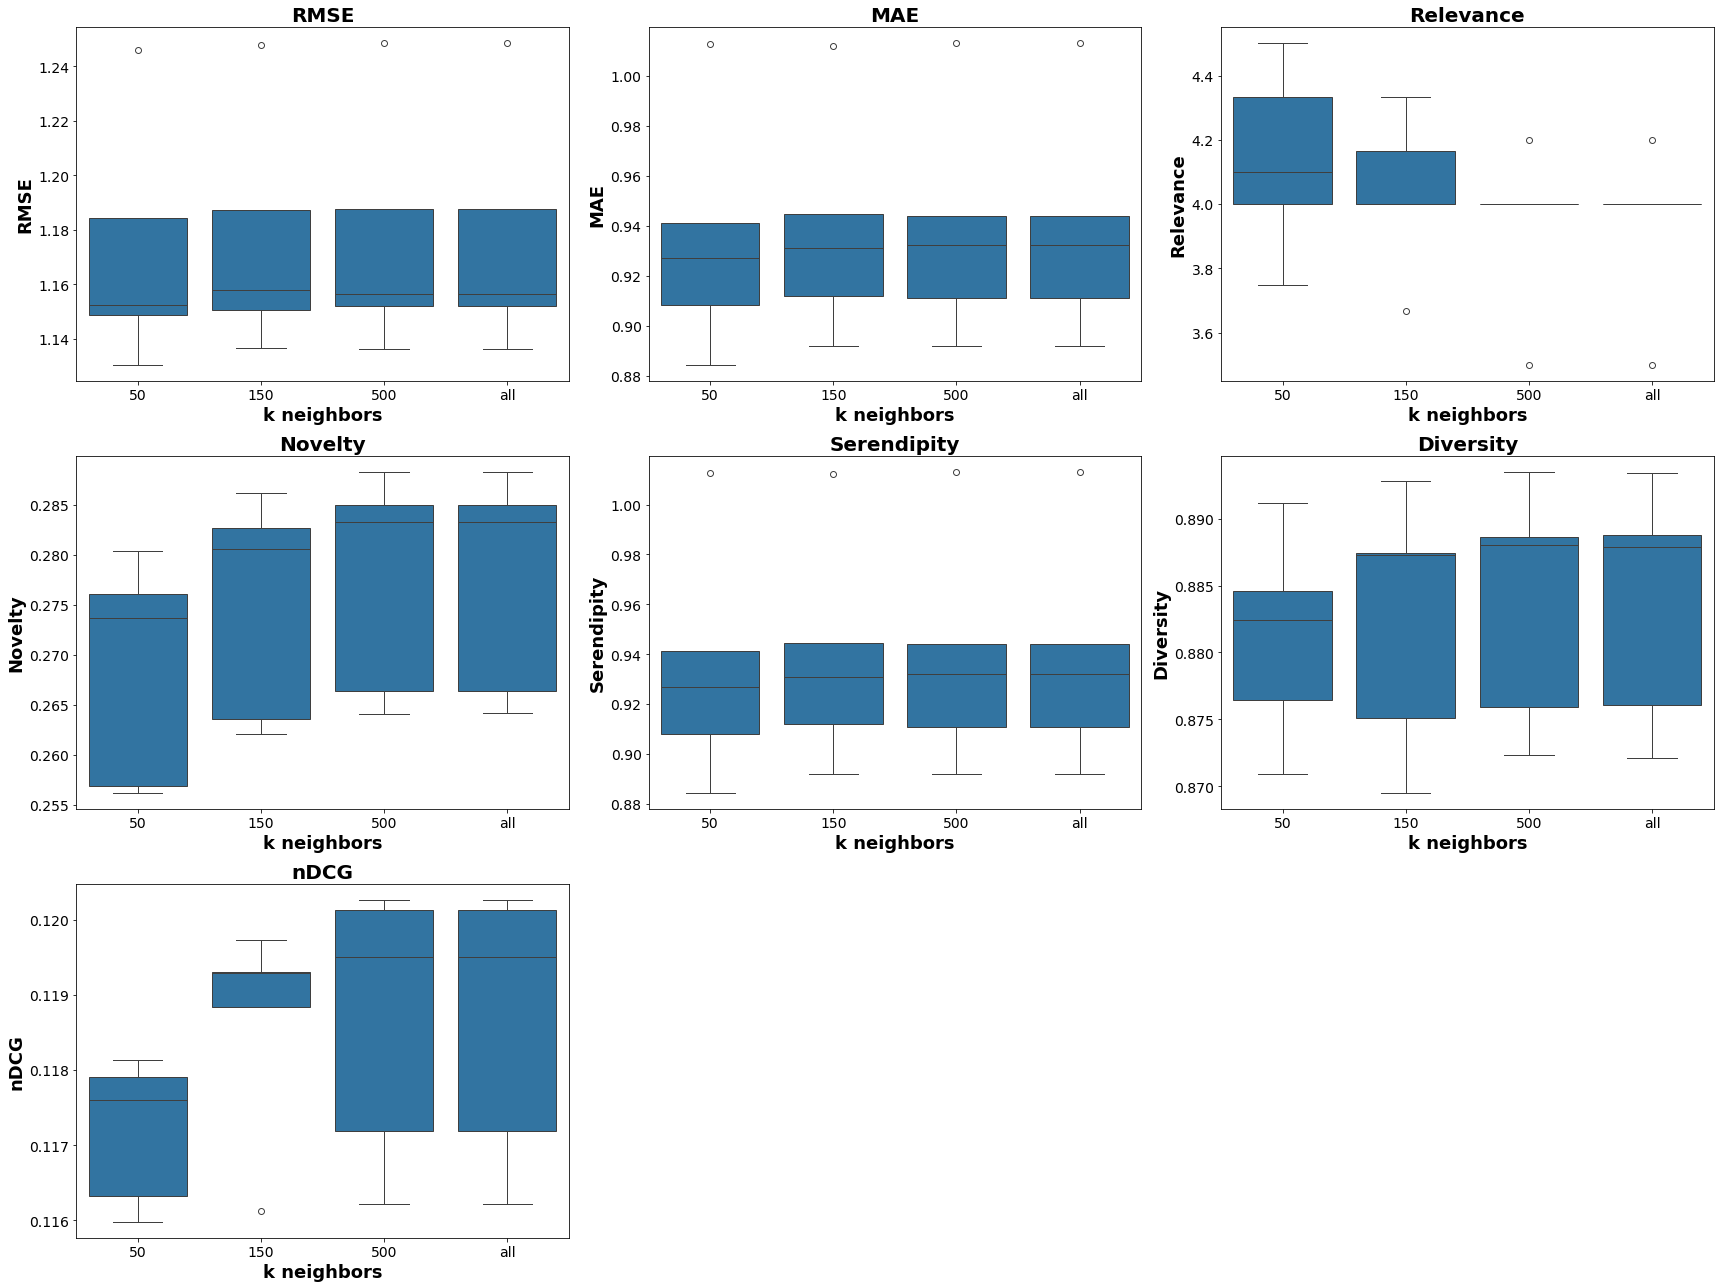

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)

# Renombrar columna si es necesario
df_box = df_box.rename(columns={'nDCG@20': 'nDCG'})

metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### <font color="blue"> **Collaborative Filtering:** iten Neighborhood models</font>

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Configuración
k_values = [20, 50, 150, None]
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

def predict_user_row(u, R_train, item_similarity, item_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [i for i in range(num_items) if not np.isnan(R_train[u, i]) and i != j]
            if not neighbors:
                predictions[j] = item_means[j]
                continue
            sims = [(i, item_similarity[j, i]) for i in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[u, i] - item_means[i]) for i, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = item_means[j] if denom == 0 else item_means[j] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        item_means = np.array([
            np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0
            for j in range(num_items)
        ])

        R_train_filled = np.nan_to_num(R_train)
        item_similarity = cosine_similarity(R_train_filled.T)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        print("🔮 Prediciendo ratings en paralelo...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_row)(u, R_train, item_similarity, item_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        novelty_list, relevance_list = [], []
        for u in range(num_users):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                continue
            top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_list.append(np.mean([item_popularity_inv[j] for j in top_items]))
            rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(rels):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

        def ndcg(u):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
            dcg_score = dcg(rel_pred)
            ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
            idcg = dcg(ideal)
            return dcg_score / idcg if idcg > 0 else 0

        ndcg_scores = [ndcg(u) for u in range(num_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        ndcg = np.mean(ndcg_scores)

        fold_result = {
            "Model": "Item-based CF",
            "Similarity": "Cosine",
            "k_neighbors": "all" if k is None else k,
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG": ndcg
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Item-based CF",
        "Similarity": "Cosine",
        "k_neighbors": "all" if k is None else k
    })
    final_results.append(avg_metrics)

# 📊 Resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[["k_neighbors", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG"]])


🔁 Ejecutando 5-Fold CV para k = 20

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:27<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:19<00:00,  1.10s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:15<00:00,  1.10s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:16<00:00,  1.10s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:28<00:00,  1.11s/it]



🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:39<00:00,  1.12s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:34<00:00,  1.12s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:34<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:19<00:00,  1.10s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:20<00:00,  1.10s/it]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:48<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:51<00:00,  1.14s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:39<00:00,  1.12s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:39<00:00,  1.12s/it]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:45<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:49<00:00,  1.13s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:42<00:00,  1.13s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:46<00:00,  1.13s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:57<00:00,  1.14s/it]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          20  1.253592  0.945124   4.221667  0.279318     0.945124   
1          50  1.262350  0.956551   4.241667  0.285100     0.956551   
2         150  1.272661  0.968471   4.101667  0.286916     0.968471   
3         all  1.275688  0.971373   4.060000  0.287416     0.971373   

   Diversity      nDCG  
0   0.943571  0.029230  
1   0.936910  0.029092  
2   0.933476  0.029282  
3   0.933886  0.029359  


In [38]:
results_table

,k_neighbors,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG,Model,Similarity
0,20,1.253592,0.945124,0.279318,4.221667,0.945124,0.943571,0.029230,Item-based CF,Cosine
1,50,1.262350,0.956551,0.285100,4.241667,0.956551,0.936910,0.029092,Item-based CF,Cosine
2,150,1.272661,0.968471,0.286916,4.101667,0.968471,0.933476,0.029282,Item-based CF,Cosine
3,all,1.275688,0.971373,0.287416,4.060000,0.971373,0.933886,0.029359,Item-based CF,Cosine


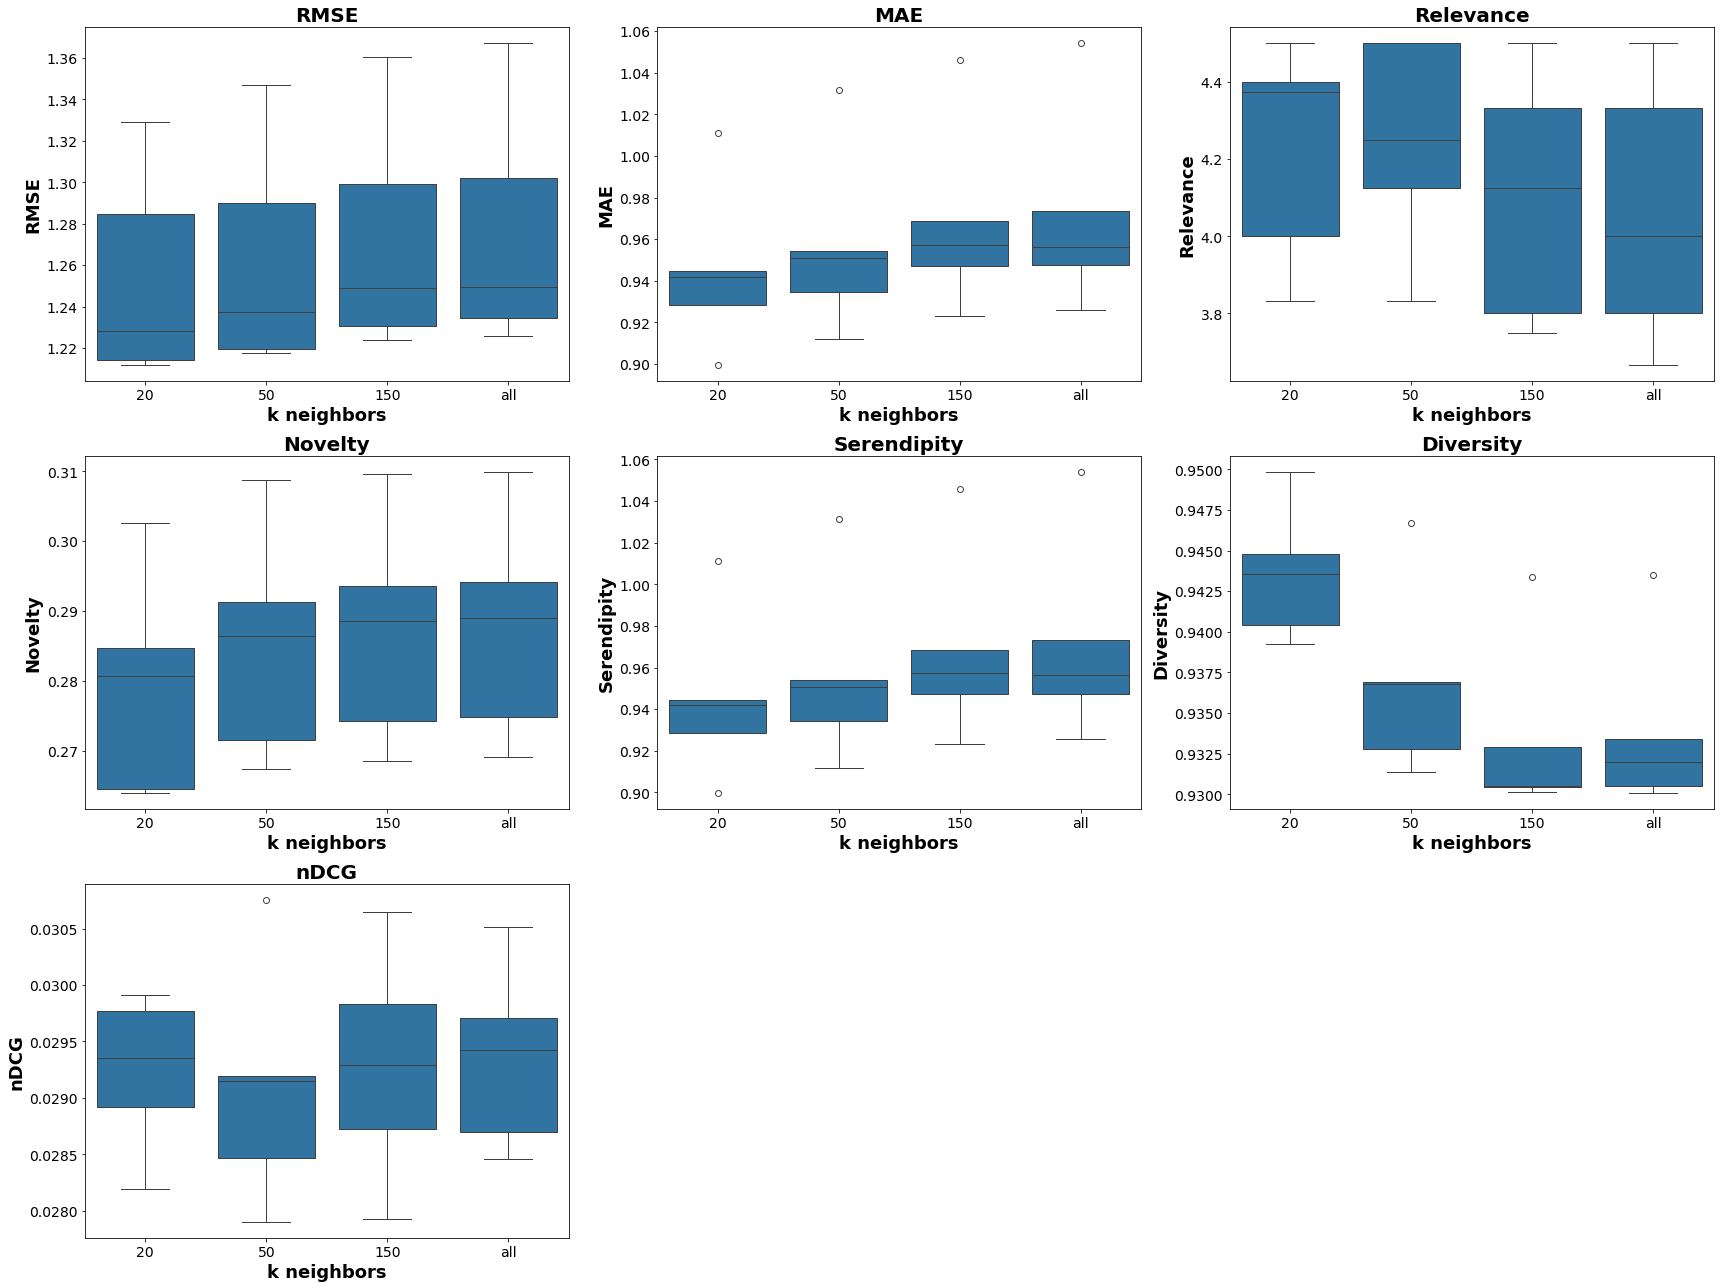

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from joblib import Parallel, delayed

# ⚙️ Configuración
k_values = [20, 50, 150, None]
final_results = []
all_folds_metrics = []  # Para almacenar resultados por fold

def compute_adjusted_cosine_similarity(R_train):
    num_users, num_items = R_train.shape
    user_means = np.array([np.nanmean(R_train[u, :]) if np.any(~np.isnan(R_train[u, :])) else 0 for u in range(num_users)])
    R_train_centered = np.copy(R_train)
    for u in range(num_users):
        for j in range(num_items):
            if not np.isnan(R_train[u, j]):
                R_train_centered[u, j] -= user_means[u]
            else:
                R_train_centered[u, j] = 0
    return cosine_similarity(R_train_centered.T)

def predict_user_row(u, R_train, item_similarity, item_means, k):
    num_items = R_train.shape[1]
    predictions = np.copy(R_train[u])
    for j in range(num_items):
        if np.isnan(R_train[u, j]):
            neighbors = [i for i in range(num_items) if not np.isnan(R_train[u, i]) and i != j]
            if not neighbors:
                predictions[j] = item_means[j]
                continue
            sims = [(i, item_similarity[j, i]) for i in neighbors]
            sims.sort(key=lambda x: abs(x[1]), reverse=True)
            if k is not None:
                sims = sims[:k]
            num = sum(sim * (R_train[u, i] - item_means[i]) for i, sim in sims)
            denom = sum(abs(sim) for _, sim in sims)
            predictions[j] = item_means[j] if denom == 0 else item_means[j] + num / denom
    return predictions

for k in k_values:
    print(f"\n🔁 Ejecutando 5-Fold CV para k = {k if k is not None else 'all'}")
    fold_metrics = []

    for fold_num, (train_matrix, test_matrix) in enumerate(folds):
        print(f"\n▶️ Fold {fold_num + 1}")
        R_train = train_matrix.values
        R_test = test_matrix.values
        num_users, num_items = R_train.shape

        item_means = np.array([
            np.nanmean(R_train[:, j]) if np.any(~np.isnan(R_train[:, j])) else 0
            for j in range(num_items)
        ])

        # Calcular adjusted cosine similarity
        item_similarity = compute_adjusted_cosine_similarity(R_train)

        item_popularity = np.sum(~np.isnan(R_train), axis=0)
        item_popularity_inv = 1 / (item_popularity + 1)

        print("🔮 Prediciendo ratings en paralelo...")
        R_pred_rows = Parallel(n_jobs=-1)(
            delayed(predict_user_row)(u, R_train, item_similarity, item_means, k)
            for u in tqdm(range(num_users), desc="Usuarios")
        )
        R_pred = np.vstack(R_pred_rows)

        predicted, actual = [], []
        test_indices = list(zip(*np.where(~np.isnan(R_test))))
        for u, j in test_indices:
            predicted.append(R_pred[u, j])
            actual.append(R_test[u, j])

        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)

        novelty_list, relevance_list = [], []
        for u in range(num_users):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                continue
            top_items = unknown_items[np.argsort(R_pred[u, unknown_items])[-20:]]
            novelty_list.append(np.mean([item_popularity_inv[j] for j in top_items]))
            rel = [R_test[u, j] for j in top_items if not np.isnan(R_test[u, j])]
            if rel:
                relevance_list.append(np.mean(rel))

        novelty = np.mean(novelty_list)
        relevance = np.mean(relevance_list)

        serendipity_scores = [abs(R_pred[u, j] - R_test[u, j]) for u, j in test_indices if np.isnan(R_train[u, j])]
        serendipity = np.mean(serendipity_scores)

        diversity_scores = []
        for u in range(num_users):
            top_5 = np.argsort(R_pred[u, :])[-5:]
            div = 0
            count = 0
            for i in range(len(top_5)):
                for j2 in range(i + 1, len(top_5)):
                    div += 1 - item_similarity[top_5[i], top_5[j2]]
                    count += 1
            diversity_scores.append(div / count if count > 0 else 0)
        diversity = np.mean(diversity_scores)

        def dcg(rels):
            return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

        def ndcg(u):
            known_items = ~np.isnan(R_train[u])
            unknown_items = np.where(~known_items)[0]
            if len(unknown_items) == 0:
                return np.nan
            top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[-len(unknown_items):]]
            rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
            dcg_score = dcg(rel_pred)
            ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
            idcg = dcg(ideal)
            return dcg_score / idcg if idcg > 0 else 0

        ndcg_scores = [ndcg(u) for u in range(num_users)]
        ndcg_scores = [x for x in ndcg_scores if not np.isnan(x)]
        ndcg = np.mean(ndcg_scores)

        fold_result = {
            "Model": "Item-based CF",
            "Similarity": "Adjusted Cosine",
            "k_neighbors": "all" if k is None else k,
            "RMSE": rmse,
            "MAE": mae,
            "Novelty": novelty,
            "Relevance": relevance,
            "Serendipity": serendipity,
            "Diversity": diversity,
            "nDCG": ndcg
        }

        fold_metrics.append(fold_result)
        all_folds_metrics.append(fold_result)

    avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    avg_metrics.update({
        "Model": "Item-based CF",
        "Similarity": "Adjusted Cosine",
        "k_neighbors": "all" if k is None else k
    })
    final_results.append(avg_metrics)

# 📊 Resultados medios
results_table = pd.DataFrame(final_results)
print("\n📊 RESULTADOS PROMEDIO POR k:")
print(results_table[["k_neighbors", "RMSE", "MAE", "Relevance", "Novelty", "Serendipity", "Diversity", "nDCG"]])


🔁 Ejecutando 5-Fold CV para k = 20

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:23<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:26<00:00,  1.11s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:23<00:00,  1.11s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:22<00:00,  1.11s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:34<00:00,  1.12s/it]



🔁 Ejecutando 5-Fold CV para k = 50

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:30<00:00,  1.11s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:25<00:00,  1.11s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:31<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:31<00:00,  1.11s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:28<00:00,  1.11s/it]



🔁 Ejecutando 5-Fold CV para k = 150

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:38<00:00,  1.12s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:50<00:00,  1.14s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:33<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:43<00:00,  1.13s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:38<00:00,  1.12s/it]



🔁 Ejecutando 5-Fold CV para k = all

▶️ Fold 1
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:44<00:00,  1.13s/it]



▶️ Fold 2
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:43<00:00,  1.13s/it]



▶️ Fold 3
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:35<00:00,  1.12s/it]



▶️ Fold 4
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:40<00:00,  1.12s/it]



▶️ Fold 5
🔮 Prediciendo ratings en paralelo...


Usuarios: 100%|██████████| 943/943 [17:46<00:00,  1.13s/it]



📊 RESULTADOS PROMEDIO POR k:
  k_neighbors      RMSE       MAE  Relevance   Novelty  Serendipity  \
0          20  1.325368  1.012868   3.940000  0.271873     1.012868   
1          50  1.321781  1.014278   4.130952  0.283959     1.014278   
2         150  1.328088  1.023970   4.219048  0.287159     1.023970   
3         all  1.330961  1.027703   4.200000  0.287294     1.027703   

   Diversity      nDCG  
0   0.988432  0.029331  
1   0.988413  0.029710  
2   0.988322  0.029451  
3   0.988325  0.029565  


In [41]:
results_table

,k_neighbors,RMSE,MAE,Novelty,Relevance,Serendipity,Diversity,nDCG,Model,Similarity
0,20,1.325368,1.012868,0.271873,3.940000,1.012868,0.988432,0.029331,Item-based CF,Adjusted Cosine
1,50,1.321781,1.014278,0.283959,4.130952,1.014278,0.988413,0.029710,Item-based CF,Adjusted Cosine
2,150,1.328088,1.023970,0.287159,4.219048,1.023970,0.988322,0.029451,Item-based CF,Adjusted Cosine
3,all,1.330961,1.027703,0.287294,4.200000,1.027703,0.988325,0.029565,Item-based CF,Adjusted Cosine


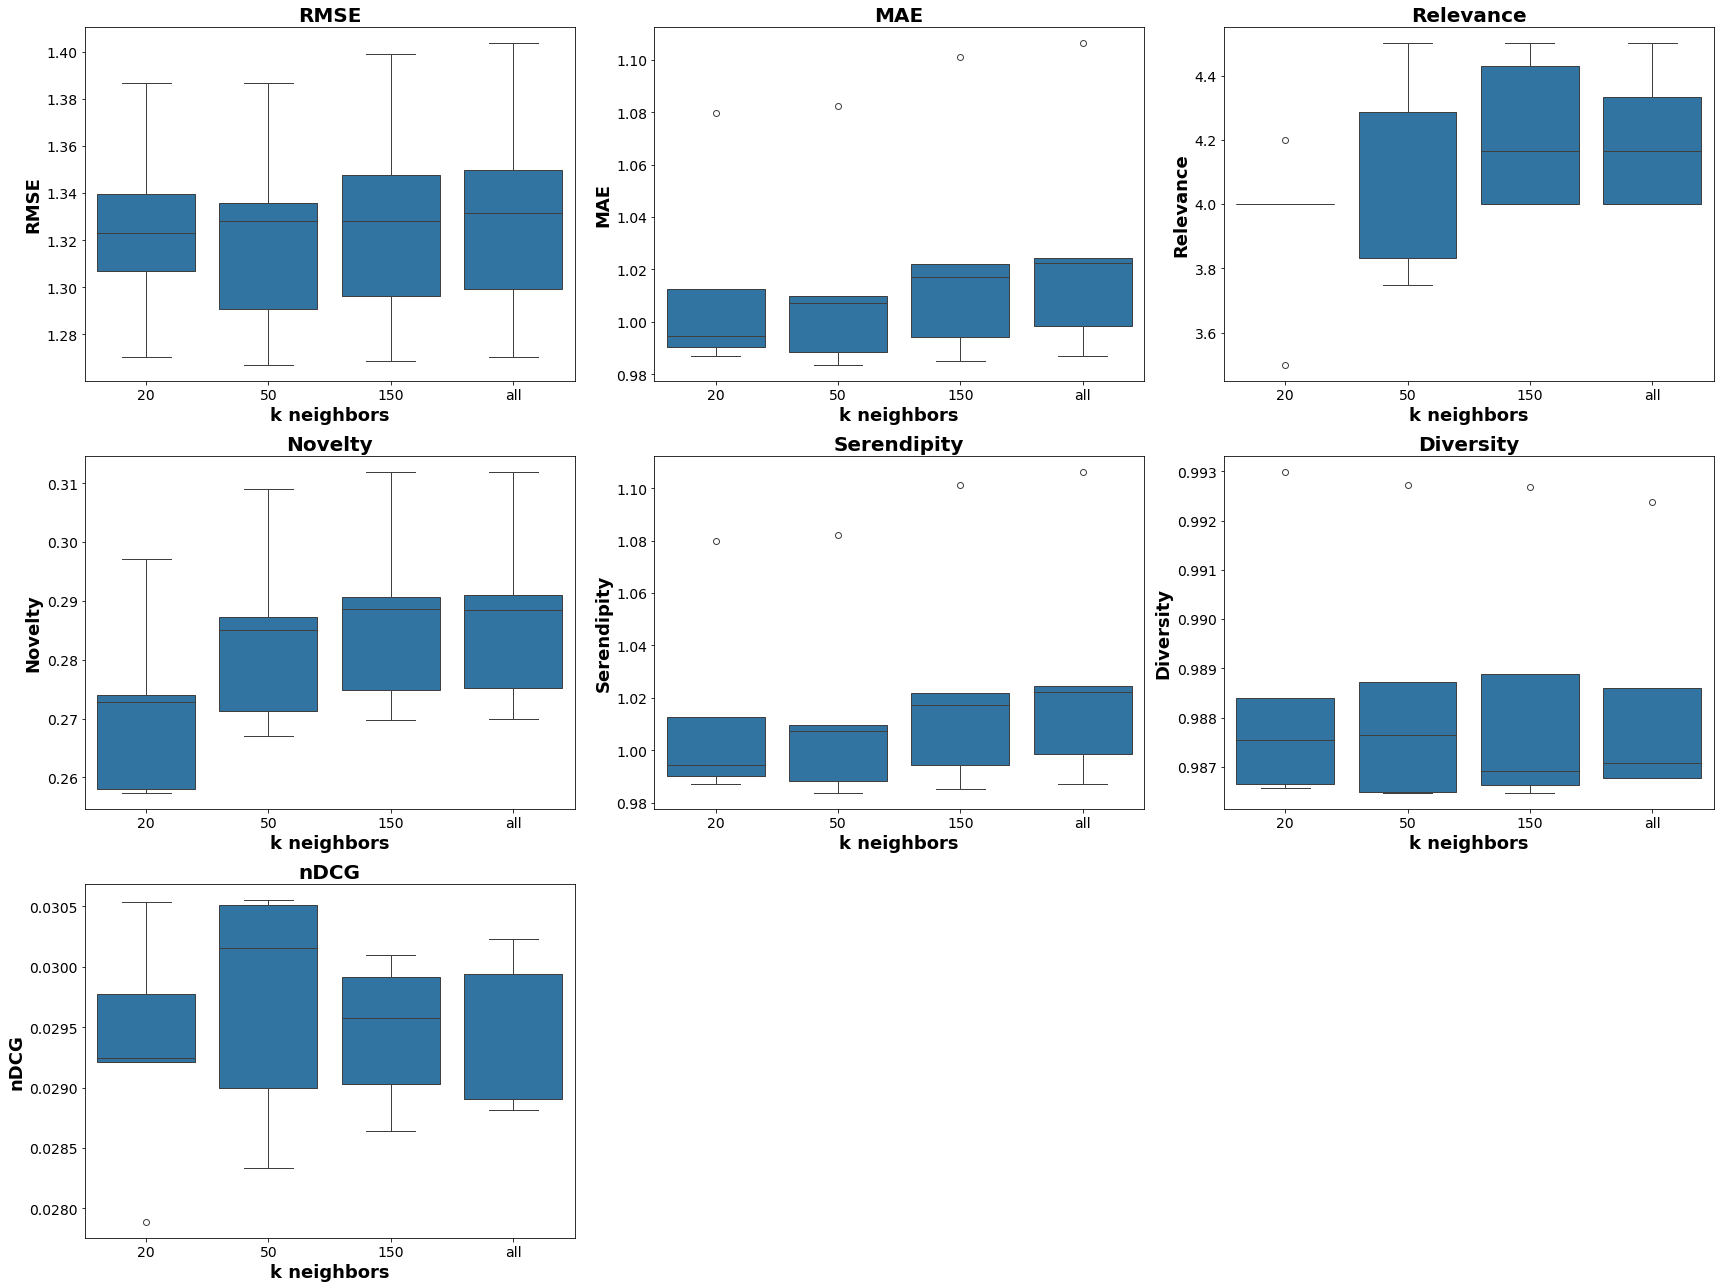

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📈 Boxplots por fold con títulos y ejes más grandes y en negrita
df_box = pd.DataFrame(all_folds_metrics)
metrics = ['RMSE', 'MAE', 'Relevance', 'Novelty', 'Serendipity', 'Diversity', 'nDCG']

plt.figure(figsize=(24, 18))  # Más grande
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='k_neighbors', y=metric, data=df_box)
    plt.title(metric, fontsize=20, fontweight='bold')             # Título más grande
    plt.xlabel('k neighbors', fontsize=18, fontweight='bold')     # Eje x más grande
    plt.ylabel(metric, fontsize=18, fontweight='bold')            # Eje y más grande
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

In [81]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from math import sqrt

# ========== MATRICES ORIGINALES ==========
R_original = ratings_matrix.values

# ========== HIPERPARÁMETROS ==========
k_values = [3, 5, 10, 20]
alpha_values = [0.001, 0.005]
lambda_values = [0.01, 0.05]

final_results = []
all_folds_metrics = []  # Para resultados por fold

# ========== FUNCIÓN DE FACTORIZACIÓN ==========
def matrix_factorization(R, k, steps, alpha, lambda_reg):
    m, n = R.shape
    U = np.random.randn(m, k) * 0.01
    V = np.random.randn(n, k) * 0.01

    for step in tqdm(range(steps), desc=f"🔧 k={k} α={alpha} λ={lambda_reg}", leave=False):
        for i in range(m):
            for j in range(n):
                if np.isnan(R[i, j]):
                    continue
                pred = np.dot(U[i], V[j])
                err = R[i, j] - pred
                for r in range(k):
                    U[i, r] += alpha * (err * V[j, r] - lambda_reg * U[i, r])
                    V[j, r] += alpha * (err * U[i, r] - lambda_reg * V[j, r])
    return U, V

# ========== FUNCIONES AUXILIARES ==========
def dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

def ndcg_at_k(u, R_pred, R_train, R_test, k="all"):
    known_train_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_train_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    k_val = len(unknown_items) if k == "all" else min(k, len(unknown_items))
    top_k_pred = unknown_items[np.argsort(R_pred[u, unknown_items])[-k_val:]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k_pred]
    dcg_score = dcg(rel_pred)
    actual_ratings = [(j, R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
    if not actual_ratings:
        return np.nan
    actual_ratings.sort(key=lambda x: x[1], reverse=True)
    ideal_rel = [r for _, r in actual_ratings[:k_val]]
    ideal_dcg = dcg(ideal_rel)
    return dcg_score / ideal_dcg if ideal_dcg > 0 else 0

# ========== CROSS VALIDATION ==========
for k in k_values:
    for alpha in alpha_values:
        for lambda_reg in lambda_values:
            print(f"\n🔁 Ejecutando 5-Fold CV para k={k}, alpha={alpha}, lambda={lambda_reg}")
            fold_metrics = []

            for fold_num, (train_matrix, test_matrix) in enumerate(folds):
                print(f"\n▶️ Fold {fold_num + 1}")
                R_train = train_matrix.values
                R_test = test_matrix.values
                test_mask = ~np.isnan(R_test)
                test_indices = list(zip(*np.where(test_mask)))

                start_time = time.time()
                U, V = matrix_factorization(R_train, k=k, steps=100, alpha=alpha, lambda_reg=lambda_reg)
                end_time = time.time()
                training_time = end_time - start_time

                R_pred = np.dot(U, V.T)

                # ===== MÉTRICAS BÁSICAS =====
                actual = [R_original[i, j] for i, j in test_indices]
                predicted = [R_pred[i, j] for i, j in test_indices]
                rmse = sqrt(mean_squared_error(actual, predicted))
                mae = mean_absolute_error(actual, predicted)

                # ===== MÉTRICAS ADICIONALES =====
                item_popularity = np.nansum(~np.isnan(R_train), axis=0)
                item_popularity_inv = 1 / (item_popularity + 1e-10)

                novelty_list = []
                relevance_list = []

                for u in range(R_train.shape[0]):
                    known_train_items = ~np.isnan(R_train[u])
                    unknown_items = np.where(~known_train_items)[0]
                    if len(unknown_items) == 0:
                        continue
                    user_preds = R_pred[u, unknown_items]
                    top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]
                    novelty_u = np.mean(item_popularity_inv[top_20_idx])
                    novelty_list.append(novelty_u)
                    rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                    if rel_ratings:
                        relevance_list.append(np.mean(rel_ratings))

                novelty = np.mean(novelty_list) if novelty_list else np.nan
                relevance = np.mean(relevance_list) if relevance_list else np.nan

                # === SERENDIPITY ===
                serendipity_scores = [abs(R_pred[u, j] - R_test[u, j])
                                      for u, j in zip(*np.where(test_mask))
                                      if np.isnan(R_train[u, j])]
                serendipity = np.mean(serendipity_scores) if serendipity_scores else np.nan

                # === DIVERSITY ===
                R_train_filled = np.nan_to_num(R_train)
                item_similarity = cosine_similarity(R_train_filled.T)

                diversity_scores = []
                for u in range(R_train.shape[0]):
                    top_5_items = np.argsort(R_pred[u, :])[-5:]
                    count = 0
                    diversity = 0
                    for i in range(len(top_5_items)):
                        for j2 in range(i + 1, len(top_5_items)):
                            diversity += 1 - item_similarity[top_5_items[i], top_5_items[j2]]
                            count += 1
                    diversity_scores.append(diversity / count if count > 0 else 0)

                diversity = np.mean(diversity_scores)

                # === NDCG ===
                ndcg_list = [ndcg_at_k(u, R_pred, R_train, R_test, k="all") for u in range(R_train.shape[0])]
                ndcg_list = [x for x in ndcg_list if not np.isnan(x)]
                ndcg_score = np.mean(ndcg_list)

                fold_result = {
                    "Latent Factors (k)": k,
                    "Alpha": alpha,
                    "Lambda": lambda_reg,
                    "Training Time (s)": training_time,
                    "RMSE": rmse,
                    "MAE": mae,
                    "Diversity": diversity,
                    "Novelty": novelty,
                    "Serendipity": serendipity,
                    "Relevance": relevance,
                    "nDCG": ndcg_score
                }

                fold_metrics.append(fold_result)
                all_folds_metrics.append(fold_result)

            avg_metrics = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
            avg_metrics.update({
                "Latent Factors (k)": k,
                "Alpha": alpha,
                "Lambda": lambda_reg
            })
            final_results.append(avg_metrics)

# ========== MOSTRAR RESULTADOS ==========
results_df = pd.DataFrame(final_results)
print("\n✅ Resultados promedio por configuración:")
display(results_df.sort_values(by="RMSE"))


🔁 Ejecutando 5-Fold CV para k=3, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=3, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=5, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=10, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.001, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.001, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.005, lambda=0.01

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



🔁 Ejecutando 5-Fold CV para k=20, alpha=0.005, lambda=0.05

▶️ Fold 1



▶️ Fold 2



▶️ Fold 3



▶️ Fold 4



▶️ Fold 5



✅ Resultados promedio por configuración:


,Latent Factors (k),Alpha,Lambda,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
3,3,0.005,0.05,320.334690,1.260921,0.940764,0.870764,0.142187,0.940764,4.010556,0.125318
11,10,0.005,0.05,445.323070,1.261191,0.938466,0.782356,0.108094,0.938466,4.266667,0.123795
7,5,0.005,0.05,365.213593,1.262764,0.941734,0.828831,0.128470,0.941734,4.038175,0.126110
2,3,0.005,0.01,320.008567,1.266814,0.941749,0.834439,0.120437,0.941749,3.971349,0.124931
15,20,0.005,0.05,606.438696,1.269106,0.947966,0.752059,0.092106,0.947966,4.365152,0.124240
6,5,0.005,0.01,367.076739,1.280366,0.956592,0.767532,0.091959,0.956592,3.990188,0.125163
10,10,0.005,0.01,445.685572,1.305305,0.971456,0.730486,0.058423,0.971456,3.952976,0.124483
14,20,0.005,0.01,606.197505,1.309091,0.977212,0.704027,0.032146,0.977212,4.088889,0.124385
12,20,0.001,0.01,606.435487,1.391453,1.047813,0.667850,0.015173,1.047813,4.097143,0.126331
8,10,0.001,0.01,446.109577,1.394878,1.050910,0.672023,0.015269,1.050910,4.232821,0.125639


In [82]:
results_df

,Latent Factors (k),Alpha,Lambda,Training Time (s),RMSE,MAE,Diversity,Novelty,Serendipity,Relevance,nDCG
0,3,0.001,0.01,318.889748,1.398059,1.054264,0.686111,0.015575,1.054264,4.328586,0.125007
1,3,0.001,0.05,320.174659,1.405331,1.061620,0.612284,0.015297,1.061620,4.327633,0.125643
2,3,0.005,0.01,320.008567,1.266814,0.941749,0.834439,0.120437,0.941749,3.971349,0.124931
3,3,0.005,0.05,320.334690,1.260921,0.940764,0.870764,0.142187,0.940764,4.010556,0.125318
4,5,0.001,0.01,367.303457,1.396210,1.052933,0.683766,0.015524,1.052933,4.170050,0.125119
5,5,0.001,0.05,366.527924,1.404001,1.060760,0.672548,0.015290,1.060760,4.325411,0.125768
6,5,0.005,0.01,367.076739,1.280366,0.956592,0.767532,0.091959,0.956592,3.990188,0.125163
7,5,0.005,0.05,365.213593,1.262764,0.941734,0.828831,0.128470,0.941734,4.038175,0.126110
8,10,0.001,0.01,446.109577,1.394878,1.050910,0.672023,0.015269,1.050910,4.232821,0.125639
9,10,0.001,0.05,446.232528,1.402331,1.058644,0.683529,0.015213,1.058644,4.323333,0.126329


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import time
from sklearn.metrics.pairwise import cosine_similarity

def svd_iterative_fill(R, k=3, steps=20):
    R = R.copy()
    user_means = np.nanmean(R, axis=1)
    R_centered = R - user_means[:, np.newaxis]
    R_centered[np.isnan(R_centered)] = 0

    for _ in range(steps):
        U, S, Vt = np.linalg.svd(R_centered, full_matrices=False)
        S = np.diag(S[:k])
        U = U[:, :k]
        Vt = Vt[:k, :]
        R_hat = U @ S @ Vt
        R_centered[np.isnan(R)] = R_hat[np.isnan(R)]

    R_final = R_centered + user_means[:, np.newaxis]
    return R_final

# Funciones para métricas adicionales
def dcg(rels):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))

def ndcg(u, R_train, R_pred, R_test):
    known_items = ~np.isnan(R_train[u])
    unknown_items = np.where(~known_items)[0]
    if len(unknown_items) == 0:
        return np.nan
    # ordenamos todos los desconocidos por predicción (toma todo, no top-K)
    top_k = unknown_items[np.argsort(R_pred[u, unknown_items])[::-1]]
    rel_pred = [R_test[u, j] if not np.isnan(R_test[u, j]) else 0 for j in top_k]
    dcg_score = dcg(rel_pred)
    ideal = sorted([R_test[u, j] for j in unknown_items if not np.isnan(R_test[u, j])], reverse=True)
    idcg = dcg(ideal)
    return dcg_score / idcg if idcg > 0 else 0

results = []
# Valores a probar
k_values = [3, 5, 10]
step_values = [20, 50, 100]

results = []

for k in k_values:
    for steps in step_values:
        print(f"\n🔁 Ejecutando SVD iterativo con k={k}, steps={steps}")
        rmse_list, mae_list = [], []
        novelty_list, relevance_list, serendipity_list, diversity_list, ndcg_list = [], [], [], [], []

        for fold_num, (train_matrix, test_matrix) in enumerate(folds):
            print(f"▶️ Fold {fold_num + 1}")
            R_train = train_matrix.values
            R_test = test_matrix.values
            test_mask = ~np.isnan(R_test)
            test_indices = list(zip(*np.where(test_mask)))
            n_users, n_items = R_train.shape

            start_time = time.time()
            R_pred = svd_iterative_fill(R_train, k=k, steps=steps)
            end_time = time.time()

            actual = [R_test[i, j] for i, j in test_indices]
            predicted = [R_pred[i, j] for i, j in test_indices]
            rmse = sqrt(mean_squared_error(actual, predicted))
            mae = mean_absolute_error(actual, predicted)

            item_popularity = np.sum(~np.isnan(R_train), axis=0)
            item_popularity_inv = 1 / (item_popularity + 1)

            novelty_fold, relevance_fold, serendipity_fold, ndcg_fold = [], [], [], []
            R_train_filled = np.nan_to_num(R_train)
            item_similarity = cosine_similarity(R_train_filled.T)
            diversity_fold = []

            for u in range(n_users):
                known_train_items = ~np.isnan(R_train[u])
                unknown_items = np.where(~known_train_items)[0]
                if len(unknown_items) == 0:
                    continue

                user_preds = R_pred[u, unknown_items]
                top_20_idx = unknown_items[np.argsort(user_preds)[-20:]]

                novelty_u = np.mean(item_popularity_inv[top_20_idx])
                novelty_fold.append(novelty_u)

                rel_ratings = [R_test[u, j] for j in top_20_idx if not np.isnan(R_test[u, j])]
                if rel_ratings:
                    relevance_fold.append(np.mean(rel_ratings))

                ser_scores = [abs(R_pred[u, j] - R_test[u, j]) for j in unknown_items if not np.isnan(R_test[u, j])]
                if ser_scores:
                    serendipity_fold.append(np.mean(ser_scores))

                ndcg_u = ndcg(u, R_train, R_pred, R_test)
                if not np.isnan(ndcg_u):
                    ndcg_fold.append(ndcg_u)

                top_5_items = np.argsort(R_pred[u, :])[-5:]
                count, diversity = 0, 0
                for i1 in range(len(top_5_items)):
                    for i2 in range(i1 + 1, len(top_5_items)):
                        diversity += 1 - item_similarity[top_5_items[i1], top_5_items[i2]]
                        count += 1
                diversity_fold.append(diversity / count if count > 0 else 0)

            rmse_list.append(rmse)
            mae_list.append(mae)
            novelty_list.append(np.mean(novelty_fold) if novelty_fold else np.nan)
            relevance_list.append(np.mean(relevance_fold) if relevance_fold else np.nan)
            serendipity_list.append(np.mean(serendipity_fold) if serendipity_fold else np.nan)
            diversity_list.append(np.mean(diversity_fold) if diversity_fold else np.nan)
            ndcg_list.append(np.mean(ndcg_fold) if ndcg_fold else np.nan)

            print(f"  Fold RMSE: {rmse:.4f}, MAE: {mae:.4f}, Time: {end_time - start_time:.2f}s")

        results.append({
            "Latent Factors (k)": k,
            "Steps": steps,
            "Avg RMSE": np.mean(rmse_list),
            "Avg MAE": np.mean(mae_list),
            "Avg Novelty": np.mean(novelty_list),
            "Avg Relevance": np.mean(relevance_list),
            "Avg Serendipity": np.mean(serendipity_list),
            "Avg Diversity": np.mean(diversity_list),
            "Avg nDCG": np.mean(ndcg_list)
        })

results_df = pd.DataFrame(results)
print("\n✅ Resultados promedio por configuración:")
print(results_df.sort_values(by=["Latent Factors (k)", "Steps"]))


🔁 Ejecutando SVD iterativo con k=3, steps=20
▶️ Fold 1
  Fold RMSE: 0.9968, MAE: 0.7819, Time: 13.39s
▶️ Fold 2
  Fold RMSE: 1.0297, MAE: 0.8102, Time: 13.47s
▶️ Fold 3
  Fold RMSE: 0.9855, MAE: 0.7761, Time: 13.31s
▶️ Fold 4
  Fold RMSE: 1.0493, MAE: 0.8333, Time: 13.32s
▶️ Fold 5
  Fold RMSE: 1.1355, MAE: 0.8928, Time: 13.41s

🔁 Ejecutando SVD iterativo con k=3, steps=50
▶️ Fold 1
  Fold RMSE: 0.9742, MAE: 0.7637, Time: 33.62s
▶️ Fold 2
  Fold RMSE: 1.0179, MAE: 0.7959, Time: 33.58s
▶️ Fold 3
  Fold RMSE: 0.9784, MAE: 0.7671, Time: 33.49s
▶️ Fold 4
  Fold RMSE: 1.0338, MAE: 0.8183, Time: 31.81s
▶️ Fold 5
  Fold RMSE: 1.1223, MAE: 0.8763, Time: 33.74s

🔁 Ejecutando SVD iterativo con k=3, steps=100
▶️ Fold 1
  Fold RMSE: 0.9641, MAE: 0.7538, Time: 63.49s
▶️ Fold 2
  Fold RMSE: 1.0190, MAE: 0.7941, Time: 68.96s
▶️ Fold 3
  Fold RMSE: 0.9737, MAE: 0.7613, Time: 67.14s
▶️ Fold 4
  Fold RMSE: 1.0302, MAE: 0.8117, Time: 68.12s
▶️ Fold 5
  Fold RMSE: 1.1234, MAE: 0.8780, Time: 64.03s

🔁 Eje

In [12]:
results_df

,Latent Factors (k),Steps,Avg RMSE,Avg MAE,Avg Novelty,Avg Relevance,Avg Serendipity,Avg Diversity,Avg nDCG
0,3,20,1.039365,0.818869,0.009029,4.293590,0.811829,0.633926,0.031345
1,3,50,1.025296,0.804257,0.017272,4.287778,0.794296,0.641830,0.031148
2,3,100,1.022093,0.799756,0.033656,4.117460,0.790228,0.656539,0.030889
3,5,20,1.070570,0.839696,0.010189,4.316364,0.820594,0.633304,0.032309
4,5,50,1.071323,0.832133,0.019354,4.016234,0.807919,0.657511,0.031604
5,5,100,1.075489,0.831052,0.035005,3.797273,0.807177,0.701389,0.031370
6,10,20,1.065794,0.835996,0.012583,4.300724,0.830178,0.649816,0.032215
7,10,50,1.079065,0.842126,0.021556,4.281932,0.834713,0.711996,0.031377
8,10,100,1.102369,0.855077,0.031856,4.150952,0.848316,0.780168,0.030761
